### Import Libraries 


In [ ]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [1]:
#import libraries
# import pandas as pd
import os
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from tqdm.notebook import tqdm
from torch import nn, optim
import time  
import torch 
import random
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from datetime import date
from operator import itemgetter
import pickle
import utils
import os
import sys




ModuleNotFoundError: No module named 'utils'

### Set random seed (for reproducibility)

In [2]:
# TO DO: check if lines 8-11 are needed 

RANDOM_SEED = 6
np.random.seed(RANDOM_SEED)

# torch.backends.cudnn.benchmark = False # uses deterministic convolution algorithm (may reduce performance)
# torch.backends.cudnn.deterministic = True #

#Sets the seed of RNG (GPU and CPU)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

torch.cuda.manual_seed_all(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED) 

### Set device

In [3]:
def setDevice():
  DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
  return DEVICE

print(f'The device used in this notebook is: {setDevice()}')

DEVICE = setDevice()

The device used in this notebook is: cuda


### Import Data

Data description: "Each line of the csv file is a 99-dimensional vector representing kinematics and positions of markers. It's followed by 2 0-1 numbers, representing a binary flag of events: foot strike and foot off in the 'target leg', i.e. the leg for which we are looking for gait events. All angles are represented by 3 numbers (yaw, pitch, roll). Positions of markers are represented as 3-dimensional points X, Y, Z, relative to the pelvis (except for the pelvis itself). First 15 numbers represent angles of: hip, knee, ankle, pelvis, and foot progression in the target leg. Next 15 numbers represent angles in the opposite leg. Next 15 numbers represent positions of the following markers: ankle, toe, knee, anterior superior iliac spine, heel in the target leg. Then following next 15 numbers represent the opposite leg. Next 30 numbers are discreet derivatives of markers in the target and opposite legs. Finally the next 9 numbers represent postions, velocities and accelerations of the pelvis."

In [4]:
# # path = r"C:\Users\rbk9\github\gait-trajectory-predictor\sample_data"
# # path = r"D:/rbk9/train/train"
# path = r"C:\Users\Rania\rbk9\Gillette Data"

# # Lists the name of all the files available in path
# train_files = os.listdir(path) 
# print("Current working directory has been changed ...")

# # Changes the working directory to get the data from their location 
# os.chdir(path)
# cwd = os.getcwd()
# print(f'Current working directory is: {cwd}')
# print(f"There are {len(train_files)} files in the specified path.")


### Load Data 

Load data into data frames. The columns are unlabelled. The labels of each column are as follows:

- yaw (Z) = moving side ways like looking from right to left, aligned with vertical axis
- pitch (Y) = moving updwards and downwards like nodding, aligned with sagital axis (sagital direction?)
- roll (X) = rotating head like looking at a phone with photo rotated, aligned with frontal axis

Link: https://simtk.org/frs/?group_id=1946 

Sampling Frequency: 120Hz = 0.0083 sec = 8.33 msec

### Labels

1. Joint Angles for target leg: hip_angle_yaw_T, hip_angle_pitch_T, hip_angle_roll_T, knee_angle_yaw_T, knee_angle_pitch_T, knee_angle_roll_T, ankle_angle_yaw_T, ankle_angle_pitch_T, ankle_angle_roll_T, pelvis_angle_yaw_T, pelivs_angle_pitch_T, pelvis_angle_roll_T, footProgression_angle_yaw_T, footProgression_angle_pitch_T, footProgression_angle_roll_T (x15)

2. Joint Angles for target leg: hip_angle_yaw_O, hip_angle_pitch_O, hip_angle_roll_O, knee_angle_yaw_O, knee_angle_pitch_O, knee_angle_roll_O, ankle_angle_yaw_O, ankle_angle_pitch_O, ankle_angle_roll_O, pelvis_angle_yaw_O, pelivs_angle_pitch_O, pelvis_angle_roll_O, footProgression_angle_yaw_O, footProgression_angle_pitch_O, footProgression_angle_roll_O (x15)

3. 3D Position Markers for target leg: ankle_positionMarker_X_T, ankle_positionMarker_Y_T, ankle_positionMarker_Z_T, toe_positionMarker_X_T, toe_positionMarker_Y_T, toe_positionMarker_Z_T, knee_positionMarker_X_T, knee_positionMarker_Y_T, knee_positionMarker_Z_T, ASiliacSpine_positionMarker_X_T, ASiliacSpine_positionMarker_Y_T, ASiliacSpine_positionMarker_Z_T, heel_positionMarker_X_T, heel_positionMarker_Y_T, heel_positionMarker_Z_T (x15)

4. 3D Position Markers for opposite leg: ankle_positionMarker_X_O, ankle_positionMarker_Y_O, ankle_positionMarker_Z_O, toe_positionMarker_X_O, toe_positionMarker_Y_O, toe_positionMarker_Z_O, knee_positionMarker_X_O, knee_positionMarker_Y_O, knee_positionMarker_Z_O, ASiliacSpine_positionMarker_X_O, ASiliacSpine_positionMarker_Y_O, ASiliacSpine_positionMarker_Z_O, heel_positionMarker_X_O, heel_positionMarker_Y_O, heel_positionMarker_Z_O (x15)

5. Discrete derivatives 3D Position Markers for target leg: ankle_positionMarkerDerivative_X_T, ankle_positionMarkerDerivative_Y_T, ankle_positionMarkerDerivative_Z_T, toe_positionMarkerDerivative_X_T, toe_positionMarkerDerivative_Y_T, toe_positionMarkerDerivative_Z_T, knee_positionMarkerDerivative_X_T, knee_positionMarkerDerivative_Y_T, knee_positionMarkerDerivative_Z_T, ASiliacSpine_positionMarkerDerivative_X_T, ASiliacSpine_positionMarkerDerivative_Y_T, ASiliacSpine_positionMarkerDerivative_Z_T, heel_positionMarkerDerivative_X_T, heel_positionMarkerDerivative_Y_T, heel_positionMarkerDerivative_Z_T (x15)

6. Discrete derivatives 3D Position Markers for target leg: ankle_positionMarkerDerivative_X_O, ankle_positionMarkerDerivative_Y_O, ankle_positionMarkerDerivative_Z_O, toe_positionMarkerDerivative_X_O, toe_positionMarkerDerivative_Y_O, toe_positionMarkerDerivative_Z_O, knee_positionMarkerDerivative_X_O, knee_positionMarkerDerivative_Y_O, knee_positionMarkerDerivative_Z_O, ASiliacSpine_positionMarkerDerivative_X_O, ASiliacSpine_positionMarkerDerivative_Y_O, ASiliacSpine_positionMarkerDerivative_Z_O, heel_positionMarkerDerivative_X_O, heel_positionMarkerDerivative_Y_O, heel_positionMarkerDerivative_Z_O (x15)

7. Position, velocities and acceleration of the pelvis (?! - check): pelvis_position_X, pelvis_position_Y, pelvis_position_Z, pelvis_velocity_X, pelvis_velocity_Y, pelvis_velocity_Z,  pelvis_acceleration_X, pelvis_acceleration_Y, pelvis_acceleration_Z (x9)

8. Binary label of events of target leg: foot_strike, foot_off (x2)



In [5]:
# Creating label dictionary 

labels_keys = ['hip_angle_yaw_T', 'hip_angle_pitch_T', 'hip_angle_roll_T', 'knee_angle_yaw_T', 'knee_angle_pitch_T',
 'knee_angle_roll_T', 'ankle_angle_yaw_T', 'ankle_angle_pitch_T','ankle_angle_roll_T', 'pelvis_angle_yaw_T', 
 'pelivs_angle_pitch_T', 'pelvis_angle_roll_T', 'footProgression_angle_yaw_T', 'footProgression_angle_pitch_T',
  'footProgression_angle_roll_T', 
  
  'hip_angle_yaw_O', 'hip_angle_pitch_O', 'hip_angle_roll_O', 'knee_angle_yaw_O', 
  'knee_angle_pitch_O', 'knee_angle_roll_O', 'ankle_angle_yaw_O', 'ankle_angle_pitch_O', 'ankle_angle_roll_O', 
  'pelvis_angle_yaw_O', 'pelivs_angle_pitch_O', 'pelvis_angle_roll_O', 'footProgression_angle_yaw_O', 
  'footProgression_angle_pitch_O', 'footProgression_angle_roll_O', 
  
  'ankle_positionMarker_X_T', 'ankle_positionMarker_Y_T',
   'ankle_positionMarker_Z_T', 'toe_positionMarker_X_T', 'toe_positionMarker_Y_T', 'toe_positionMarker_Z_T',
    'knee_positionMarker_X_T', 'knee_positionMarker_Y_T', 'knee_positionMarker_Z_T', 'ASiliacSpine_positionMarker_X_T', 
    'ASiliacSpine_positionMarker_Y_T', 'ASiliacSpine_positionMarker_Z_T', 'heel_positionMarker_X_T', 'heel_positionMarker_Y_T',
     'heel_positionMarker_Z_T', 
     
     'ankle_positionMarker_X_O', 'ankle_positionMarker_Y_O', 'ankle_positionMarker_Z_O', 
     'toe_positionMarker_X_O', 'toe_positionMarker_Y_O', 'toe_positionMarker_Z_O', 'knee_positionMarker_X_O', 'knee_positionMarker_Y_O',
      'knee_positionMarker_Z_O', 'ASiliacSpine_positionMarker_X_O', 'ASiliacSpine_positionMarker_Y_O', 'ASiliacSpine_positionMarker_Z_O', 
      'heel_positionMarker_X_O', 'heel_positionMarker_Y_O', 'heel_positionMarker_Z_O', 
      
      'ankle_positionMarkerDerivative_X_T',
       'ankle_positionMarkerDerivative_Y_T', 'ankle_positionMarkerDerivative_Z_T', 'toe_positionMarkerDerivative_X_T',
        'toe_positionMarkerDerivative_Y_T', 'toe_positionMarkerDerivative_Z_T', 'knee_positionMarkerDerivative_X_T', 
        'knee_positionMarkerDerivative_Y_T', 'knee_positionMarkerDerivative_Z_T', 'ASiliacSpine_positionMarkerDerivative_X_T', 
        'ASiliacSpine_positionMarkerDerivative_Y_T', 'ASiliacSpine_positionMarkerDerivative_Z_T', 'heel_positionMarkerDerivative_X_T', 
        'heel_positionMarkerDerivative_Y_T', 'heel_positionMarkerDerivative_Z_T',
        
         'ankle_positionMarkerDerivative_X_O', 
        'toe_positionMarkerDerivative_Y_O', 'ankle_positionMarkerDerivative_Z_O', 'toe_positionMarkerDerivative_X_O',
         'ankle_positionMarkerDerivative_Y_O', 'toe_positionMarkerDerivative_Z_O', 'knee_positionMarkerDerivative_X_O', 
         'knee_positionMarkerDerivative_Y_O', 'knee_positionMarkerDerivative_Z_O', 'ASiliacSpine_positionMarkerDerivative_X_O', 
         'ASiliacSpine_positionMarkerDerivative_Y_O', 'ASiliacSpine_positionMarkerDerivative_Z_O', 'heel_positionMarkerDerivative_X_O',
          'heel_positionMarkerDerivative_Y_O', 'heel_positionMarkerDerivative_Z_O', 
          
          'pelvis_position_X', 'pelvis_position_Y',
           'pelvis_position_Z', 'pelvis_velocity_X', 'pelvis_velocity_Y', 'pelvis_velocity_Z', 'pelvis_acceleration_X', 
           'pelvis_acceleration_Y', 'pelvis_acceleration_Z', 'foot_strike', 'foot_off', 'leg']

labels_idx = np.arange(0, len(labels_keys), 1)

labels = dict(zip(labels_keys, labels_idx))

len(labels)

102

In [6]:
# # O and T have been swapped 
# swapped_OT_labels = ['hip_angle_yaw_O', 'hip_angle_pitch_O', 'hip_angle_roll_O', 'knee_angle_yaw_O', 'knee_angle_pitch_O',
#  'knee_angle_roll_O', 'ankle_angle_yaw_O', 'ankle_angle_pitch_O','ankle_angle_roll_O', 'pelvis_angle_yaw_O', 
#  'pelivs_angle_pitch_O', 'pelvis_angle_roll_O', 'footProgression_angle_yaw_O', 'footProgression_angle_pitch_O',
#   'footProgression_angle_roll_O', 
  
#   'hip_angle_yaw_T', 'hip_angle_pitch_T', 'hip_angle_roll_T', 'knee_angle_yaw_T', 
#   'knee_angle_pitch_T', 'knee_angle_roll_T', 'ankle_angle_yaw_T', 'ankle_angle_pitch_T', 'ankle_angle_roll_T', 
#   'pelvis_angle_yaw_T', 'pelivs_angle_pitch_T', 'pelvis_angle_roll_T', 'footProgression_angle_yaw_T', 
#   'footProgression_angle_pitch_T', 'footProgression_angle_roll_T', 
  
#   'ankle_positionMarker_X_O', 'ankle_positionMarker_Y_O',
#    'ankle_positionMarker_Z_O', 'toe_positionMarker_X_O', 'toe_positionMarker_Y_O', 'toe_positionMarker_Z_O',
#     'knee_positionMarker_X_O', 'knee_positionMarker_Y_O', 'knee_positionMarker_Z_O', 'ASiliacSpine_positionMarker_X_O', 
#     'ASiliacSpine_positionMarker_Y_O', 'ASiliacSpine_positionMarker_Z_O', 'heel_positionMarker_X_O', 'heel_positionMarker_Y_O',
#      'heel_positionMarker_Z_O', 
     
#      'ankle_positionMarker_X_T', 'ankle_positionMarker_Y_T', 'ankle_positionMarker_Z_T', 
#      'toe_positionMarker_X_T', 'toe_positionMarker_Y_T', 'toe_positionMarker_Z_T', 'knee_positionMarker_X_T', 'knee_positionMarker_Y_T',
#       'knee_positionMarker_Z_T', 'ASiliacSpine_positionMarker_X_T', 'ASiliacSpine_positionMarker_Y_T', 'ASiliacSpine_positionMarker_Z_T', 
#       'heel_positionMarker_X_T', 'heel_positionMarker_Y_T', 'heel_positionMarker_Z_T', 
      
#       'ankle_positionMarkerDerivative_X_O',
#        'ankle_positionMarkerDerivative_Y_O', 'ankle_positionMarkerDerivative_Z_O', 'toe_positionMarkerDerivative_X_O',
#         'toe_positionMarkerDerivative_Y_O', 'toe_positionMarkerDerivative_Z_O', 'knee_positionMarkerDerivative_X_O', 
#         'knee_positionMarkerDerivative_Y_O', 'knee_positionMarkerDerivative_Z_O', 'ASiliacSpine_positionMarkerDerivative_X_O', 
#         'ASiliacSpine_positionMarkerDerivative_Y_O', 'ASiliacSpine_positionMarkerDerivative_Z_O', 'heel_positionMarkerDerivative_X_O', 
#         'heel_positionMarkerDerivative_Y_O', 'heel_positionMarkerDerivative_Z_O',
        
#          'ankle_positionMarkerDerivative_X_T', 
#         'toe_positionMarkerDerivative_Y_T', 'ankle_positionMarkerDerivative_Z_T', 'toe_positionMarkerDerivative_X_T',
#          'ankle_positionMarkerDerivative_Y_T', 'toe_positionMarkerDerivative_Z_T', 'knee_positionMarkerDerivative_X_T', 
#          'knee_positionMarkerDerivative_Y_T', 'knee_positionMarkerDerivative_Z_T', 'ASiliacSpine_positionMarkerDerivative_X_T', 
#          'ASiliacSpine_positionMarkerDerivative_Y_T', 'ASiliacSpine_positionMarkerDerivative_Z_T', 'heel_positionMarkerDerivative_X_T',
#           'heel_positionMarkerDerivative_Y_T', 'heel_positionMarkerDerivative_Z_T', 
          
#           'pelvis_position_X', 'pelvis_position_Y',
#            'pelvis_position_Z', 'pelvis_velocity_X', 'pelvis_velocity_Y', 'pelvis_velocity_Z', 'pelvis_acceleration_X', 
#            'pelvis_acceleration_Y', 'pelvis_acceleration_Z', 'foot_strike', 'foot_off', 'leg']

In [7]:
# R_train_files = 0
# L_train_files = 0 

# # Calculates number of left and right files in folder 
# for f in tqdm(train_files):
#     if 'R' in f: 
#         R_train_files += 1 #number of right files 
#     else:
#         L_train_files +=1 #number of left files 
    
# print(f'number of left training files are: {L_train_files}')
# print(f'number of right training files are: {R_train_files}')

In [8]:
# # Store data from csv files into arrays 
# alldata_right = np.zeros((R_train_files, 2000, len(labels)), dtype=np.float32) #4000 approximation of file with longest number of timesteps
# alldata_left = np.zeros((L_train_files, 2000, len(labels)), dtype=np.float32) 

# R_file = 0 #index of right file 
# L_file = 0 #index of left file 
# R_lrg_files = []
# L_lrg_files = []

# for f in tqdm(train_files):
#     if 'R' in f:
#         fileVal = np.loadtxt(f, delimiter=",")
#         # print(fileVal.shape)
#         if fileVal.shape[0] < 2000:
#             alldata_right[R_file, 0:fileVal.shape[0], 0:len(labels)-1] = fileVal #final index is len(labels) - 1 because one more feature 'leg' was added to the data, which is not included in fileVal 
#             R_file += 1 
#         else:
#             R_lrg_files.append(f)
#         #test 
#         # plt.plot(fileVal[:,0], label = 'fileVal')
#         # plt.plot(alldata_right[R_file, :,0], label = 'copiedVal')
#         # plt.legend()
#         # plt.show()
        
    
#     if 'L' in f:
#         # print(f)
#         fileVal = np.loadtxt(f, delimiter=",")
#         if fileVal.shape[0] < 2000:
#             alldata_left[L_file, 0:fileVal.shape[0], 0:len(labels)-1] = fileVal #final index is len(labels) - 1 because one more feature 'leg' was added to the data, which is not included in fileVal 
#             L_file += 1
#         else:
#             L_lrg_files.append(f)
#         #test
#         # plt.plot(fileVal[:,0], label = 'fileVal')
#         # plt.plot(alldata_left[L_file, :,0], label = 'copiedVal')
#         # plt.legend()
#         # plt.show()

# # Make the final column 'leg' be ones for left leg 
# # 'leg' = 0 (right leg)
# # 'leg' = 1 (left leg)
# alldata_left[:, :, -1] = 1 

# print(f'shape of alldata_left is: {alldata_left.shape}')
# print(f'shape of alldata_right is: {alldata_right.shape}')

In [9]:
# print(f'Number of included right files: {R_file}')
# print(f'Number of included left files: {L_file}')

# print(f'Number of excluded right files: {len(R_lrg_files)}')
# print(f'Number of excluded left files: {len(L_lrg_files)}')

In [10]:
# LEFT
# Create pickle file
# fname= r'D:\rbk9\data_pickle' + '\\' + 'alldata_train_L.pickle'

# Export as pickle file 
# with open(fname,'wb') as handle:
#     pickle.dump(alldata_left[:8115,:,:],handle,protocol=pickle.HIGHEST_PROTOCOL)

# Import pickle file
# with open(fname, 'rb') as handle:
#     alldata_left = pickle.load(handle)

In [11]:

# RIGHT
# Create pickle file
# fname= r'D:\rbk9\data_pickle' + '\\' + 'alldata_train_R.pickle'

# Export as pickle file 
# with open(fname,'wb') as handle:
#     pickle.dump(alldata_right[:8115,:,:],handle,protocol=pickle.HIGHEST_PROTOCOL)

# Import pickle file
# with open(fname, 'rb') as handle:
#     alldata_right = pickle.load(handle)

In [12]:
# print(len(R_lrg_files))
# print(len(L_lrg_files))

In [13]:
# # Create an array with opposite and taget swapped for left files so the right and left leg will match for all files 

# #get the key values for the swapped OT labels 
# swapped_label_idx = itemgetter(*swapped_OT_labels)(labels)

# len(swapped_label_idx)

# alldata_left_adjusted = np.zeros((alldata_left.shape[0], 2000, len(labels)), dtype=np.float32)

# alldata_left_adjusted = alldata_left[:, :, (swapped_label_idx)]

# #test 
# # plt.plot(alldata_left_adjusted[3,:,2], label = 'all_data_left_adjusted 0')
# # plt.plot(alldata_left[3,:,2], label = 'alldata 0')
# # # plt.plot(alldata_left_adjusted[3,:,17], label = 'alldata_left_adjusted 15')
# # plt.legend()
# # plt.show()



In [14]:
# fname= r'D:\rbk9\data_pickle' + '\\' + 'alldata_train_L_adjusted.pickle'

# with open(fname,'wb') as handle:
# #     pickle.dump(alldata_left_adjusted,handle,protocol=pickle.HIGHEST_PROTOCOL)

# with open(fname, 'rb') as handle:
#     alldata_left_adjusted = pickle.load(handle)


In [15]:
# # concatenate left and right arrays
# alldata = np.concatenate((alldata_right, alldata_left_adjusted))

# print(f'shape of right array: {alldata_right.shape}')
# print(f'shape of left array: {alldata_left_adjusted.shape}')
# print(f'all data concatenated shape: {alldata.shape}')

In [16]:
# fname= r'D:\rbk9\data_pickle' + '\\' + 'alldata_train.pickle'

# # with open(fname,'wb') as handle:
# #     pickle.dump(alldata,handle,protocol=pickle.HIGHEST_PROTOCOL)

# with open(fname, 'rb') as handle:
#     alldata = pickle.load(handle)

In [17]:
# print(f'Shape of alldata: {alldata.shape}')

In [18]:
# train_data, val_data = train_test_split(alldata, test_size=0.2, random_state=3)

# print(f'shape of train array: {train_data.shape}')
# print(f'shape of validation array: {val_data.shape}')

# train_size = train_data.shape[0]
# val_size = val_data.shape[0]

# print(f'train_size: {train_size}')
# print(f'val_size: {val_size}')

# # test
# # for idx, d in enumerate(range(len(train_data))):
# #     # print(idx)
# #     print(train_data[d,1,-1])

In [19]:

fname= r'D:\Study 1 Data\Gillette Data' + '\\' + 'train_data.pickle'

# with open(fname,'wb') as handle:
#     pickle.dump(train_data,handle,protocol=pickle.HIGHEST_PROTOCOL)

with open(fname, 'rb') as handle:
    train_data = pickle.load(handle)

In [20]:
print(f'shape of train array: {train_data.shape}')
# # print(f'shape of validation array: {val_data.shape}')

train_size = train_data.shape[0] 
# # val_size = val_data.shape[0]


print(f'train_size: {train_size}')
# print(f'val_size: {val_size}')

shape of train array: (12984, 2000, 102)
train_size: 12984


In [21]:
# train_val_data = np.zeros((12984 + 3246, 2000, 102), dtype=np.float32) #change data type

In [22]:
# train_val_data[0:12984,:,:] = train_data[:,:,:] #starts at 0 till 12983 inclusive (total of 12984 elements)

In [23]:
# #checking
# print(f'np.sum(train_data[-1,:,:]: {(np.sum(train_data[-1,:,:]))}')
# print(f'np.sum(train_val_data[12983,:,:]: {(np.sum(train_val_data[12983,:,:]))}')
# print(f'np.sum(train_val_data[12984,:,:]: {(np.sum(train_val_data[12984,:,:]))}')



In [24]:
# train_data = 1

In [25]:
# train_val_data[12984:,:,:] = val_data[:,:,:] #starts at 12984 and goes through the end of the array

In [26]:
# #checking
# print(f'np.sum(val_data[0,:,:]: {(np.sum(val_data[0,:,:]))}')
# print(f'np.sum(val_data[-1,:,:]: {(np.sum(val_data[-1,:,:]))}')

# print(f'np.sum(train_val_data[12984,:,:]: {(np.sum(train_val_data[12984,:,:]))}')
# print(f'np.sum(train_val_data[-1,:,:]: {(np.sum(train_val_data[-1,:,:]))}')

#### Load Data (Train and Val data combined)

In [27]:
# fname= r'C:\Users\Rania\rbk9\Gillette Data' + '\\' + 'train_val_data.pickle'

# # with open(fname,'wb') as handle:
# #     pickle.dump(train_val_data,handle,protocol=pickle.HIGHEST_PROTOCOL)

# with open(fname, 'rb') as handle:
#     train_val_data = pickle.load(handle)

In [28]:
# train_val_size = train_val_data.shape[0]
# print(f'shape of validation array: {train_val_data.shape}')
# print(f'train_val_size: {train_val_size}')

### Filter Data

In [29]:
# train_data[:,:,8].min()

# min_values = np.where(train_data[:,:,8] >= 180 )
# lbl = np.ones(len(min_values[0]), dtype=int) * 8
# min_coords = list(zip(min_values[0], min_values[1], lbl))

# np.random


# # # for f in range(len(features)):
# # #     plt.hist(Y_train_data[:,:,f].reshape(-1,1), label = features[f], bins=50, range=(Y_train_data.min(), Y_train_data.max()))
# # #     plt.legend()
# # #     plt.show()


# # # plt.hist(train_data[:,:,8].reshape(-1,1), label = 8, bins = 100)
# # # plt.legend()
# # # plt.show()


# # len(min_values)

# # print(f' min coordinates are: {min_coords}')
# train_data[min_coords[0]]

# # for i in range(20):
# #     plt.plot(train_data[min_coords[i][0], :, 8])
# #     plt.show()

# # len(min_values[0])
# # plt.plot(train_data[min_coords[1]])

# print(min_coords[1])
# print(min_coords[1][0])

In [30]:
def find_outliers(data, feature, min=-90, max=90):
    #find outliers
    outliers_s = np.where(data[:,:,labels[feature]] < min)
    outliers_l = np.where(data[:,:,labels[feature]] > max)

    # print(f'number of outliers for {feature} smaller than -90: {len(outliers_s[0])}')
    # print(f'number of outliers for {feature} larger than 90: {len(outliers_l[0])}')

    #concatenate all outliers and remove repeated files
    all_out_concate = np.concatenate(
                        (np.expand_dims(outliers_s[0], 1), 
                        np.expand_dims(outliers_l[0], 1)))

    all_outliers = np.unique(all_out_concate.squeeze())
    print(f'Shape of all outliers for {feature} with index {labels[feature]}: {all_outliers.shape}')

    return all_outliers

In [31]:
# features_included = ['hip_angle_yaw_T', 'hip_angle_pitch_T', 'hip_angle_roll_T', 
#                     'knee_angle_yaw_T', 'knee_angle_pitch_T','knee_angle_roll_T', 
#                     'ankle_angle_yaw_T', 'ankle_angle_pitch_T','ankle_angle_roll_T']

# all_outliers_multifeature_train = np.array([])

# for f in features_included:
#     out = find_outliers(train_data, f, min=-90, max=90) #find the outliers for that feature 
#     all_outliers_multifeature_train = np.append(all_outliers_multifeature_train, out)

# print(f'Shape of all outliers: {all_outliers_multifeature_train.shape}')

# all_outliers_unique_train = np.unique(all_outliers_multifeature_train).astype(int)

# print(f'Shape of all unqiue outliers: {all_outliers_unique_train.shape}')

In [32]:
# # Find the indices of the variables that will be included
# all_index_train = np.arange(start=0,stop=train_data.shape[0], step=1, dtype=int)
# filtered_index_train = np.delete(all_index_train, all_outliers_unique_train)

# print(f'Shape of all outliers in training set; {all_outliers_unique_train.shape}')
# print(f'Shape of original training set: {all_index_train.shape}')
# print(f'Shape of filtered training set: {filtered_index_train.shape}')


In [33]:
# #export filtered index 
fname= r'D:\Study 1 Data\Gillette Data' + '\\' + 'filtered_index_train.pickle'

# # with open(fname,'wb') as handle:
# #     pickle.dump(filtered_index_train,handle,protocol=pickle.HIGHEST_PROTOCOL)

with open(fname, 'rb') as handle:
    filtered_index_train = pickle.load(handle)

In [34]:
# # Find outliers with validation set 
# features_included = ['hip_angle_yaw_T', 'hip_angle_pitch_T', 'hip_angle_roll_T', 
#                     'knee_angle_yaw_T', 'knee_angle_pitch_T','knee_angle_roll_T', 
#                     'ankle_angle_yaw_T', 'ankle_angle_pitch_T','ankle_angle_roll_T']

# all_outliers_multifeature_val = np.array([])

# for f in features_included:
#     out = find_outliers(val_data, f, min=-90, max=90) #find the outliers for that feature 
#     all_outliers_multifeature_val = np.append(all_outliers_multifeature_val, out)

# print(f'Shape of all outliers for validation set: {all_outliers_multifeature_val.shape}')

# all_outliers_unique_val = np.unique(all_outliers_multifeature_val).astype(int)

# print(f'Shape of all unqiue outliers for validation set: {all_outliers_unique_val.shape}')

In [35]:
# # Find the indices of the variables that will be included
# all_index_val = np.arange(start=0,stop=val_data.shape[0], step=1, dtype=int)
# filtered_index_val = np.delete(all_index_val, all_outliers_unique_val)

# print(f'Shape of all outliers in validation set: {all_outliers_unique_val.shape}')
# print(f'Shape of original training set: {all_index_val.shape}')
# print(f'Shape of filtered training set: {filtered_index_val.shape}')


In [36]:
# filtered_index_train.shape


In [37]:
# filtered_index_val.shape[0]
# # print(filtered_index_val[0:20])

In [38]:
# for i in filtered_index_val[0:10]:
#     print(f'for index {i}, sum is: {np.sum(val_data[i,:,:])}')

In [39]:
# filtered_index_val_shifted = filtered_index_val + 12984

In [40]:
# for i in filtered_index_val_shifted[0:10]:
#     print(f'for index {i}, sum is: {np.sum(train_val_data[i,:,:])}')

In [41]:
# filtered_index_train_val = np.concatenate((filtered_index_train, filtered_index_val_shifted))

In [42]:
# #export filtered index 
# fname= r'C:\Users\Rania\rbk9\Gillette Data' + '\\' + 'filtered_index_train_val.pickle'

# # with open(fname,'wb') as handle:
# #     pickle.dump(filtered_index_train_val,handle,protocol=pickle.HIGHEST_PROTOCOL)

# with open(fname, 'rb') as handle:
#     filtered_index_train_val = pickle.load(handle)

In [43]:
# len(filtered_index_train_val)

In [44]:
# #check 
# for i in filtered_index_train_val[12252:12262]:
#     print(f'for index {i}, sum is: {np.sum(train_val_data[i,:,:])}')

In [45]:
# features = ['hip_angle_yaw_T']


# features = ['hip_angle_yaw_T', 'knee_angle_yaw_T', 'ankle_angle_yaw_T']
features = ['hip_angle_yaw_T', 'hip_angle_pitch_T', 'hip_angle_roll_T', 
            'knee_angle_yaw_T', 'knee_angle_pitch_T','knee_angle_roll_T', 
            'ankle_angle_yaw_T', 'ankle_angle_pitch_T','ankle_angle_roll_T']

# features = ['hip_angle_yaw_T', 'knee_angle_yaw_T', 'ankle_angle_yaw_T', 'pelvis_angle_yaw_T','footProgression_angle_yaw_T']

input_window = 72
output_window = 12
stride = 5

In [46]:
for f in features:
    print(f'feature: {f}, label index: {labels[f]}')

feature: hip_angle_yaw_T, label index: 0
feature: hip_angle_pitch_T, label index: 1
feature: hip_angle_roll_T, label index: 2
feature: knee_angle_yaw_T, label index: 3
feature: knee_angle_pitch_T, label index: 4
feature: knee_angle_roll_T, label index: 5
feature: ankle_angle_yaw_T, label index: 6
feature: ankle_angle_pitch_T, label index: 7
feature: ankle_angle_roll_T, label index: 8


In [47]:
# #find leading and trailing sequences in all samples
# for i in np.random.randint(0, 1800, size=5):
#     sequence = train_data[i,:,:]
#     print(sequence[:,0].shape)
#     f_zeros = []
#     b_zeros = []
#     for f in features:
#         # print(labels[f])
#         f_zeros.append(sequence[:,labels[f]].shape[0] - np.trim_zeros(sequence[:,labels[f]], 'f').shape[0]) #forward zeros
#         b_zeros.append(sequence[:,labels[f]].shape[0] - np.trim_zeros(sequence[:,labels[f]], 'b').shape[0])#backward zeros


#     # trimmed_seqLen = sequence[:,0].shape[0] - (f_zeros + b_zeros)

#     print(f'f_zeros: {f_zeros}, max f_zeros: {max(f_zeros)}')
#     print(f'b_zeros: {b_zeros}, max b_zeros: {max(b_zeros)}')

In [48]:
# sequence = train_data[3,:,:]
# f_zeros = sequence[:,0].shape[0] - np.trim_zeros(sequence[:,0], 'f').shape[0]
# b_zeros = sequence[:,0].shape[0] - np.trim_zeros(sequence[:,0], 'b').shape[0]

# trimmed_seqLen = sequence[:,0].shape[0] - (f_zeros + b_zeros)
# print(f_zeros)
# print(b_zeros)
# print(trimmed_seqLen)

# plt.plot(sequence[:,0])
# plt.show()
# plt.plot(np.trim_zeros(sequence[:,0], 'f'))
# plt.show()
# plt.plot(np.trim_zeros(sequence[:,0], 'b'))
# plt.show()

# slides = ((trimmed_seqLen - (input_window+output_window)) // stride) + 1

# f_zeros = 10

# seq_indicies = (np.arange(slides) * stride) + f_zeros 
# print(seq_indicies)
# print(len(seq_indicies))

# # if slides <= 0:
# #     raise ValueError("input window and output window length are greater than sequence length, check their values")

# # Creates an zero numpy array to store the samples in 
# X_values = np.zeros((len(seq_indicies) , input_window, len(features)))
# Y_values = np.zeros((len(seq_indicies), output_window, len(features)))

# # # Loop through the features, then loop through the list of sequence indicies needed for input and output windows 
# for j, feature in enumerate(features):
#     print(f'f: {f}')
#     for i, idx in enumerate(seq_indicies):
#         print(f'i:{i}')
#         print(f'idx: {idx}')
#         X_values[i, :, j] = sequence[idx:idx+input_window, j]
#         Y_values[i, :, j] = sequence[idx+input_window:idx+input_window + output_window, j]

# for f in features:
#     print(f)


### Create a moving window

In [49]:
# Data is sampled at 120Hz, each time point should be 8.34ms (1/120 = 0.0.00833333sec)
def window_generator_long(sequence, input_window, output_window, stride, features):
    """
    Trims the input sequence from leading and trailing zeros, then generates an array with input windows and another array for the corresponding output windows
    Args:
        sequence: (np.array, float32) columns are features while rows are time points
        features: (list, strin~g) column names
        input_window: (int)
        stride (int): the value the input window shifts along the sequence 
    Returns:

    """
    shortest_seqLen = float('inf')

    f_zeros = [] #array that stores the number of leading zeros for each feature
    b_zeros = [] #array that stores the number of trailing zeros for each feacture 

    for f in features:
        # trim the leading and training zeros
        f_zeros.append(sequence[:,labels[f]].shape[0] - np.trim_zeros(sequence[:,labels[f]], 'f').shape[0]) #forward zeros
        b_zeros.append(sequence[:,labels[f]].shape[0] - np.trim_zeros(sequence[:,labels[f]], 'b').shape[0]) #backward zeros
    
    max_f_zeros = max(f_zeros) #find the maximum number of leading zeros
    max_b_zeros = max(b_zeros) #find the maximum number of trailing/backward zeros 

    #total sequence length minus max leading and trailing zeros 
    trimmed_seqLen = sequence[:,0].shape[0] - (max_f_zeros + max_b_zeros)    
    
    # Slides are the number of times the input window can scan the sequence 
    # Using the equation that calculates the number of outputs as in convolution  (W – F + 2P) / S + 1, W=input image width, F=filter width, P=padding, S=stride
    # The width of the image is taken as the number of time steps in the sequence, corresponding to the length of any TRIMMED column in the data 
    slides = ((trimmed_seqLen - (input_window+output_window)) // stride) + 1
    # print(f"number of slides is: {slides}")

    # Calculating the first index of each of the output sequences (first index always f_zeros as its always shifted to start with the first non-zero element)
    seq_indicies = (np.arange(slides) * stride) + max_f_zeros

    if slides <= 0:
        raise ValueError("input window and output window length are greater than sequence length, check their values")

    # Creates an zero numpy array to store the samples in 
    X_values = np.zeros((len(seq_indicies) , input_window, len(features)))
    Y_values = np.zeros((len(seq_indicies), output_window, len(features)))

    # Loop through the features, then loop through the list of sequence indicies needed for input and output windows 
    for j, feature in enumerate(features):
        # print(j)
        # print(feature)
        for i, idx in enumerate(seq_indicies):
            X_values[i, :, j] = sequence[idx:idx+input_window, labels[feature]]
            Y_values[i, :, j] = sequence[idx+input_window:idx+input_window + output_window, labels[feature]]
    
    return X_values, Y_values 


In [50]:
# # Creating training and validation datasets
# # Selecting the features to be used when creating windows 

# approx_seq_len = 2000 # appoximate the length of the longest sequence that can be encountered 
# samples_per_file = ((approx_seq_len - (input_window+output_window)) // stride) + 1 #number of window samples generated per file 

# # create a zero-filled 3D array with shape (number of samples * number of files, window size, number of features)

# X_train_windows = np.zeros((train_size*samples_per_file, input_window, len(features)), dtype=np.float32) #size can be reduced by decreasing train_size 
# Y_train_windows = np.zeros((train_size*samples_per_file, output_window, len(features)), dtype=np.float32)

# X_val_windows = np.zeros((val_size*samples_per_file, input_window, len(features)), dtype=np.float32)
# Y_val_windows = np.zeros((val_size*samples_per_file, output_window, len(features)), dtype=np.float32)

# start_idx = 0 #setting start index to equal zero 
# train_sample_sum = 0

# # Create training windows 

# #for i in tqdm(range(train_size)): #Use for including all data including outliers 
# for i in tqdm(filtered_index_train):
#     # print(f'Training file: {i}')
#     X_values, Y_values = window_generator(
#          train_data[i,:,:],
#          input_window=input_window, 
#          output_window=output_window, 
#          stride=stride, 
#          features=features
#          )
  
#     end_idx = start_idx + X_values.shape[0]

#     # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')

#     X_train_windows[start_idx:end_idx, :, :] = X_values
#     Y_train_windows[start_idx:end_idx, :, :] = Y_values

#     # print(f'number of samples copied: {X_train_data_store[start_idx:end_idx, :, :].shape[0]}')

#     start_idx = end_idx 
#     train_sample_sum += X_values.shape[0]

# # print(f"Completed storage of training windows samples, which contains {X_train_data_store.shape[0]} samples")
# X_train_data = X_train_windows[:end_idx, :, :]
# Y_train_data = Y_train_windows[:end_idx, :, :]

# start_idx = 0 #setting start index to equal zero 
# val_sample_sum = 0

# # Creating validatin windows 
# # val_size 
# # for i in tqdm(range(val_size)):
# for i in tqdm(filtered_index_val):
#     # print(f'Validation file: {i}')
#     X_values, Y_values = window_generator(
#          val_data[i,:,:],
#          input_window=input_window, 
#          output_window=output_window, 
#          stride =stride, 
#          features = features
#          )
  
#     end_idx = start_idx + X_values.shape[0]

#     # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')

#     X_val_windows[start_idx:end_idx, :, :] = X_values
#     Y_val_windows[start_idx:end_idx, :, :] = Y_values

#     start_idx = end_idx 
#     val_sample_sum += X_values.shape[0]

# # print(f"Completed storage of validation windows samples, which contains {X_val_data.shape[0]} samples")
# X_val_data = X_val_windows[:end_idx, :, :]
# Y_val_data= Y_val_windows[:end_idx, :, :]

# start_idx = 0 #setting start index to equal zero 
# test_sample_sum = 0

# print(f'shape of X_train_windows: {X_train_windows.shape}')
# print(f'shape of Y_train_windows: {Y_train_windows.shape}')

# print(f'shape of X_val_windows: {X_val_windows.shape}')
# print(f'shape of Y_val_windows: {Y_val_windows.shape}')

# print(f'shape of X_train_data: {X_train_data.shape}')
# print(f'shape of Y_train_data: {Y_train_data.shape}')

# print(f'shape of X_val_data: {X_val_data.shape}')
# print(f'shape of Y_val_data: {Y_val_data.shape}')

# print(f'train sample sum: {train_sample_sum}')
# print(f'val sample sum: {val_sample_sum}')

In [51]:
#ADJUSTED 
# Data is sampled at 120Hz, each time point should be 8.34ms (1/120 = 0.0.00833333sec)
def window_generator(sequence, input_window, output_window, stride, features):
    """
    Trims the input sequence from leading and trailing zeros, then generates an array with input windows and another array for the corresponding output windows
    Args:
        sequence: (np.array, float32) columns are features while rows are time points
        features: (list, strin~g) column names
        input_window: (int)
        stride (int): the value the input window shifts along the sequence 
    Returns:

    """
    # shortest_seqLen = float('inf')

    # f_zeros = [] #array that stores the number of leading zeros for each feature
    b_zeros = [] #array that stores the number of trailing zeros for each feacture 
  

    for f in features:
        # trim the leading and training zeros
        # f_zeros.append(sequence[:,labels[f]].shape[0] - np.trim_zeros(sequence[:,labels[f]], 'f').shape[0]) #forward zeros
        b_zeros.append(sequence[:,labels[f]].shape[0] - np.trim_zeros(sequence[:,labels[f]], 'b').shape[0]) #backward zeros

    # max_f_zeros = max(f_zeros) #find the maximum number of leading zeros
    max_b_zeros = max(b_zeros) #find the maximum number of trailing/backward zeros 
    # print(f'b_zeros array: {b_zeros}')
    # print(f'max_b_zeros array: {max_b_zeros}')

    #find the last non-zero index
    max_i = sequence[:,1].shape[0] - max_b_zeros
    # min_i = max_f_zeros
    # print(f'stopper_i: {stopper_i}')


    # #total sequence length minus max leading and trailing zeros 
    # trimmed_seqLen = sequence[:,0].shape[0] - (max_f_zeros + max_b_zeros)    

    # # Slides are the number of times the input window can scan the sequence 
    # # Using the equation that calculates the number of outputs as in convolution  (W – F + 2P) / S + 1, W=input image width, F=filter width, P=padding, S=stride
    # # The width of the image is taken as the number of time steps in the sequence, corresponding to the length of any TRIMMED column in the data 
    # slides = ((trimmed_seqLen - (input_window+output_window)) // stride) + 1
    # # print(f"number of slides is: {slides}")

    # # Calculating the first index of each of the output sequences (first index always f_zeros as its always shifted to start with the first non-zero element)
    # seq_indicies = (np.arange(slides) * stride) + max_f_zeros

    # if slides <= 0:
    #     raise ValueError("input window and output window length are greater than sequence length, check their values")

    #find indicies for heel contact and foot strike
    hc = np.where(sequence[:, -2] == 1) # heel contact
    fs = np.where(sequence[:, -3] == 1) #foot strike 

    #find the starting index, using the location of the first event that occurs 
    starting_i = min(hc[0][0], fs[0][0]) 
    # starting_i = starting_event
    # print(f'starting_i: {starting_i}')

    #Check eligiability:
    n_samples = 10 
    samples_generated = [(starting_i + (i*stride)) for i in range(0,n_samples) if ((starting_i + (i*stride)+ 120 + 24 < max_i))]
    if len(samples_generated) < n_samples:
        return None
    
    idx = [(starting_i + (i*stride)) for i in range(0,n_samples) if ((starting_i + (i*stride)+ output_window + input_window < max_i))]
    if len(idx) < n_samples:
        print(f'less than {n_samples}. starting_i: {starting_i}, max_i: {max_i}, len(idx: {len(idx)}')

    # print(f'idx: {idx}')
    # print(f'len idx: {len(idx)}')
    
    # Creates an zero numpy array to store the samples in 
    X_values = np.zeros((len(idx) , input_window, len(features)))
    Y_values = np.zeros((len(idx), output_window, len(features)))

    # print(idx)

    # Loop through the features, then loop through the list of sequence indicies needed for input and output windows 
    for j, feature in enumerate(features):
        # print(j)
        # print(feature)
        for i, val in enumerate(idx):
            # print(i)
            X_values[i, :, j] = sequence[val:val+input_window, labels[feature]]
            Y_values[i, :, j] = sequence[val+input_window:val+input_window + output_window, labels[feature]]
    
    return X_values, Y_values 


In [52]:

# sequence = train_val_data[2,:,:]
# print(f'Length of sequence: {sequence[:,1].shape[0]}')
# # hc = np.where(sequnce[:, -2] == 1) # heel contact
# # fs = np.where(sequnce[:, -3] == 1) #foot strike 

# # first_max  = max(hc[0][0],fs[0][0])
# # first_max  = min(hc[0][0],fs[0][0])

# # print(hc)
# # print(fs)

# # X = train_data[3, 383:383+input_window, :6]
# # Y = train_data[3, 383+input_window: 383+input_window+output_window, :6 ]

# # X.shape
# # Y.shape

# # idx = [hc[0][0], fs[0][0]]
# f_zeros  
# b_zeros = [] #array that stores the number of trailing zeros for each feacture 
# stride = 5

# for f in features:
#     # trim the leading and training zeros
#     f_zeros.append(sequence[:,labels[f]].shape[0] - np.trim_zeros(sequence[:,labels[f]], 'f').shape[0]) #forward zeros
#     b_zeros.append(sequence[:,labels[f]].shape[0] - np.trim_zeros(sequence[:,labels[f]], 'b').shape[0]) #backward zeros

# # max_f_zeros = max(f_zeros) #find the maximum number of leading zeros
# max_b_zeros = max(b_zeros) #find the maximum number of trailing/backward zeros 
# # print(f'b_zeros array: {b_zeros}')
# # print(f'max_b_zeros array: {max_b_zeros}')

# stopper_i = sequence[:,1].shape[0] - max_b_zeros
# # print(f'stopper_i: {stopper_i}')


# # #total sequence length minus max leading and trailing zeros 
# # trimmed_seqLen = sequence[:,0].shape[0] - (max_f_zeros + max_b_zeros)    

# # # Slides are the number of times the input window can scan the sequence 
# # # Using the equation that calculates the number of outputs as in convolution  (W – F + 2P) / S + 1, W=input image width, F=filter width, P=padding, S=stride
# # # The width of the image is taken as the number of time steps in the sequence, corresponding to the length of any TRIMMED column in the data 
# # slides = ((trimmed_seqLen - (input_window+output_window)) // stride) + 1
# # # print(f"number of slides is: {slides}")

# # # Calculating the first index of each of the output sequences (first index always f_zeros as its always shifted to start with the first non-zero element)
# # seq_indicies = (np.arange(slides) * stride) + max_f_zeros

# # if slides <= 0:
# #     raise ValueError("input window and output window length are greater than sequence length, check their values")

# hc = np.where(sequence[:, -2] == 1) # heel contact
# fs = np.where(sequence[:, -3] == 1) #foot strike 

# starting_i = min(hc[0][0], fs[0][0]) - 20

# print(f'starting_i: {starting_i}')

# idx = [(starting_i + (i*stride)) for i in range(0,10) if (starting_i + (i*stride)+ output_window + input_window < stopper_i)]
# if len(idx) < 10:
#     print('less than 10')

# # print(f'idx: {idx}')
# # print(f'len idx: {len(idx)}')

# # Creates an zero numpy array to store the samples in 
# X_values = np.zeros((len(idx) , input_window, len(features)))
# Y_values = np.zeros((len(idx), output_window, len(features)))

# # print(idx)

# # Loop through the features, then loop through the list of sequence indicies needed for input and output windows 
# for j, feature in enumerate(features):
#     # print(j)
#     # print(feature)
#     for i, val in enumerate(idx):
#         # print(i)
#         X_values[i, :, j] = sequence[val:val+input_window, labels[feature]]
#         Y_values[i, :, j] = sequence[val+input_window:val+input_window + output_window, labels[feature]]

In [53]:
def exception_msg(e):
    print("Exception: The sample exluded has index:" + str(e))

In [54]:
# ADJUSTED
# Creating training and validation datasets
# Selecting the features to be used when creating windows 

approx_seq_len = 2000 # appoximate the length of the longest sequence that can be encountered 
# samples_per_file = ((approx_seq_len - (input_window+output_window)) // stride) + 1 #number of window samples generated per file 
samples_per_file = 10

# create a zero-filled 3D array with shape (number of samples * number of files, window size, number of features)

X_train_windows = np.zeros((len(filtered_index_train)*samples_per_file, input_window, len(features)), dtype=np.float32) #size can be reduced by decreasing train_size 
Y_train_windows = np.zeros((len(filtered_index_train)*samples_per_file, output_window, len(features)), dtype=np.float32) 


start_idx = 0 #setting start index to equal zero 
train_sample_sum = 0
train_excluded_samples = []
# Create training windows 

#for i in tqdm(range(train_size)): #Use for including all data including outliers 
for i in tqdm(filtered_index_train): 
    values = window_generator(
        train_data[i,:,:],
        input_window=input_window, 
        output_window=output_window, 
        stride=stride, 
        features=features
        )
    if values == None:
        exception_msg(i)
        train_excluded_samples.append(i)
    else:
        X_values, Y_values = values[0], values[1]
        end_idx = start_idx + X_values.shape[0]
        # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')
        X_train_windows[start_idx:end_idx, :, :] = X_values
        Y_train_windows[start_idx:end_idx, :, :] = Y_values
        # print(f'number of samples copied: {X_train_data_store[start_idx:end_idx, :, :].shape[0]}')
        start_idx = end_idx 
        train_sample_sum += X_values.shape[0]
        

# print(f"Completed storage of training windows samples, which contains {X_train_data_store.shape[0]} samples")
X_train_data = X_train_windows[:end_idx, :, :]
Y_train_data = Y_train_windows[:end_idx, :, :]


print(f'shape of X_train_windows: {X_train_windows.shape}')
print(f'shape of Y_train_windows: {Y_train_windows.shape}')

print(f'shape of X_train_data: {X_train_data.shape}')
print(f'shape of Y_train_data: {Y_train_data.shape}')

print(f'train sample sum: {train_sample_sum}')

print(f'Number of train samples exluded: {len(train_excluded_samples)}')


  0%|          | 0/12252 [00:00<?, ?it/s]

Exception: The sample exluded has index:247
Exception: The sample exluded has index:372
Exception: The sample exluded has index:856
Exception: The sample exluded has index:974
Exception: The sample exluded has index:1396
Exception: The sample exluded has index:1482
Exception: The sample exluded has index:1622
Exception: The sample exluded has index:1798
Exception: The sample exluded has index:2463
Exception: The sample exluded has index:2564
Exception: The sample exluded has index:2879
Exception: The sample exluded has index:3083
Exception: The sample exluded has index:3134
Exception: The sample exluded has index:3140
Exception: The sample exluded has index:3653
Exception: The sample exluded has index:3754
Exception: The sample exluded has index:4000
Exception: The sample exluded has index:4319
Exception: The sample exluded has index:4402
Exception: The sample exluded has index:4454
Exception: The sample exluded has index:4817
Exception: The sample exluded has index:4956
Exception: The

In [55]:
# Clear array before creating windows to lower RAM
train_data = 1 

In [56]:
for i in tqdm(np.arange(1000000)):
    i = 4
    delay = 2

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [57]:
# Test windows
# A, B = window_generator(
#         train_data[1,:,:], #~ADJ
#         input_window=input_window, 
#         output_window=output_window, 
#         stride=output_window, 
#         features=features
#         )

# print(A.shape)
# print(B.shape)

# #testing window function
# # x = np.arange(0,input_window+output_window)
# # s = 3
# # for f in range(len(features)):
# #     x = np.arange(0,input_window+output_window)
# #     plt.plot(x[:input_window],A[s,:,f].reshape(-1,1), label='X_train')
# #     plt.plot(x[input_window:],B[s,:,f].reshape(-1,1), label='Y_train')
# #     # plt.plot(x[:],train_data[s,:,f].reshape(-1,1), label='actual train data')
# #     # plt.plot(x[120:],actual_values_test[s,:,f].reshape(-1,1), label='actual_values_test')
# #     plt.legend()
# #     plt.show()

# # print('input window')
# # print(A[s,:,0])
# # print('output window')
# # print(B[s,:,0])
# # print('original sequnce')
# # print(train_data[1,:500,0])

# plt.plot(B[:,:,0].reshape(-1,1))
# plt.show()
# plt.plot(train_data[1,306:396+input_window+output_window,0])
# plt.show()
# plt.plot(train_data[1,306+input_window:306+input_window+100,0])

#### Load Validation data and create windows
Loaded after train window due to RAM limits

In [58]:
fname= r'C:\Users\Rania\rbk9\Gillette Data' + '\\' + 'val_data.pickle'

# with open(fname,'wb') as handle:
#     pickle.dump(val_data,handle,protocol=pickle.HIGHEST_PROTOCOL)

with open(fname, 'rb') as handle:
    val_data = pickle.load(handle)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Rania\\rbk9\\Gillette Data\\val_data.pickle'

In [ ]:
#export filtered index 
fname= r'C:\Users\Rania\rbk9\Gillette Data' + '\\' + 'filtered_index_val.pickle'

# with open(fname,'wb') as handle:
#     pickle.dump(filtered_index_val,handle,protocol=pickle.HIGHEST_PROTOCOL)

with open(fname, 'rb') as handle:
    filtered_index_val = pickle.load(handle)

In [ ]:
# print(f'shape of train array: {train_data.shape}')
print(f'shape of validation array: {val_data.shape}')

# train_size = train_data.shape[0] #~ADJ
val_size = val_data.shape[0]


# print(f'train_size: {train_size}')
print(f'val_size: {val_size}')

shape of validation array: (3246, 2000, 102)
val_size: 3246


In [59]:
# ADJUSTED
# Creating training and validation datasets
# Selecting the features to be used when creating windows 

approx_seq_len = 2000 # appoximate the length of the longest sequence that can be encountered 
# samples_per_file = ((approx_seq_len - (input_window+output_window)) // stride) + 1 #number of window samples generated per file 
samples_per_file = 10

# create a zero-filled 3D array with shape (number of samples * number of files, window size, number of features)

X_val_windows = np.zeros((len(filtered_index_val)*samples_per_file, input_window, len(features)), dtype=np.float32)
Y_val_windows = np.zeros((len(filtered_index_val)*samples_per_file, output_window, len(features)), dtype=np.float32)

start_idx = 0 #setting start index to equal zero 
val_sample_sum = 0
val_excluded_samples = []

# Creating validatin windows 
# val_size 
# for i in tqdm(range(val_size)):
for i in tqdm(filtered_index_val):
    # print(f'Validation file: {i}')
    try:
        X_values, Y_values = window_generator(
            val_data[i,:,:],
            input_window=input_window, 
            output_window=output_window, 
            stride =stride, 
            features = features
            )
    
        end_idx = start_idx + X_values.shape[0]

        # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')

        X_val_windows[start_idx:end_idx, :, :] = X_values
        Y_val_windows[start_idx:end_idx, :, :] = Y_values

        start_idx = end_idx 
        val_sample_sum += X_values.shape[0]

    except Exception:
        exception_msg(i)
        val_excluded_samples.append(i)

# print(f"Completed storage of validation windows samples, which contains {X_val_data.shape[0]} samples")
X_val_data = X_val_windows[:end_idx, :, :]
Y_val_data= Y_val_windows[:end_idx, :, :]


print(f'shape of X_val_windows: {X_val_windows.shape}')
print(f'shape of Y_val_windows: {Y_val_windows.shape}')

print(f'shape of X_val_data: {X_val_data.shape}')
print(f'shape of Y_val_data: {Y_val_data.shape}')

print(f'val sample sum: {val_sample_sum}')

print(f'Number of val samples exluded: {len(val_excluded_samples)}')


NameError: name 'filtered_index_val' is not defined

In [61]:
# # Testing window method 
# X_values, Y_values = window_generator(
#          train_data[1,:,:],
#          input_window=input_window, 
#          output_window=output_window, 
#          stride=stride, 
#          features=features
#          )

# X_values.shape

# a = train_data[1,:,:]

# # plt.fig(figsize )
# plt.plot(a[:,labels[features[-1]]], label = 'original')
# plt.plot(Y_values[:,:,-1].reshape(-1,1), label='window')
# plt.legend() 

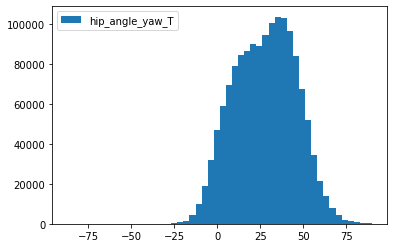

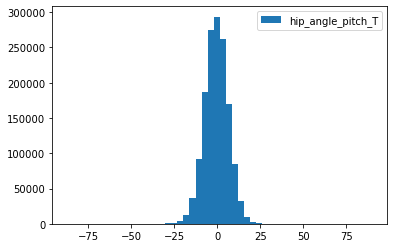

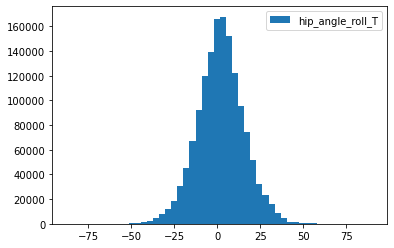

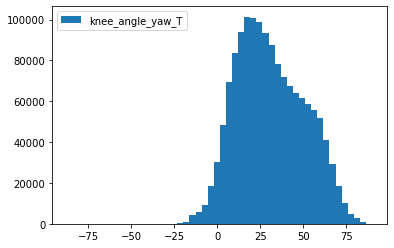

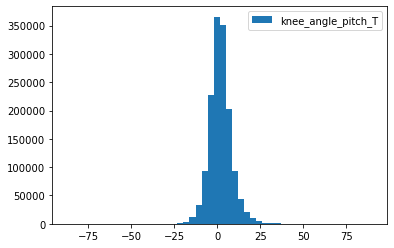

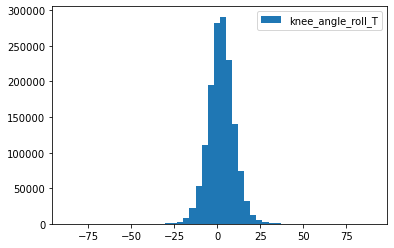

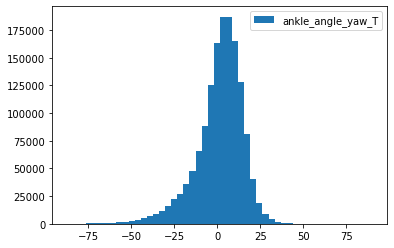

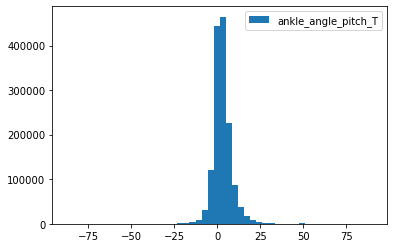

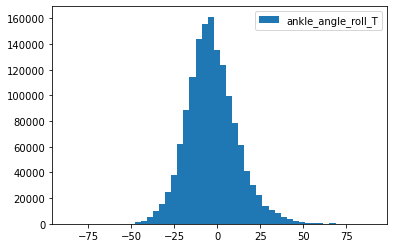

In [62]:
# Plot histogram of the data 
for f in range(len(features)):
    plt.hist(Y_train_data[:,:,f].reshape(-1,1), label = features[f], bins=50, range=(Y_train_data.min(), Y_train_data.max()))
    plt.legend()
    plt.show()

In [63]:
# Clear datasets from RAM 
X_train_windows = 1
Y_train_windows = 1 

X_val_windows = 1
Y_val_windows = 1
train_val_data = 1
val_data = 1 


### Scaling of the Data 
Data will be normalised (instead of standarization), to bound range of values between 0-1

In [64]:
# Normalisation equation = x - min(x) / max(x) - min(x)

def normalise_fit(data):
    '''
    Normalises X_train and output scales to use for normalising testing data and de-normalising output
    Args:
        prenormalised_data should be a 3-dimensional np.array 
    
    Output:
        normalised_data: np.array with the same shape as input data, but normalised
        scaling_factors: np.array with 2 rows index 0 for min_val, index 1 for max_value and nfeatures columns 

    '''
    
    if data.ndim != 3:
        raise ValueError("this function can only normalise 3-dimensional inputs")

    normalised_data = np.zeros(data.shape, dtype=np.float32) 

    features = data.shape[-1]
    scaling_factors = np.zeros((2, features))

    for feature in range(features):
        # print(feature)
        scaling_factors[0, feature], scaling_factors[1, feature] =  data[:,:,feature].min(), data[:,:,feature].max() #index 0 is for min, index 1 for max (applies to all features)
        normalised_data[:,:,feature] = (data[:,:,feature] - data[:,:,feature].min())/ (data[:,:,feature].max() - data[:,:,feature].min())

        # scaling_factors[0, feature], scaling_factors[1, feature] =  -90, 90 #index 0 is for min, index 1 for max (applies to all features)
        # normalised_data[:,:,feature] = (data[:,:,feature] - (-90))/ ((90) - (-90))

    return normalised_data, scaling_factors

In [65]:
def normalise_transform(data, scaling_factors):
    '''
    Normalise data based on the scaling factors used to normalised the training data 
    '''

    transformed_data = np.zeros(data.shape, dtype=np.float32)
    if data.shape[-1] > 1:
        for feature in range(data.shape[-1]): #loop over the number of features
            min_val = scaling_factors[0, feature] #get minimum value
            # print(f'min_val = {min_val}')
            max_val = scaling_factors[1, feature] # get maximum value 
            # print(f'max_val = {max_val}')

            transformed_data[:,:,feature] = (data[:,:,feature] - min_val) / (max_val - min_val)
    
    # in case there is one feature only where scaling_factor shape (2,1)
    else:
        min_val = scaling_factors[0]
        max_val = scaling_factors[1]
        transformed_data[:,:,0] = (data[:,:,0] - min_val) / (max_val - min_val)
    
    return transformed_data

In [66]:
# denorm_value = ((max-min) * norm_value) + min
def denormalise(data, scaling_factors):
    '''
    De-normalise data of the model
    '''
    denormalised_data = np.zeros(data.shape,  dtype=np.float32)

    for feature in range(data.shape[-1]):
        min_val = scaling_factors[0, feature]
        max_val = scaling_factors[1, feature]

        denormalised_data[:,:,feature] = ((max_val - min_val) * data[:,:,feature]) + min_val
    
    return denormalised_data

In [67]:
# Normalising data (find scalars on training data and apply the same on val and testing data)
X_train_norm, scalars = normalise_fit(X_train_data)
X_train_data = 1
Y_train_norm = normalise_transform(Y_train_data, scalars)
Y_train_data = 1

X_val_norm = normalise_transform(X_val_data, scalars)
X_val_data = 1 
Y_val_norm = normalise_transform(Y_val_data, scalars)
Y_val_data = 1 

In [68]:
scalars

array([[-39.58482742, -36.60737991, -55.66095734, -25.77786446,
        -33.52597809, -45.44993591, -88.9001236 , -55.81119919,
        -56.07572174],
       [ 89.70739746,  37.09776306,  69.19621277,  89.98672485,
         49.04060364,  57.06908417,  58.23037338,  71.76334381,
         81.16316986]])

In [69]:
scalars[1] - scalars[0]

array([129.29222488,  73.70514297, 124.8571701 , 115.76458931,
        82.56658173, 102.51902008, 147.13049698, 127.574543  ,
       137.2388916 ])

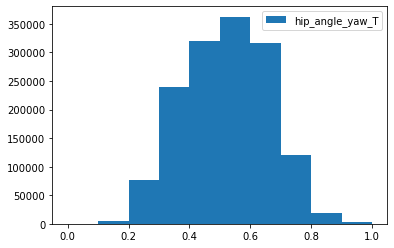

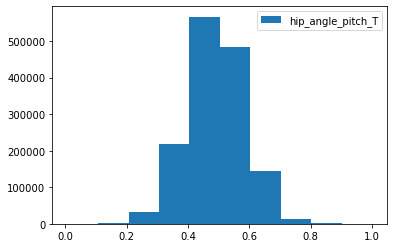

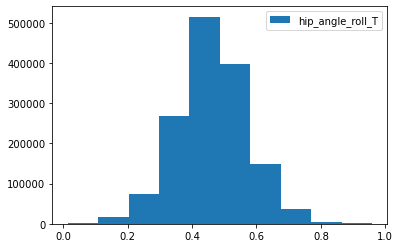

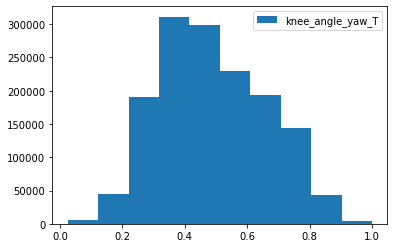

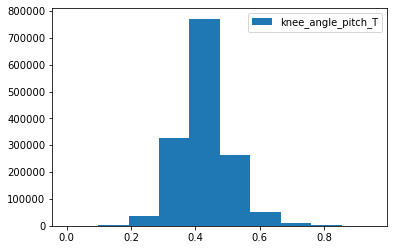

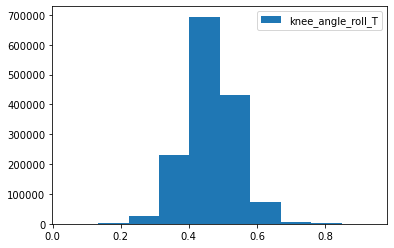

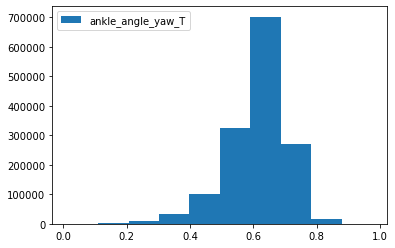

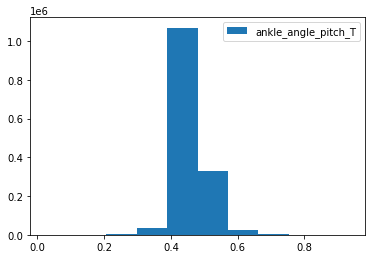

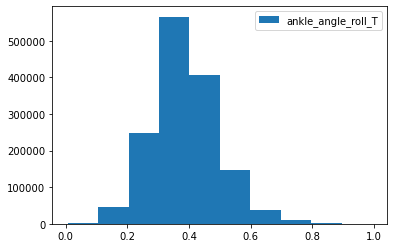

In [70]:
# Plot histogram of the data 
for f in range(len(features)):
    plt.hist(Y_train_norm[:,:,f].reshape(-1,1), label = features[f])
    plt.legend()
    plt.show()

### Scaling of Data 
Data will be normalised (instead of standarization), to bound range of values between 0-1

In [71]:
# Convert to Tensor 
# do not store on GPU (yet)
X_train = torch.from_numpy(X_train_norm).float()
Y_train = torch.from_numpy(Y_train_norm).float()

X_val = torch.from_numpy(X_val_norm).float()
Y_val = torch.from_numpy(Y_val_norm).float()

# X_test = torch.from_numpy(X_test_norm).float()
# Y_test = torch.from_numpy(Y_test_norm).float()

print(f'X_train shape: {X_train.shape}')
print(f'Y_train shape: {Y_train.shape}')

print(f'X_val shape: {X_val.shape}')
print(f'Y_val shape: {Y_val.shape}')

# print(f'X_test shape: {X_test.shape}')
# print(f'Y_test shape: {Y_test.shape}')

X_train shape: torch.Size([121970, 72, 9])
Y_train shape: torch.Size([121970, 12, 9])
X_val shape: torch.Size([30840, 72, 9])
Y_val shape: torch.Size([30840, 12, 9])


### Creating Datasets using dataloaders 

In [72]:
# Creates dataset object that gets individual samples for training/testing so that the Dataloader can generate batches
class gaitDataset(Dataset):
    def __init__(self, x, y):
        self.x = x 
        self.y = y 

    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, index):
        X_sample = self.x[index, :, :]
        Y_sample = self.y[index, :, :]
        return X_sample, Y_sample

In [73]:
train_dataset = gaitDataset(X_train, Y_train)
# train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle = False)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle = True, num_workers=0)

val_dataset = gaitDataset(X_val, Y_val) #ADJUSTED
# val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=0)

# test_dataset = gaitDataset(X_test, Y_test)
# # test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
# test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

print(f"Train Dataset length: {len(train_dataset)}")
print(f"Val Dataset length: {len(val_dataset)}")
# print(f"Test Dataset length: {len(test_dataset)}")

Train Dataset length: 121970
Val Dataset length: 30840


In [74]:
# Test Dataloader (Iterate through samples)
train_sample_X, train_sample_Y = next(iter(train_dataloader))

print(f"Feature batch shape: {train_sample_X.size()}")
print(f"Labels batch shape: {train_sample_Y.size()}")

Feature batch shape: torch.Size([32, 72, 9])
Labels batch shape: torch.Size([32, 12, 9])


### MLP Model 

In [75]:
# class MLP(nn.Module):
#     def __init__(self, input_size, output_size, in_seq_len, out_seq_len, device):
#         super(MLP, self).__init__()
#         # self.flatten = nn.Flatten()
#         self.input_size = input_size
#         self.output_size = output_size
#         self.in_seq_len = in_seq_len
#         self.out_seq_len = out_seq_len
#         self.device = device 

#         self.flatten = nn.Flatten(start_dim=1, end_dim=-1)
#         self.MLP = nn.Sequential(
#             nn.Linear(in_features=self.input_size*self.in_seq_len , out_features=200),
#             nn.ReLU(),
#             nn.Linear(200, 200),
#             nn.ReLU(),
#             nn.Linear(200, 200),
#             nn.ReLU(),
#             nn.Linear(200, self.output_size*self.out_seq_len),
#         )

#     def forward(self, x):
#         # print(f'shape of x: {x.shape}')
#         out = self.flatten(x)
#         # x is in the shape [batch_size, in_seq_len, features], but should be reshaped to [batch_size, in_seq_len*features]
#         # print(f'shape of flatten: {out.shape}')
#         out = self.MLP(out)
#         # print(f'shape of MLP: {out.shape}')
#         preds = out.reshape(x.shape[0],  self.out_seq_len,self.output_size)
#         return preds



In [76]:
# # MLP Hyper-parameter optimisation 
# class MLP(nn.Module):
#     def __init__(self, input_size, output_size, in_seq_len, out_seq_len, device, params):
#         super(MLP, self).__init__()
#         # self.flatten = nn.Flatten()
#         self.input_size = input_size
#         self.output_size = output_size
#         self.in_seq_len = in_seq_len
#         self.out_seq_len = out_seq_len
#         self.device = device 
#         self.layers = params['layers']
#         self.num_units = params['num_units']
        

#         self.flatten = nn.Flatten(start_dim=1, end_dim=-1)

#         # self.MLP = nn.Sequential(
#         #     nn.Linear(in_features=self.input_size*self.in_seq_len , out_features=200),
#         #     nn.ReLU(),
#         #     nn.Linear(200, 200),
#         #     nn.ReLU(),
#         #     nn.Linear(200, 200),
#         #     nn.ReLU(),
#         #     nn.Linear(200, self.output_size*self.out_seq_len),
#         # )

#         linear_layers_lst = [] #linear layer list
 
#         for i in range(self.layers):
#             linear_layers_lst.append(nn.Linear(self.num_units, self.num_units))
#             linear_layers_lst.append(nn.ReLU())

       
#         linear_layers = tuple((linear_layers_lst))

#         self.MLP = nn.Sequential(nn.Linear(in_features=self.input_size*self.in_seq_len, out_features=self.num_units), 
#                                 nn.ReLU(), 
#                                 *linear_layers, 
#                                 nn.Linear(self.num_units, self.output_size*self.out_seq_len))

#     def forward(self, x):
#         # print(f'shape of x: {x.shape}')
#         out = self.flatten(x)
#         # x is in the shape [batch_size, in_seq_len, features], but should be reshaped to [batch_size, in_seq_len*features]
#         # print(f'shape of flatten: {out.shape}')
#         out = self.MLP(out)
#         # print(f'shape of MLP: {out.shape}')
#         preds = out.reshape(x.shape[0],  self.out_seq_len,self.output_size)
#         return preds



In [77]:
# MLP Hyper-parameter optimisation 
class MLP(nn.Module):
    def __init__(self, input_size, output_size, in_seq_len, out_seq_len, device):
        super(MLP, self).__init__()
        # self.flatten = nn.Flatten()
        self.input_size = input_size
        self.output_size = output_size
        self.in_seq_len = in_seq_len
        self.out_seq_len = out_seq_len
        self.device = device 
        self.layers = 3
        self.num_units = 200
        

        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)

        # self.MLP = nn.Sequential(
        #     nn.Linear(in_features=self.input_size*self.in_seq_len , out_features=200),
        #     nn.ReLU(),
        #     nn.Linear(200, 200),
        #     nn.ReLU(),
        #     nn.Linear(200, 200),
        #     nn.ReLU(),
        #     nn.Linear(200, self.output_size*self.out_seq_len),
        # )

        linear_layers_lst = [] #linear layer list
 
        for i in range(self.layers):
            linear_layers_lst.append(nn.Linear(self.num_units, self.num_units))
            linear_layers_lst.append(nn.ReLU())

       
        linear_layers = tuple((linear_layers_lst))

        self.MLP = nn.Sequential(nn.Linear(in_features=self.input_size*self.in_seq_len, out_features=self.num_units), 
                                nn.ReLU(), 
                                *linear_layers, 
                                nn.Linear(self.num_units, self.output_size*self.out_seq_len))

    def forward(self, x):
        # print(f'shape of x: {x.shape}')
        out = self.flatten(x)
        # x is in the shape [batch_size, in_seq_len, features], but should be reshaped to [batch_size, in_seq_len*features]
        # print(f'shape of flatten: {out.shape}')
        out = self.MLP(out)
        # print(f'shape of MLP: {out.shape}')
        preds = out.reshape(x.shape[0],  self.out_seq_len,self.output_size)
        return preds



In [78]:
    #    for i in range(layers+1):
    #         layers_list.append(nn.Linear(200, 200))
    #         layers_list.append(nn.ReLU())
    #         if i ==3:
    #             layers_list.append(nn.Linear(200, self.output_size*self.out_seq_len))

In [79]:
# Training the MLP model using a loss function and a optimiser
def train_MLP(model, train_dataloader, val_dataloader, num_epochs, learning_rate):
    loss_function = nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(model.parameters(), lr = learning_rate)

    # train_loss, val_loss = np.zeros(num_epochs), np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    for epoch in tqdm(range(num_epochs)):
        # Loop over batch values 
        runningLoss_train = 0. 

        for idx, (batch_inputs, batch_targets) in enumerate(train_dataloader):
            
            # Save batch on GPU
            batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)

            # Means we are training the model, so uses techniques such as dropout etc., otherwise model.train(model=False)
            model.train() 

            #set gradients to zero
            optimiser.zero_grad()
            preds = model(batch_inputs)
            # print(f'shape of training predictions: {preds.shape}')
        
            loss = loss_function(preds, batch_targets)
            

            loss.backward()
            optimiser.step()
            runningLoss_train += loss.item()

        train_loss[epoch] = runningLoss_train / len(train_dataloader)

        print(f"Epoch: [{epoch + 1}/{num_epochs}]", f"Training loss: {runningLoss_train/len(train_dataloader)}")

        # Evaluate on validation set

        model.eval() # means we are evaluating the model, stops process such as dropout etc. 
        runningLoss_val = 0.

        with torch.no_grad(): # makes sure gradient is not stored 
            for idx, (batch_inputs, batch_targets) in enumerate(val_dataloader):
                
                batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
                optimiser.zero_grad() #WHY?
                preds = model(batch_inputs)
                # print(f'shape of validation predictions: {preds.shape}')

                loss = loss_function(preds, batch_targets)
                runningLoss_val += loss.item()

        val_loss[epoch] = runningLoss_val/len(val_dataloader)

        print(f"Epoch: [{epoch + 1}/{num_epochs}]", f"Validation loss: {runningLoss_val/len(val_dataloader)}")

    return train_loss, val_loss

        

In [80]:
# # MLP Hyper-parameter optimisation 
# def train_MLP(model, train_dataloader, val_dataloader, params):
#     loss_function = nn.MSELoss(reduction='mean')
#     optimiser = torch.optim.Adam(model.parameters(), lr = params['learning_rate'])

#     # train_loss, val_loss = np.zeros(num_epochs), np.zeros(num_epochs)
#     train_loss = np.zeros(params['num_epochs'])
#     val_loss = np.zeros(params['num_epochs'])

#     for epoch in tqdm(range(params['num_epochs'])):
#         # Loop over batch values 
#         runningLoss_train = 0. 

#         for idx, (batch_inputs, batch_targets) in enumerate(train_dataloader):
            
#             # Save batch on GPU
#             batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)

#             # Means we are training the model, so uses techniques such as dropout etc., otherwise model.train(model=False)
#             model.train() 

#             #set gradients to zero
#             optimiser.zero_grad()
#             preds = model(batch_inputs)
#             # print(f'shape of training predictions: {preds.shape}')
        
#             loss = loss_function(preds, batch_targets)
            

#             loss.backward()
#             optimiser.step()
#             runningLoss_train += loss.item()

#         train_loss[epoch] = runningLoss_train / len(train_dataloader)

#         # print(f"Epoch: [{epoch + 1}/{num_epochs}]", f"Training loss: {runningLoss_train/len(train_dataloader)}")

#         # Evaluate on validation set

#         model.eval() # means we are evaluating the model, stops process such as dropout etc. 
#         runningLoss_val = 0.

#         with torch.no_grad(): # makes sure gradient is not stored 
#             for idx, (batch_inputs, batch_targets) in enumerate(val_dataloader):
                
#                 batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
#                 optimiser.zero_grad() #WHY?
#                 preds = model(batch_inputs)
#                 # print(f'shape of validation predictions: {preds.shape}')

#                 loss = loss_function(preds, batch_targets)
#                 runningLoss_val += loss.item()

#         val_loss[epoch] = runningLoss_val/len(val_dataloader)

#         # print(f"Epoch: [{epoch + 1}/{num_epochs}]", f"Validation loss: {runningLoss_val/len(val_dataloader)}")

#     return val_loss[-1]

        

In [81]:
# Testing function 
def test_MLP(model, dataloader):
    loss_function = nn.MSELoss(reduction='mean')
    model.eval()
    actual_output, pred_output = [], []
    running_loss = 0. 
    
    with torch.no_grad():
        for idx, (batch_inputs, batch_targets) in tqdm(enumerate(dataloader)):

            batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)

            # if idx==0:
            #     batch_preds = model(batch_inputs)
            #     # print(f'batch shape: {batch_preds.shape}')
            #     loss = loss_function(batch_preds, batch_targets)
            #     running_loss += loss.item()
            #     current_preds = batch_preds
            #     all_preds = batch_preds

            # else:
            #     batch_preds = model(batch_inputs)
            #     print(f'batch shape: {batch_preds.shape}')
            #     loss = loss_function(batch_preds, batch_targets)
            #     running_loss += loss.item()
            #     all_preds = torch.cat((current_preds, batch_preds), dim=0)
            #     current_preds = batch_preds

            batch_preds = model(batch_inputs)
            loss = loss_function(batch_preds, batch_targets)
            running_loss += loss.item()
            actual_output.append(batch_targets)
            pred_output.append(batch_preds)


            #             lst = []
            # print(f'{x.size()}')
            # for i in range(10):
            #     x += i  # say we do something with x at iteration i
            #     lst.append(x)
            # # lstt = torch.stack([x for _ in range(10)])
            # lstt = torch.stack(lst)
            # print(lstt.size())

        total_loss = running_loss / len(dataloader)

        actual_output_tensor = torch.vstack(actual_output)
        pred_output_tensor = torch.vstack(pred_output)
    
    return pred_output_tensor, actual_output_tensor, total_loss

In [82]:
# Set model hyperparameters 
# Train CNN
input_size=len(features)
in_seq_len=input_window
out_seq_len=output_window
# kernel_size=1
num_epochs=180
learning_rate=0.0001
output_size = len(features)

In [319]:
def objective(trial):
    params = {           
            'learning_rate': trial.suggest_categorical('learning_rate', [0.1, 0.01, 0.001, 0.0001, 0.00001]),
            'num_epochs': trial.suggest_int('num_epochs', 10, 200, step=10),
            'layers': trial.suggest_categorical('layers', [1,2,3,4,6,8,10]),
            'num_units': trial.suggest_categorical('numb_units', [10,20,40,60,100,140,160,200])
            }
    
    model = MLP(input_size=input_size, in_seq_len=in_seq_len, out_seq_len=out_seq_len, output_size=output_size, params = params, device=DEVICE).to(DEVICE)
    
    val_loss = train_MLP(model, train_dataloader, val_dataloader, params)


    return val_loss


In [322]:
import optuna
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=100)


[I 2022-03-02 09:46:02,008] A new study created in memory with name: no-name-7e28d93c-4075-4e6f-b97b-e3d1d2cbf408
100%|██████████| 140/140 [23:22<00:00, 10.01s/it]
[I 2022-03-02 10:09:24,238] Trial 0 finished with value: 0.004154126045846716 and parameters: {'learning_rate': 0.01, 'num_epochs': 140, 'layers': 3, 'numb_units': 100}. Best is trial 0 with value: 0.004154126045846716.
100%|██████████| 180/180 [32:13<00:00, 10.74s/it]
[I 2022-03-02 10:41:38,220] Trial 1 finished with value: 0.0049497248178359534 and parameters: {'learning_rate': 1e-05, 'num_epochs': 180, 'layers': 4, 'numb_units': 10}. Best is trial 0 with value: 0.004154126045846716.
100%|██████████| 170/170 [49:48<00:00, 17.58s/it]
[I 2022-03-02 11:31:27,132] Trial 2 finished with value: 0.001423120479878614 and parameters: {'learning_rate': 0.001, 'num_epochs': 170, 'layers': 10, 'numb_units': 20}. Best is trial 2 with value: 0.001423120479878614.
100%|██████████| 90/90 [11:37<00:00,  7.75s/it]
[I 2022-03-02 11:43:04,925

KeyboardInterrupt: 

#### Run Model

In [83]:
# Set model hyperparameters 
# Train MLP
input_size=len(features)
in_seq_len=input_window
out_seq_len=output_window
output_size=len(features)
num_epochs=300
learning_rate=0.0001

model_MLP = MLP(input_size=input_size, in_seq_len=in_seq_len, out_seq_len=out_seq_len, output_size=output_size, device=DEVICE).to(DEVICE)

train_history, val_history = train_MLP(model_MLP, train_dataloader=train_dataloader, val_dataloader=val_dataloader, num_epochs=num_epochs, learning_rate=learning_rate)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: [1/300] Training loss: 0.006829640682889803


  0%|          | 1/300 [00:16<1:23:21, 16.73s/it]

Epoch: [1/300] Validation loss: 0.0020709552517628365
Epoch: [2/300] Training loss: 0.0016656500950939651


  1%|          | 2/300 [00:27<1:04:20, 12.96s/it]

Epoch: [2/300] Validation loss: 0.001386501660115951
Epoch: [3/300] Training loss: 0.001192574303158425


  1%|          | 3/300 [00:37<58:05, 11.74s/it]  

Epoch: [3/300] Validation loss: 0.0010937656998330982
Epoch: [4/300] Training loss: 0.0009935405744079175


  1%|▏         | 4/300 [00:47<55:01, 11.15s/it]

Epoch: [4/300] Validation loss: 0.0009303292141467935
Epoch: [5/300] Training loss: 0.0008923616700283259


  2%|▏         | 5/300 [00:57<53:16, 10.83s/it]

Epoch: [5/300] Validation loss: 0.0008970642725273356
Epoch: [6/300] Training loss: 0.0008269764328767459


  2%|▏         | 6/300 [01:08<52:08, 10.64s/it]

Epoch: [6/300] Validation loss: 0.0007536352262892606
Epoch: [7/300] Training loss: 0.0007798394061944321


  2%|▏         | 7/300 [01:18<51:16, 10.50s/it]

Epoch: [7/300] Validation loss: 0.0007685276534054738
Epoch: [8/300] Training loss: 0.0007430663191740755


  3%|▎         | 8/300 [01:28<50:47, 10.44s/it]

Epoch: [8/300] Validation loss: 0.0007734804069918013
Epoch: [9/300] Training loss: 0.0007153255310310134


  3%|▎         | 9/300 [01:38<50:19, 10.38s/it]

Epoch: [9/300] Validation loss: 0.0006558004356350719
Epoch: [10/300] Training loss: 0.0006893271329566071


  3%|▎         | 10/300 [01:49<49:59, 10.34s/it]

Epoch: [10/300] Validation loss: 0.0006894570003897415
Epoch: [11/300] Training loss: 0.0006698047390390517


  4%|▎         | 11/300 [01:59<49:48, 10.34s/it]

Epoch: [11/300] Validation loss: 0.0006360128905099557
Epoch: [12/300] Training loss: 0.0006513257613968728


  4%|▍         | 12/300 [02:09<49:32, 10.32s/it]

Epoch: [12/300] Validation loss: 0.0006565820730131417
Epoch: [13/300] Training loss: 0.0006374966381945924


  4%|▍         | 13/300 [02:20<49:25, 10.33s/it]

Epoch: [13/300] Validation loss: 0.0006732300435146028
Epoch: [14/300] Training loss: 0.000622236433107057


  5%|▍         | 14/300 [02:30<49:03, 10.29s/it]

Epoch: [14/300] Validation loss: 0.0005793422087399033
Epoch: [15/300] Training loss: 0.0006097335639536887


  5%|▌         | 15/300 [02:40<48:53, 10.29s/it]

Epoch: [15/300] Validation loss: 0.0006190745807392909
Epoch: [16/300] Training loss: 0.0005991820863544343


  5%|▌         | 16/300 [02:50<48:43, 10.29s/it]

Epoch: [16/300] Validation loss: 0.0006425991549090911
Epoch: [17/300] Training loss: 0.0005871970671610682


  6%|▌         | 17/300 [03:01<48:39, 10.32s/it]

Epoch: [17/300] Validation loss: 0.0006353802732877912
Epoch: [18/300] Training loss: 0.000578565215147716


  6%|▌         | 18/300 [03:11<48:28, 10.32s/it]

Epoch: [18/300] Validation loss: 0.0005881162241963028
Epoch: [19/300] Training loss: 0.0005709382813407503


  6%|▋         | 19/300 [03:21<48:17, 10.31s/it]

Epoch: [19/300] Validation loss: 0.0005669244914376022
Epoch: [20/300] Training loss: 0.0005630608372216685


  7%|▋         | 20/300 [03:32<48:03, 10.30s/it]

Epoch: [20/300] Validation loss: 0.0006104339566214602
Epoch: [21/300] Training loss: 0.0005535342685414325


  7%|▋         | 21/300 [03:42<47:49, 10.29s/it]

Epoch: [21/300] Validation loss: 0.0005413035214436627
Epoch: [22/300] Training loss: 0.0005473016409600053


  7%|▋         | 22/300 [03:52<47:41, 10.29s/it]

Epoch: [22/300] Validation loss: 0.000535828734020349
Epoch: [23/300] Training loss: 0.0005389653627228349


  8%|▊         | 23/300 [04:03<47:35, 10.31s/it]

Epoch: [23/300] Validation loss: 0.0005236085500006363
Epoch: [24/300] Training loss: 0.0005346638222616156


  8%|▊         | 24/300 [04:13<47:33, 10.34s/it]

Epoch: [24/300] Validation loss: 0.0004929171876507982
Epoch: [25/300] Training loss: 0.0005286349623242578


  8%|▊         | 25/300 [04:23<47:28, 10.36s/it]

Epoch: [25/300] Validation loss: 0.0005249145581566678
Epoch: [26/300] Training loss: 0.000523267841218958


  9%|▊         | 26/300 [04:34<47:10, 10.33s/it]

Epoch: [26/300] Validation loss: 0.0005057368185566796
Epoch: [27/300] Training loss: 0.0005169087300089418


  9%|▉         | 27/300 [04:44<46:55, 10.31s/it]

Epoch: [27/300] Validation loss: 0.0005187250847246641
Epoch: [28/300] Training loss: 0.0005128963946621715


  9%|▉         | 28/300 [04:54<46:43, 10.31s/it]

Epoch: [28/300] Validation loss: 0.000475474149893237
Epoch: [29/300] Training loss: 0.0005087950936392666


 10%|▉         | 29/300 [05:05<46:33, 10.31s/it]

Epoch: [29/300] Validation loss: 0.0005320816672637989
Epoch: [30/300] Training loss: 0.0005043016254867926


 10%|█         | 30/300 [05:15<46:28, 10.33s/it]

Epoch: [30/300] Validation loss: 0.0005018065866620059
Epoch: [31/300] Training loss: 0.0004986295807096547


 10%|█         | 31/300 [05:25<46:28, 10.37s/it]

Epoch: [31/300] Validation loss: 0.00046850920592519723
Epoch: [32/300] Training loss: 0.0004924915081446116


 11%|█         | 32/300 [05:35<45:27, 10.18s/it]

Epoch: [32/300] Validation loss: 0.00048347796281824793
Epoch: [33/300] Training loss: 0.0004920633543042831


 11%|█         | 33/300 [05:45<44:26,  9.99s/it]

Epoch: [33/300] Validation loss: 0.0005910717853232909
Epoch: [34/300] Training loss: 0.000486341918822806


 11%|█▏        | 34/300 [05:54<43:17,  9.77s/it]

Epoch: [34/300] Validation loss: 0.0004984888103713293
Epoch: [35/300] Training loss: 0.00048421039111039564


 12%|█▏        | 35/300 [06:03<42:25,  9.60s/it]

Epoch: [35/300] Validation loss: 0.00047141866721874643
Epoch: [36/300] Training loss: 0.000478934954759271


 12%|█▏        | 36/300 [06:12<41:43,  9.48s/it]

Epoch: [36/300] Validation loss: 0.0005122475582138728
Epoch: [37/300] Training loss: 0.0004766468074248961


 12%|█▏        | 37/300 [06:21<41:09,  9.39s/it]

Epoch: [37/300] Validation loss: 0.0005134403964270803
Epoch: [38/300] Training loss: 0.00047324668639846457


 13%|█▎        | 38/300 [06:31<40:46,  9.34s/it]

Epoch: [38/300] Validation loss: 0.0005072502671625982
Epoch: [39/300] Training loss: 0.0004708637279004043


 13%|█▎        | 39/300 [06:40<40:26,  9.30s/it]

Epoch: [39/300] Validation loss: 0.00044824476624936586
Epoch: [40/300] Training loss: 0.00046786359455474946


 13%|█▎        | 40/300 [06:49<40:09,  9.27s/it]

Epoch: [40/300] Validation loss: 0.000442587582916659
Epoch: [41/300] Training loss: 0.00046568248263417436


 14%|█▎        | 41/300 [06:58<39:54,  9.25s/it]

Epoch: [41/300] Validation loss: 0.0005083584061343632
Epoch: [42/300] Training loss: 0.00046365867610029504


 14%|█▍        | 42/300 [07:08<39:44,  9.24s/it]

Epoch: [42/300] Validation loss: 0.00045261046810184813
Epoch: [43/300] Training loss: 0.000460758255184319


 14%|█▍        | 43/300 [07:17<39:30,  9.22s/it]

Epoch: [43/300] Validation loss: 0.00044316481533812944
Epoch: [44/300] Training loss: 0.0004568830552046844


 15%|█▍        | 44/300 [07:26<39:21,  9.22s/it]

Epoch: [44/300] Validation loss: 0.0004666971074875166
Epoch: [45/300] Training loss: 0.0004542355105506072


 15%|█▌        | 45/300 [07:35<39:09,  9.21s/it]

Epoch: [45/300] Validation loss: 0.000443617174635193
Epoch: [46/300] Training loss: 0.00045392796691179235


 15%|█▌        | 46/300 [07:44<38:58,  9.21s/it]

Epoch: [46/300] Validation loss: 0.0004954162594841511
Epoch: [47/300] Training loss: 0.0004520975813048634


 16%|█▌        | 47/300 [07:53<38:47,  9.20s/it]

Epoch: [47/300] Validation loss: 0.00041436932077889785
Epoch: [48/300] Training loss: 0.0004485590594672808


 16%|█▌        | 48/300 [08:03<38:40,  9.21s/it]

Epoch: [48/300] Validation loss: 0.0004402555412268923
Epoch: [49/300] Training loss: 0.00044637584100809785


 16%|█▋        | 49/300 [08:12<38:30,  9.21s/it]

Epoch: [49/300] Validation loss: 0.0004679670316639117
Epoch: [50/300] Training loss: 0.0004424388611663007


 17%|█▋        | 50/300 [08:21<38:23,  9.21s/it]

Epoch: [50/300] Validation loss: 0.00045489362550052117
Epoch: [51/300] Training loss: 0.0004415622457267852


 17%|█▋        | 51/300 [08:30<38:12,  9.21s/it]

Epoch: [51/300] Validation loss: 0.00047563679209094946
Epoch: [52/300] Training loss: 0.0004384845448437988


 17%|█▋        | 52/300 [08:40<38:04,  9.21s/it]

Epoch: [52/300] Validation loss: 0.0004482896302568753
Epoch: [53/300] Training loss: 0.00043838771986606524


 18%|█▊        | 53/300 [08:49<37:55,  9.21s/it]

Epoch: [53/300] Validation loss: 0.000553883184957573
Epoch: [54/300] Training loss: 0.0004344102633299901


 18%|█▊        | 54/300 [08:58<37:44,  9.20s/it]

Epoch: [54/300] Validation loss: 0.0004315221766362554
Epoch: [55/300] Training loss: 0.0004337624571665622


 18%|█▊        | 55/300 [09:07<37:33,  9.20s/it]

Epoch: [55/300] Validation loss: 0.0004533497272535127
Epoch: [56/300] Training loss: 0.0004332130207666851


 19%|█▊        | 56/300 [09:16<37:26,  9.21s/it]

Epoch: [56/300] Validation loss: 0.0004614491944157333
Epoch: [57/300] Training loss: 0.0004302861345550453


 19%|█▉        | 57/300 [09:26<37:16,  9.20s/it]

Epoch: [57/300] Validation loss: 0.0004273064924402576
Epoch: [58/300] Training loss: 0.0004284822478521384


 19%|█▉        | 58/300 [09:35<37:08,  9.21s/it]

Epoch: [58/300] Validation loss: 0.00044650833360455677
Epoch: [59/300] Training loss: 0.0004267082283062802


 20%|█▉        | 59/300 [09:44<37:00,  9.21s/it]

Epoch: [59/300] Validation loss: 0.00044902652897920337
Epoch: [60/300] Training loss: 0.0004251347563198901


 20%|██        | 60/300 [09:53<36:49,  9.21s/it]

Epoch: [60/300] Validation loss: 0.00042229888139411426
Epoch: [61/300] Training loss: 0.00042283271691489626


 20%|██        | 61/300 [10:02<36:39,  9.20s/it]

Epoch: [61/300] Validation loss: 0.00045501563319582804
Epoch: [62/300] Training loss: 0.0004253647965154596


 21%|██        | 62/300 [10:12<36:30,  9.20s/it]

Epoch: [62/300] Validation loss: 0.0004689515832726094
Epoch: [63/300] Training loss: 0.00042130048691533536


 21%|██        | 63/300 [10:21<36:20,  9.20s/it]

Epoch: [63/300] Validation loss: 0.00046161623425053285
Epoch: [64/300] Training loss: 0.00041853363417367013


 21%|██▏       | 64/300 [10:30<36:10,  9.20s/it]

Epoch: [64/300] Validation loss: 0.000428439768215282
Epoch: [65/300] Training loss: 0.0004180170787271571


 22%|██▏       | 65/300 [10:39<36:01,  9.20s/it]

Epoch: [65/300] Validation loss: 0.00042146399298804055
Epoch: [66/300] Training loss: 0.0004167199657893955


 22%|██▏       | 66/300 [10:48<35:51,  9.19s/it]

Epoch: [66/300] Validation loss: 0.00040864909385476854
Epoch: [67/300] Training loss: 0.00041443625648759095


 22%|██▏       | 67/300 [10:58<35:41,  9.19s/it]

Epoch: [67/300] Validation loss: 0.0004357260377936092
Epoch: [68/300] Training loss: 0.00041481275213208635


 23%|██▎       | 68/300 [11:07<35:33,  9.20s/it]

Epoch: [68/300] Validation loss: 0.00038458350346328525
Epoch: [69/300] Training loss: 0.0004146386983956856


 23%|██▎       | 69/300 [11:16<35:24,  9.20s/it]

Epoch: [69/300] Validation loss: 0.000454288840688054
Epoch: [70/300] Training loss: 0.00041232623471934663


 23%|██▎       | 70/300 [11:25<35:14,  9.19s/it]

Epoch: [70/300] Validation loss: 0.0004162693370729723
Epoch: [71/300] Training loss: 0.00041020067396022427


 24%|██▎       | 71/300 [11:34<35:05,  9.20s/it]

Epoch: [71/300] Validation loss: 0.00040647544970188126
Epoch: [72/300] Training loss: 0.00040845757636004263


 24%|██▍       | 72/300 [11:44<34:56,  9.19s/it]

Epoch: [72/300] Validation loss: 0.000415048620892308
Epoch: [73/300] Training loss: 0.0004087808555512956


 24%|██▍       | 73/300 [11:53<34:45,  9.19s/it]

Epoch: [73/300] Validation loss: 0.0004053091324145589
Epoch: [74/300] Training loss: 0.0004062541602166276


 25%|██▍       | 74/300 [12:02<34:36,  9.19s/it]

Epoch: [74/300] Validation loss: 0.0004060120786807338
Epoch: [75/300] Training loss: 0.0004045864267563699


 25%|██▌       | 75/300 [12:11<34:26,  9.18s/it]

Epoch: [75/300] Validation loss: 0.0004612224271204091
Epoch: [76/300] Training loss: 0.0004033891863117199


 25%|██▌       | 76/300 [12:21<34:46,  9.32s/it]

Epoch: [76/300] Validation loss: 0.00047831324398173674
Epoch: [77/300] Training loss: 0.00040248770769201766


 26%|██▌       | 77/300 [12:31<36:04,  9.71s/it]

Epoch: [77/300] Validation loss: 0.00040946098596279806
Epoch: [78/300] Training loss: 0.00040034937508489645


 26%|██▌       | 78/300 [12:42<36:41,  9.92s/it]

Epoch: [78/300] Validation loss: 0.000387447741147951
Epoch: [79/300] Training loss: 0.0004001903851155083


 26%|██▋       | 79/300 [12:52<36:27,  9.90s/it]

Epoch: [79/300] Validation loss: 0.0003879561854132231
Epoch: [80/300] Training loss: 0.0003995454820057249


 27%|██▋       | 80/300 [13:02<37:09, 10.13s/it]

Epoch: [80/300] Validation loss: 0.0004614224290055961
Epoch: [81/300] Training loss: 0.00039808939550956245


 27%|██▋       | 81/300 [13:12<36:59, 10.14s/it]

Epoch: [81/300] Validation loss: 0.00045384339098451484
Epoch: [82/300] Training loss: 0.0003953816968530056


 27%|██▋       | 82/300 [13:22<35:42,  9.83s/it]

Epoch: [82/300] Validation loss: 0.0004724083500078597
Epoch: [83/300] Training loss: 0.0003960393859771462


 28%|██▊       | 83/300 [13:31<34:55,  9.66s/it]

Epoch: [83/300] Validation loss: 0.0004617600284272387
Epoch: [84/300] Training loss: 0.0003947767046191825


 28%|██▊       | 84/300 [13:40<34:40,  9.63s/it]

Epoch: [84/300] Validation loss: 0.0004231812541487316
Epoch: [85/300] Training loss: 0.00039357405220197364


 28%|██▊       | 85/300 [13:51<35:22,  9.87s/it]

Epoch: [85/300] Validation loss: 0.00042643435796939176
Epoch: [86/300] Training loss: 0.0003938473721945747


 29%|██▊       | 86/300 [14:00<34:56,  9.80s/it]

Epoch: [86/300] Validation loss: 0.0003837836239763721
Epoch: [87/300] Training loss: 0.0003915659363966634


 29%|██▉       | 87/300 [14:10<34:19,  9.67s/it]

Epoch: [87/300] Validation loss: 0.0004122295722632748
Epoch: [88/300] Training loss: 0.0003913825584442322


 29%|██▉       | 88/300 [14:19<33:52,  9.59s/it]

Epoch: [88/300] Validation loss: 0.0004144939105334369
Epoch: [89/300] Training loss: 0.0003882648610114572


 30%|██▉       | 89/300 [14:28<33:22,  9.49s/it]

Epoch: [89/300] Validation loss: 0.00039421492588623714
Epoch: [90/300] Training loss: 0.0003883230685273096


 30%|███       | 90/300 [14:38<33:00,  9.43s/it]

Epoch: [90/300] Validation loss: 0.00038815737604194983
Epoch: [91/300] Training loss: 0.00038686961819915444


 30%|███       | 91/300 [14:47<32:41,  9.38s/it]

Epoch: [91/300] Validation loss: 0.0004242683388087493
Epoch: [92/300] Training loss: 0.0003867235817171226


 31%|███       | 92/300 [14:56<32:27,  9.36s/it]

Epoch: [92/300] Validation loss: 0.00038703270520386
Epoch: [93/300] Training loss: 0.0003857137210664873


 31%|███       | 93/300 [15:06<32:21,  9.38s/it]

Epoch: [93/300] Validation loss: 0.00038036552759725985
Epoch: [94/300] Training loss: 0.0003844862527742685


 31%|███▏      | 94/300 [15:15<32:10,  9.37s/it]

Epoch: [94/300] Validation loss: 0.00039806756885583163
Epoch: [95/300] Training loss: 0.0003829183869857506


 32%|███▏      | 95/300 [15:24<31:59,  9.36s/it]

Epoch: [95/300] Validation loss: 0.0004339350398443446
Epoch: [96/300] Training loss: 0.0003826491668196649


 32%|███▏      | 96/300 [15:34<31:49,  9.36s/it]

Epoch: [96/300] Validation loss: 0.00037280303146581444
Epoch: [97/300] Training loss: 0.0003804581512022797


 32%|███▏      | 97/300 [15:43<31:37,  9.35s/it]

Epoch: [97/300] Validation loss: 0.0004114335771414347
Epoch: [98/300] Training loss: 0.0003819757181125757


 33%|███▎      | 98/300 [15:52<31:25,  9.34s/it]

Epoch: [98/300] Validation loss: 0.00037989420931328847
Epoch: [99/300] Training loss: 0.00038094142193704204


 33%|███▎      | 99/300 [16:02<31:25,  9.38s/it]

Epoch: [99/300] Validation loss: 0.0004294872871084193
Epoch: [100/300] Training loss: 0.00037874541060364065


 33%|███▎      | 100/300 [16:11<31:12,  9.36s/it]

Epoch: [100/300] Validation loss: 0.00044094434734873465
Epoch: [101/300] Training loss: 0.0003763149455039758


 34%|███▎      | 101/300 [16:21<31:07,  9.38s/it]

Epoch: [101/300] Validation loss: 0.0003864676051096135
Epoch: [102/300] Training loss: 0.0003781236817700589


 34%|███▍      | 102/300 [16:30<30:50,  9.34s/it]

Epoch: [102/300] Validation loss: 0.0003917988787975918
Epoch: [103/300] Training loss: 0.00037479508460181983


 34%|███▍      | 103/300 [16:39<30:51,  9.40s/it]

Epoch: [103/300] Validation loss: 0.0003812524603092386
Epoch: [104/300] Training loss: 0.0003744915501912506


 35%|███▍      | 104/300 [16:50<32:19,  9.90s/it]

Epoch: [104/300] Validation loss: 0.0003836926175816385
Epoch: [105/300] Training loss: 0.00037341775926650776


 35%|███▌      | 105/300 [17:00<32:05,  9.87s/it]

Epoch: [105/300] Validation loss: 0.00036622346534043035
Epoch: [106/300] Training loss: 0.00037308913647990106


 35%|███▌      | 106/300 [17:10<31:54,  9.87s/it]

Epoch: [106/300] Validation loss: 0.00036595743448708756
Epoch: [107/300] Training loss: 0.00037246483740474855


 36%|███▌      | 107/300 [17:20<31:19,  9.74s/it]

Epoch: [107/300] Validation loss: 0.000387508207359699
Epoch: [108/300] Training loss: 0.000369498405432031


 36%|███▌      | 108/300 [17:29<30:46,  9.61s/it]

Epoch: [108/300] Validation loss: 0.0004128984532657628
Epoch: [109/300] Training loss: 0.0003711938482507304


 36%|███▋      | 109/300 [17:38<30:21,  9.53s/it]

Epoch: [109/300] Validation loss: 0.00041613463966982126
Epoch: [110/300] Training loss: 0.0003692937047819151


 37%|███▋      | 110/300 [17:48<30:04,  9.50s/it]

Epoch: [110/300] Validation loss: 0.0003522478038115674
Epoch: [111/300] Training loss: 0.00036794328886962074


 37%|███▋      | 111/300 [17:57<30:00,  9.53s/it]

Epoch: [111/300] Validation loss: 0.0003992172989674749
Epoch: [112/300] Training loss: 0.00036888044810978374


 37%|███▋      | 112/300 [18:07<29:42,  9.48s/it]

Epoch: [112/300] Validation loss: 0.00036081070762950754
Epoch: [113/300] Training loss: 0.00036626137513676507


 38%|███▊      | 113/300 [18:16<29:26,  9.44s/it]

Epoch: [113/300] Validation loss: 0.00042658972828523394
Epoch: [114/300] Training loss: 0.00036643097396770315


 38%|███▊      | 114/300 [18:26<29:43,  9.59s/it]

Epoch: [114/300] Validation loss: 0.0004011377589211942
Epoch: [115/300] Training loss: 0.00036471063358170996


 38%|███▊      | 115/300 [18:35<29:22,  9.53s/it]

Epoch: [115/300] Validation loss: 0.0004187168370093281
Epoch: [116/300] Training loss: 0.00036398062534408096


 39%|███▊      | 116/300 [18:45<28:53,  9.42s/it]

Epoch: [116/300] Validation loss: 0.00037656879127453106
Epoch: [117/300] Training loss: 0.0003626771614267669


 39%|███▉      | 117/300 [18:54<28:33,  9.36s/it]

Epoch: [117/300] Validation loss: 0.0004037916457880225
Epoch: [118/300] Training loss: 0.0003633901836435887


 39%|███▉      | 118/300 [19:03<28:21,  9.35s/it]

Epoch: [118/300] Validation loss: 0.00039790936869062404
Epoch: [119/300] Training loss: 0.00036264919727619987


 40%|███▉      | 119/300 [19:12<28:08,  9.33s/it]

Epoch: [119/300] Validation loss: 0.00037391212535418255
Epoch: [120/300] Training loss: 0.00036130867458959715


 40%|████      | 120/300 [19:22<28:01,  9.34s/it]

Epoch: [120/300] Validation loss: 0.00036865935763365904
Epoch: [121/300] Training loss: 0.00036071431972564065


 40%|████      | 121/300 [19:31<27:58,  9.37s/it]

Epoch: [121/300] Validation loss: 0.00035522094368234207
Epoch: [122/300] Training loss: 0.0003593188845967226


 41%|████      | 122/300 [19:41<27:51,  9.39s/it]

Epoch: [122/300] Validation loss: 0.0003510636204103234
Epoch: [123/300] Training loss: 0.0003598782297552774


 41%|████      | 123/300 [19:50<27:40,  9.38s/it]

Epoch: [123/300] Validation loss: 0.00035895646474707227
Epoch: [124/300] Training loss: 0.0003591570261058582


 41%|████▏     | 124/300 [19:59<27:31,  9.38s/it]

Epoch: [124/300] Validation loss: 0.0003584623228558349
Epoch: [125/300] Training loss: 0.0003568122862662731


 42%|████▏     | 125/300 [20:09<27:15,  9.35s/it]

Epoch: [125/300] Validation loss: 0.0003908660534207267
Epoch: [126/300] Training loss: 0.00035776359707984757


 42%|████▏     | 126/300 [20:18<27:11,  9.38s/it]

Epoch: [126/300] Validation loss: 0.0004040348476903461
Epoch: [127/300] Training loss: 0.0003555128510421091


 42%|████▏     | 127/300 [20:27<26:54,  9.33s/it]

Epoch: [127/300] Validation loss: 0.0003621612582923323
Epoch: [128/300] Training loss: 0.00035663542124643823


 43%|████▎     | 128/300 [20:36<26:39,  9.30s/it]

Epoch: [128/300] Validation loss: 0.0003778780280839202
Epoch: [129/300] Training loss: 0.0003553085583075246


 43%|████▎     | 129/300 [20:46<26:25,  9.27s/it]

Epoch: [129/300] Validation loss: 0.00035391189757248107
Epoch: [130/300] Training loss: 0.0003533121771025222


 43%|████▎     | 130/300 [20:55<26:14,  9.26s/it]

Epoch: [130/300] Validation loss: 0.00036015941586207284
Epoch: [131/300] Training loss: 0.0003525073815030322


 44%|████▎     | 131/300 [21:04<26:02,  9.24s/it]

Epoch: [131/300] Validation loss: 0.0003552015859820142
Epoch: [132/300] Training loss: 0.0003511121726541055


 44%|████▍     | 132/300 [21:13<25:52,  9.24s/it]

Epoch: [132/300] Validation loss: 0.00033996770145065786
Epoch: [133/300] Training loss: 0.00035174488185444144


 44%|████▍     | 133/300 [21:23<25:41,  9.23s/it]

Epoch: [133/300] Validation loss: 0.0003682612545638059
Epoch: [134/300] Training loss: 0.00035179748895577717


 45%|████▍     | 134/300 [21:32<25:39,  9.28s/it]

Epoch: [134/300] Validation loss: 0.00036736688777044537
Epoch: [135/300] Training loss: 0.0003503848885716543


 45%|████▌     | 135/300 [21:41<25:30,  9.28s/it]

Epoch: [135/300] Validation loss: 0.0003756563294312049
Epoch: [136/300] Training loss: 0.0003494585127740327


 45%|████▌     | 136/300 [21:51<25:25,  9.30s/it]

Epoch: [136/300] Validation loss: 0.00035045756505262707
Epoch: [137/300] Training loss: 0.00034919954400849435


 46%|████▌     | 137/300 [22:00<25:20,  9.33s/it]

Epoch: [137/300] Validation loss: 0.00035207865271124126
Epoch: [138/300] Training loss: 0.0003492227059239663


 46%|████▌     | 138/300 [22:09<25:15,  9.35s/it]

Epoch: [138/300] Validation loss: 0.00033262853753229863
Epoch: [139/300] Training loss: 0.0003473442146704964


 46%|████▋     | 139/300 [22:19<25:14,  9.41s/it]

Epoch: [139/300] Validation loss: 0.00037103785382205993
Epoch: [140/300] Training loss: 0.00034787698941374175


 47%|████▋     | 140/300 [22:28<25:07,  9.42s/it]

Epoch: [140/300] Validation loss: 0.0003869163105626594
Epoch: [141/300] Training loss: 0.00034690087644487997


 47%|████▋     | 141/300 [22:38<24:54,  9.40s/it]

Epoch: [141/300] Validation loss: 0.00038559812323853983
Epoch: [142/300] Training loss: 0.0003468256265901707


 47%|████▋     | 142/300 [22:47<24:47,  9.42s/it]

Epoch: [142/300] Validation loss: 0.00035641493783689863
Epoch: [143/300] Training loss: 0.0003465127552745452


 48%|████▊     | 143/300 [22:57<24:37,  9.41s/it]

Epoch: [143/300] Validation loss: 0.0003822226311839514
Epoch: [144/300] Training loss: 0.00034607079262864883


 48%|████▊     | 144/300 [23:06<24:30,  9.42s/it]

Epoch: [144/300] Validation loss: 0.00033919500577163543
Epoch: [145/300] Training loss: 0.000344920561394117


 48%|████▊     | 145/300 [23:15<24:21,  9.43s/it]

Epoch: [145/300] Validation loss: 0.00037282454067586606
Epoch: [146/300] Training loss: 0.00034355447888301645


 49%|████▊     | 146/300 [23:25<24:03,  9.38s/it]

Epoch: [146/300] Validation loss: 0.0003689301135119909
Epoch: [147/300] Training loss: 0.000345305896685791


 49%|████▉     | 147/300 [23:34<23:50,  9.35s/it]

Epoch: [147/300] Validation loss: 0.0003545766307206011
Epoch: [148/300] Training loss: 0.0003432502622769817


 49%|████▉     | 148/300 [23:43<23:45,  9.38s/it]

Epoch: [148/300] Validation loss: 0.0003423800200186003
Epoch: [149/300] Training loss: 0.0003426569918857275


 50%|████▉     | 149/300 [23:53<23:58,  9.52s/it]

Epoch: [149/300] Validation loss: 0.0003526800165254298
Epoch: [150/300] Training loss: 0.00034271345598135627


 50%|█████     | 150/300 [24:03<23:40,  9.47s/it]

Epoch: [150/300] Validation loss: 0.0003499924194374937
Epoch: [151/300] Training loss: 0.00034118111241425133


 50%|█████     | 151/300 [24:12<23:21,  9.40s/it]

Epoch: [151/300] Validation loss: 0.00035618166767709976
Epoch: [152/300] Training loss: 0.0003415609643671401


 51%|█████     | 152/300 [24:21<23:06,  9.37s/it]

Epoch: [152/300] Validation loss: 0.0003870179754654351
Epoch: [153/300] Training loss: 0.00034115783730534016


 51%|█████     | 153/300 [24:31<22:57,  9.37s/it]

Epoch: [153/300] Validation loss: 0.00034815769725495124
Epoch: [154/300] Training loss: 0.0003400496541581567


 51%|█████▏    | 154/300 [24:40<22:47,  9.37s/it]

Epoch: [154/300] Validation loss: 0.0003611688426716535
Epoch: [155/300] Training loss: 0.000337472843989584


 52%|█████▏    | 155/300 [24:49<22:39,  9.38s/it]

Epoch: [155/300] Validation loss: 0.0003865111583578874
Epoch: [156/300] Training loss: 0.00033874517550433844


 52%|█████▏    | 156/300 [24:59<22:30,  9.38s/it]

Epoch: [156/300] Validation loss: 0.0003393805467514456
Epoch: [157/300] Training loss: 0.0003364938870031137


 52%|█████▏    | 157/300 [25:08<22:21,  9.38s/it]

Epoch: [157/300] Validation loss: 0.00040562355000123816
Epoch: [158/300] Training loss: 0.0003374226991356737


 53%|█████▎    | 158/300 [25:17<22:07,  9.35s/it]

Epoch: [158/300] Validation loss: 0.00034646761796994647
Epoch: [159/300] Training loss: 0.00033591544213516035


 53%|█████▎    | 159/300 [25:27<22:01,  9.37s/it]

Epoch: [159/300] Validation loss: 0.000443879962721028
Epoch: [160/300] Training loss: 0.00033619726915755344


 53%|█████▎    | 160/300 [25:36<21:51,  9.37s/it]

Epoch: [160/300] Validation loss: 0.0003314367188739733
Epoch: [161/300] Training loss: 0.0003355532862388166


 54%|█████▎    | 161/300 [25:45<21:38,  9.34s/it]

Epoch: [161/300] Validation loss: 0.0004340091526882213
Epoch: [162/300] Training loss: 0.0003353216076892256


 54%|█████▍    | 162/300 [25:55<21:27,  9.33s/it]

Epoch: [162/300] Validation loss: 0.0003605186937880921
Epoch: [163/300] Training loss: 0.00033520119599614426


 54%|█████▍    | 163/300 [26:04<21:14,  9.30s/it]

Epoch: [163/300] Validation loss: 0.0003519632377279188
Epoch: [164/300] Training loss: 0.00033475708659155124


 55%|█████▍    | 164/300 [26:13<20:59,  9.26s/it]

Epoch: [164/300] Validation loss: 0.00034445236756500624
Epoch: [165/300] Training loss: 0.0003341437301214673


 55%|█████▌    | 165/300 [26:22<20:46,  9.23s/it]

Epoch: [165/300] Validation loss: 0.0003734698499456537
Epoch: [166/300] Training loss: 0.0003325644315130997


 55%|█████▌    | 166/300 [26:32<20:39,  9.25s/it]

Epoch: [166/300] Validation loss: 0.0003325235150769909
Epoch: [167/300] Training loss: 0.000333122049891462


 56%|█████▌    | 167/300 [26:41<20:33,  9.28s/it]

Epoch: [167/300] Validation loss: 0.00033324088502341507
Epoch: [168/300] Training loss: 0.00033248153873827386


 56%|█████▌    | 168/300 [26:50<20:25,  9.29s/it]

Epoch: [168/300] Validation loss: 0.0003563947507075934
Epoch: [169/300] Training loss: 0.00033328114323594567


 56%|█████▋    | 169/300 [27:00<20:17,  9.30s/it]

Epoch: [169/300] Validation loss: 0.0003992933760632865
Epoch: [170/300] Training loss: 0.0003296558469497762


 57%|█████▋    | 170/300 [27:09<20:04,  9.26s/it]

Epoch: [170/300] Validation loss: 0.00035319592761389303
Epoch: [171/300] Training loss: 0.0003306360218956676


 57%|█████▋    | 171/300 [27:18<19:56,  9.27s/it]

Epoch: [171/300] Validation loss: 0.00035230120046439103
Epoch: [172/300] Training loss: 0.0003282723331338433


 57%|█████▋    | 172/300 [27:27<19:46,  9.27s/it]

Epoch: [172/300] Validation loss: 0.0003747155732756357
Epoch: [173/300] Training loss: 0.00032918151111768583


 58%|█████▊    | 173/300 [27:37<19:36,  9.26s/it]

Epoch: [173/300] Validation loss: 0.0003516819656755789
Epoch: [174/300] Training loss: 0.0003291752210256066


 58%|█████▊    | 174/300 [27:46<19:31,  9.30s/it]

Epoch: [174/300] Validation loss: 0.0003487725825155496
Epoch: [175/300] Training loss: 0.00032915248208147753


 58%|█████▊    | 175/300 [27:55<19:23,  9.31s/it]

Epoch: [175/300] Validation loss: 0.0003776925751703687
Epoch: [176/300] Training loss: 0.00032701648766021485


 59%|█████▊    | 176/300 [28:05<19:15,  9.32s/it]

Epoch: [176/300] Validation loss: 0.00033389403798684566
Epoch: [177/300] Training loss: 0.0003283872382211082


 59%|█████▉    | 177/300 [28:14<19:08,  9.34s/it]

Epoch: [177/300] Validation loss: 0.0003446305668922489
Epoch: [178/300] Training loss: 0.0003257753702441212


 59%|█████▉    | 178/300 [28:23<18:57,  9.32s/it]

Epoch: [178/300] Validation loss: 0.00031845527325205687
Epoch: [179/300] Training loss: 0.0003281166489954155


 60%|█████▉    | 179/300 [28:33<18:46,  9.31s/it]

Epoch: [179/300] Validation loss: 0.00035578163194987454
Epoch: [180/300] Training loss: 0.0003233032430646011


 60%|██████    | 180/300 [28:42<18:44,  9.37s/it]

Epoch: [180/300] Validation loss: 0.0003381654792951944
Epoch: [181/300] Training loss: 0.00032551175502380173


 60%|██████    | 181/300 [28:51<18:33,  9.36s/it]

Epoch: [181/300] Validation loss: 0.0003436919717413771
Epoch: [182/300] Training loss: 0.00032535521245598433


 61%|██████    | 182/300 [29:01<18:23,  9.35s/it]

Epoch: [182/300] Validation loss: 0.00036940851959006677
Epoch: [183/300] Training loss: 0.0003255233658526649


 61%|██████    | 183/300 [29:10<18:20,  9.41s/it]

Epoch: [183/300] Validation loss: 0.00033701738323984936
Epoch: [184/300] Training loss: 0.00032457486600949795


 61%|██████▏   | 184/300 [29:20<18:09,  9.40s/it]

Epoch: [184/300] Validation loss: 0.00038277363488018314
Epoch: [185/300] Training loss: 0.00032234867441237433


 62%|██████▏   | 185/300 [29:29<17:56,  9.36s/it]

Epoch: [185/300] Validation loss: 0.0003619853487481987
Epoch: [186/300] Training loss: 0.0003252683475198322


 62%|██████▏   | 186/300 [29:38<17:45,  9.34s/it]

Epoch: [186/300] Validation loss: 0.00034480516102777976
Epoch: [187/300] Training loss: 0.00032279223304300896


 62%|██████▏   | 187/300 [29:48<17:58,  9.54s/it]

Epoch: [187/300] Validation loss: 0.00033779336408921133
Epoch: [188/300] Training loss: 0.0003210748299641585


 63%|██████▎   | 188/300 [29:58<17:47,  9.54s/it]

Epoch: [188/300] Validation loss: 0.00033357429029325824
Epoch: [189/300] Training loss: 0.0003225085923755673


 63%|██████▎   | 189/300 [30:07<17:29,  9.45s/it]

Epoch: [189/300] Validation loss: 0.0003665594363212441
Epoch: [190/300] Training loss: 0.0003205483427018932


 63%|██████▎   | 190/300 [30:16<17:14,  9.40s/it]

Epoch: [190/300] Validation loss: 0.0003239127025802821
Epoch: [191/300] Training loss: 0.00032092400621504307


 64%|██████▎   | 191/300 [30:26<17:08,  9.44s/it]

Epoch: [191/300] Validation loss: 0.0003334633235164379
Epoch: [192/300] Training loss: 0.000320731441259079


 64%|██████▍   | 192/300 [30:36<17:16,  9.59s/it]

Epoch: [192/300] Validation loss: 0.00034238385388973516
Epoch: [193/300] Training loss: 0.00032098799621995273


 64%|██████▍   | 193/300 [30:45<16:52,  9.46s/it]

Epoch: [193/300] Validation loss: 0.00032497232729321275
Epoch: [194/300] Training loss: 0.00032092401879718174


 65%|██████▍   | 194/300 [30:54<16:34,  9.38s/it]

Epoch: [194/300] Validation loss: 0.00034556919659637167
Epoch: [195/300] Training loss: 0.00031810429092332454


 65%|██████▌   | 195/300 [31:04<16:30,  9.43s/it]

Epoch: [195/300] Validation loss: 0.00034719644699108507
Epoch: [196/300] Training loss: 0.00031860336393097996


 65%|██████▌   | 196/300 [31:14<16:35,  9.57s/it]

Epoch: [196/300] Validation loss: 0.0003469910247891917
Epoch: [197/300] Training loss: 0.00031789451580048646


 66%|██████▌   | 197/300 [31:23<16:36,  9.67s/it]

Epoch: [197/300] Validation loss: 0.0003308795435957686
Epoch: [198/300] Training loss: 0.0003174276963685425


 66%|██████▌   | 198/300 [31:34<16:52,  9.93s/it]

Epoch: [198/300] Validation loss: 0.0003993625491961385
Epoch: [199/300] Training loss: 0.00031617597877929316


 66%|██████▋   | 199/300 [31:45<17:08, 10.18s/it]

Epoch: [199/300] Validation loss: 0.00040036597379354793
Epoch: [200/300] Training loss: 0.00031855455145531417


 67%|██████▋   | 200/300 [31:55<17:13, 10.33s/it]

Epoch: [200/300] Validation loss: 0.00032400410133329437
Epoch: [201/300] Training loss: 0.0003165874706537808


 67%|██████▋   | 201/300 [32:06<17:15, 10.46s/it]

Epoch: [201/300] Validation loss: 0.00034407140316426683
Epoch: [202/300] Training loss: 0.00031511148696356444


 67%|██████▋   | 202/300 [32:17<17:07, 10.49s/it]

Epoch: [202/300] Validation loss: 0.0003587639504411795
Epoch: [203/300] Training loss: 0.00031687206605588943


 68%|██████▊   | 203/300 [32:27<16:39, 10.30s/it]

Epoch: [203/300] Validation loss: 0.00036767004169168673
Epoch: [204/300] Training loss: 0.00031454092324798726


 68%|██████▊   | 204/300 [32:36<16:01, 10.01s/it]

Epoch: [204/300] Validation loss: 0.0003367489380063972
Epoch: [205/300] Training loss: 0.0003146446574804156


 68%|██████▊   | 205/300 [32:45<15:32,  9.82s/it]

Epoch: [205/300] Validation loss: 0.0003569244487243473
Epoch: [206/300] Training loss: 0.00031438956335699407


 69%|██████▊   | 206/300 [32:55<15:12,  9.70s/it]

Epoch: [206/300] Validation loss: 0.00034000193184235375
Epoch: [207/300] Training loss: 0.00031443941634040737


 69%|██████▉   | 207/300 [33:04<15:02,  9.70s/it]

Epoch: [207/300] Validation loss: 0.00033597714015337274
Epoch: [208/300] Training loss: 0.0003140048316758625


 69%|██████▉   | 208/300 [33:14<14:52,  9.70s/it]

Epoch: [208/300] Validation loss: 0.0003431357554706148
Epoch: [209/300] Training loss: 0.0003120320380832961


 70%|██████▉   | 209/300 [33:23<14:29,  9.56s/it]

Epoch: [209/300] Validation loss: 0.0003369558206228037
Epoch: [210/300] Training loss: 0.00031345896759939115


 70%|███████   | 210/300 [33:33<14:21,  9.57s/it]

Epoch: [210/300] Validation loss: 0.00033960122449291653
Epoch: [211/300] Training loss: 0.0003134358636434493


 70%|███████   | 211/300 [33:43<14:28,  9.76s/it]

Epoch: [211/300] Validation loss: 0.00031164903964178784
Epoch: [212/300] Training loss: 0.0003105795851034043


 71%|███████   | 212/300 [33:53<14:20,  9.78s/it]

Epoch: [212/300] Validation loss: 0.00032083859910639735
Epoch: [213/300] Training loss: 0.0003127943279735872


 71%|███████   | 213/300 [34:02<14:02,  9.68s/it]

Epoch: [213/300] Validation loss: 0.00038951601978865765
Epoch: [214/300] Training loss: 0.00031170602628514965


 71%|███████▏  | 214/300 [34:12<13:45,  9.60s/it]

Epoch: [214/300] Validation loss: 0.00033358053652172585
Epoch: [215/300] Training loss: 0.00031087761010237063


 72%|███████▏  | 215/300 [34:22<13:47,  9.74s/it]

Epoch: [215/300] Validation loss: 0.0003294787038989796
Epoch: [216/300] Training loss: 0.0003088100139963392


 72%|███████▏  | 216/300 [34:32<13:50,  9.89s/it]

Epoch: [216/300] Validation loss: 0.0003256321402787834
Epoch: [217/300] Training loss: 0.00031065187205532775


 72%|███████▏  | 217/300 [34:41<13:26,  9.71s/it]

Epoch: [217/300] Validation loss: 0.0003421111717997447
Epoch: [218/300] Training loss: 0.0003074870077845008


 73%|███████▎  | 218/300 [34:51<13:19,  9.74s/it]

Epoch: [218/300] Validation loss: 0.0003098947653073298
Epoch: [219/300] Training loss: 0.00030874702944020825


 73%|███████▎  | 219/300 [35:01<13:10,  9.76s/it]

Epoch: [219/300] Validation loss: 0.0003415556702936982
Epoch: [220/300] Training loss: 0.00030890222928463675


 73%|███████▎  | 220/300 [35:11<12:53,  9.67s/it]

Epoch: [220/300] Validation loss: 0.00032435757985313935
Epoch: [221/300] Training loss: 0.0003065823174212084


 74%|███████▎  | 221/300 [35:20<12:37,  9.59s/it]

Epoch: [221/300] Validation loss: 0.00033106974075068683
Epoch: [222/300] Training loss: 0.00030701163224249874


 74%|███████▍  | 222/300 [35:29<12:25,  9.56s/it]

Epoch: [222/300] Validation loss: 0.0003201673388808649
Epoch: [223/300] Training loss: 0.00030740464621947653


 74%|███████▍  | 223/300 [35:39<12:14,  9.54s/it]

Epoch: [223/300] Validation loss: 0.0003572622252446097
Epoch: [224/300] Training loss: 0.00030620683741794017


 75%|███████▍  | 224/300 [35:48<12:01,  9.49s/it]

Epoch: [224/300] Validation loss: 0.0003706178495008788
Epoch: [225/300] Training loss: 0.00030694847285724563


 75%|███████▌  | 225/300 [35:58<11:52,  9.50s/it]

Epoch: [225/300] Validation loss: 0.0003297549255461098
Epoch: [226/300] Training loss: 0.00030656939579766013


 75%|███████▌  | 226/300 [36:07<11:41,  9.47s/it]

Epoch: [226/300] Validation loss: 0.0003289712403482599
Epoch: [227/300] Training loss: 0.00030684183591473844


 76%|███████▌  | 227/300 [36:17<11:27,  9.42s/it]

Epoch: [227/300] Validation loss: 0.0004175737378612804
Epoch: [228/300] Training loss: 0.0003041336115110743


 76%|███████▌  | 228/300 [36:26<11:13,  9.36s/it]

Epoch: [228/300] Validation loss: 0.0003358842475949381
Epoch: [229/300] Training loss: 0.0003051642927686928


 76%|███████▋  | 229/300 [36:35<11:03,  9.34s/it]

Epoch: [229/300] Validation loss: 0.0003688629085407689
Epoch: [230/300] Training loss: 0.00030357643056053526


 77%|███████▋  | 230/300 [36:44<10:52,  9.32s/it]

Epoch: [230/300] Validation loss: 0.000339687629312415
Epoch: [231/300] Training loss: 0.00030446804298553


 77%|███████▋  | 231/300 [36:53<10:39,  9.27s/it]

Epoch: [231/300] Validation loss: 0.0003540584821845994
Epoch: [232/300] Training loss: 0.00030626355207983647


 77%|███████▋  | 232/300 [37:03<10:29,  9.26s/it]

Epoch: [232/300] Validation loss: 0.00031323427495887676
Epoch: [233/300] Training loss: 0.00030277767555572795


 78%|███████▊  | 233/300 [37:12<10:22,  9.29s/it]

Epoch: [233/300] Validation loss: 0.000335606567888169
Epoch: [234/300] Training loss: 0.0003042285927206841


 78%|███████▊  | 234/300 [37:21<10:15,  9.32s/it]

Epoch: [234/300] Validation loss: 0.0003359466915387666
Epoch: [235/300] Training loss: 0.00030185352494139546


 78%|███████▊  | 235/300 [37:31<10:08,  9.36s/it]

Epoch: [235/300] Validation loss: 0.0003378334054048318
Epoch: [236/300] Training loss: 0.00030265071727970054


 79%|███████▊  | 236/300 [37:40<09:58,  9.36s/it]

Epoch: [236/300] Validation loss: 0.0003291346536163353
Epoch: [237/300] Training loss: 0.00030230451899756317


 79%|███████▉  | 237/300 [37:50<09:49,  9.36s/it]

Epoch: [237/300] Validation loss: 0.0003295001717024923
Epoch: [238/300] Training loss: 0.00030252807489482704


 79%|███████▉  | 238/300 [37:59<09:42,  9.40s/it]

Epoch: [238/300] Validation loss: 0.00033076442907024775
Epoch: [239/300] Training loss: 0.0003014260254219037


 80%|███████▉  | 239/300 [38:09<09:36,  9.45s/it]

Epoch: [239/300] Validation loss: 0.000354018639946425
Epoch: [240/300] Training loss: 0.0003001967701147939


 80%|████████  | 240/300 [38:18<09:23,  9.40s/it]

Epoch: [240/300] Validation loss: 0.00032896892461624805
Epoch: [241/300] Training loss: 0.00030149769918161963


 80%|████████  | 241/300 [38:27<09:15,  9.42s/it]

Epoch: [241/300] Validation loss: 0.00032370149810543415
Epoch: [242/300] Training loss: 0.00030122231472957175


 81%|████████  | 242/300 [38:37<09:07,  9.44s/it]

Epoch: [242/300] Validation loss: 0.000361700024002563
Epoch: [243/300] Training loss: 0.0003012529057260639


 81%|████████  | 243/300 [38:46<08:57,  9.42s/it]

Epoch: [243/300] Validation loss: 0.0003347257985764848
Epoch: [244/300] Training loss: 0.0002998539037936954


 81%|████████▏ | 244/300 [38:56<08:47,  9.41s/it]

Epoch: [244/300] Validation loss: 0.0003414297759690162
Epoch: [245/300] Training loss: 0.0002992460207982443


 82%|████████▏ | 245/300 [39:05<08:38,  9.43s/it]

Epoch: [245/300] Validation loss: 0.0003490776134074252
Epoch: [246/300] Training loss: 0.00029926205498942323


 82%|████████▏ | 246/300 [39:15<08:29,  9.43s/it]

Epoch: [246/300] Validation loss: 0.0003393076414901027
Epoch: [247/300] Training loss: 0.0002993185147561244


 82%|████████▏ | 247/300 [39:24<08:19,  9.42s/it]

Epoch: [247/300] Validation loss: 0.00037386044698969764
Epoch: [248/300] Training loss: 0.00029954489737819097


 83%|████████▎ | 248/300 [39:34<08:13,  9.49s/it]

Epoch: [248/300] Validation loss: 0.00033725165357210394
Epoch: [249/300] Training loss: 0.0002988402969372466


 83%|████████▎ | 249/300 [39:43<08:02,  9.46s/it]

Epoch: [249/300] Validation loss: 0.0003399530258894361
Epoch: [250/300] Training loss: 0.000298143246256676


 83%|████████▎ | 250/300 [39:53<07:53,  9.47s/it]

Epoch: [250/300] Validation loss: 0.0003189484223826543
Epoch: [251/300] Training loss: 0.00029626171844375585


 84%|████████▎ | 251/300 [40:02<07:40,  9.40s/it]

Epoch: [251/300] Validation loss: 0.00030426243026050086
Epoch: [252/300] Training loss: 0.0002973504438517461


 84%|████████▍ | 252/300 [40:11<07:30,  9.40s/it]

Epoch: [252/300] Validation loss: 0.00030699213440201525
Epoch: [253/300] Training loss: 0.0002958092041056386


 84%|████████▍ | 253/300 [40:21<07:21,  9.39s/it]

Epoch: [253/300] Validation loss: 0.000321379117709942
Epoch: [254/300] Training loss: 0.0002953213018192108


 85%|████████▍ | 254/300 [40:30<07:10,  9.35s/it]

Epoch: [254/300] Validation loss: 0.00032728510220193097
Epoch: [255/300] Training loss: 0.00029648026322562625


 85%|████████▌ | 255/300 [40:39<07:01,  9.36s/it]

Epoch: [255/300] Validation loss: 0.0003031127633530786
Epoch: [256/300] Training loss: 0.00029558038340408353


 85%|████████▌ | 256/300 [40:49<06:53,  9.40s/it]

Epoch: [256/300] Validation loss: 0.00031628477628293535
Epoch: [257/300] Training loss: 0.00029468863215183243


 86%|████████▌ | 257/300 [40:58<06:44,  9.40s/it]

Epoch: [257/300] Validation loss: 0.0003098861807491147
Epoch: [258/300] Training loss: 0.0002942679096333358


 86%|████████▌ | 258/300 [41:07<06:34,  9.40s/it]

Epoch: [258/300] Validation loss: 0.0003691854926351027
Epoch: [259/300] Training loss: 0.0002949284100790844


 86%|████████▋ | 259/300 [41:17<06:25,  9.41s/it]

Epoch: [259/300] Validation loss: 0.000308262341676562
Epoch: [260/300] Training loss: 0.0002944615935216399


 87%|████████▋ | 260/300 [41:27<06:19,  9.50s/it]

Epoch: [260/300] Validation loss: 0.0003544794309462123
Epoch: [261/300] Training loss: 0.0002933917492312933


 87%|████████▋ | 261/300 [41:36<06:08,  9.45s/it]

Epoch: [261/300] Validation loss: 0.0003501849121570392
Epoch: [262/300] Training loss: 0.00029455090722217323


 87%|████████▋ | 262/300 [41:45<05:57,  9.41s/it]

Epoch: [262/300] Validation loss: 0.00033271667395423253
Epoch: [263/300] Training loss: 0.0002926887178548076


 88%|████████▊ | 263/300 [41:55<05:52,  9.53s/it]

Epoch: [263/300] Validation loss: 0.0003285318168433996
Epoch: [264/300] Training loss: 0.00029212187498607936


 88%|████████▊ | 264/300 [42:05<05:42,  9.50s/it]

Epoch: [264/300] Validation loss: 0.0003275858821382136
Epoch: [265/300] Training loss: 0.00029295988565273943


 88%|████████▊ | 265/300 [42:14<05:32,  9.50s/it]

Epoch: [265/300] Validation loss: 0.0003170306551823522
Epoch: [266/300] Training loss: 0.0002922218637227299


 89%|████████▊ | 266/300 [42:24<05:26,  9.60s/it]

Epoch: [266/300] Validation loss: 0.00030352729446345486
Epoch: [267/300] Training loss: 0.0002921752020980098


 89%|████████▉ | 267/300 [42:33<05:14,  9.52s/it]

Epoch: [267/300] Validation loss: 0.0003362352995980141
Epoch: [268/300] Training loss: 0.00029169634358640047


 89%|████████▉ | 268/300 [42:43<05:04,  9.52s/it]

Epoch: [268/300] Validation loss: 0.00029656151958709366
Epoch: [269/300] Training loss: 0.0002903393772394071


 90%|████████▉ | 269/300 [42:52<04:54,  9.51s/it]

Epoch: [269/300] Validation loss: 0.00032233919329913255
Epoch: [270/300] Training loss: 0.0002910632283677792


 90%|█████████ | 270/300 [43:02<04:49,  9.66s/it]

Epoch: [270/300] Validation loss: 0.00031529480598782887
Epoch: [271/300] Training loss: 0.000290503523305088


 90%|█████████ | 271/300 [43:12<04:39,  9.63s/it]

Epoch: [271/300] Validation loss: 0.0003110819386139114
Epoch: [272/300] Training loss: 0.00028964537023391367


 91%|█████████ | 272/300 [43:21<04:28,  9.58s/it]

Epoch: [272/300] Validation loss: 0.0003161817053390891
Epoch: [273/300] Training loss: 0.00029003079560087407


 91%|█████████ | 273/300 [43:31<04:18,  9.57s/it]

Epoch: [273/300] Validation loss: 0.00032242741295681395
Epoch: [274/300] Training loss: 0.00028926242977062657


 91%|█████████▏| 274/300 [43:40<04:07,  9.52s/it]

Epoch: [274/300] Validation loss: 0.00033431390705371093
Epoch: [275/300] Training loss: 0.0002893034972451776


 92%|█████████▏| 275/300 [43:50<03:56,  9.46s/it]

Epoch: [275/300] Validation loss: 0.0002973182249755823
Epoch: [276/300] Training loss: 0.00028960367340048125


 92%|█████████▏| 276/300 [43:59<03:45,  9.39s/it]

Epoch: [276/300] Validation loss: 0.000316420210882489
Epoch: [277/300] Training loss: 0.0002875793649782224


 92%|█████████▏| 277/300 [44:08<03:35,  9.36s/it]

Epoch: [277/300] Validation loss: 0.0003169832501447657
Epoch: [278/300] Training loss: 0.0002899630376080868


 93%|█████████▎| 278/300 [44:18<03:26,  9.40s/it]

Epoch: [278/300] Validation loss: 0.0003180447186336609
Epoch: [279/300] Training loss: 0.0002887043497888694


 93%|█████████▎| 279/300 [44:27<03:19,  9.52s/it]

Epoch: [279/300] Validation loss: 0.00031453742191250557
Epoch: [280/300] Training loss: 0.00028785011998962504


 93%|█████████▎| 280/300 [44:37<03:10,  9.53s/it]

Epoch: [280/300] Validation loss: 0.00031959501083221007
Epoch: [281/300] Training loss: 0.0002871243489513397


 94%|█████████▎| 281/300 [44:46<03:00,  9.51s/it]

Epoch: [281/300] Validation loss: 0.0003559350964478729
Epoch: [282/300] Training loss: 0.0002875373205555745


 94%|█████████▍| 282/300 [44:56<02:50,  9.49s/it]

Epoch: [282/300] Validation loss: 0.0002978647102115635
Epoch: [283/300] Training loss: 0.00028651431906358304


 94%|█████████▍| 283/300 [45:05<02:40,  9.41s/it]

Epoch: [283/300] Validation loss: 0.00033489036760476506
Epoch: [284/300] Training loss: 0.00028727292850653174


 95%|█████████▍| 284/300 [45:14<02:29,  9.34s/it]

Epoch: [284/300] Validation loss: 0.0003155814072262608
Epoch: [285/300] Training loss: 0.00028643278807622395


 95%|█████████▌| 285/300 [45:23<02:19,  9.27s/it]

Epoch: [285/300] Validation loss: 0.00032262477185794527
Epoch: [286/300] Training loss: 0.00028536230434906927


 95%|█████████▌| 286/300 [45:33<02:10,  9.31s/it]

Epoch: [286/300] Validation loss: 0.0003323237330253532
Epoch: [287/300] Training loss: 0.0002851134364870411


 96%|█████████▌| 287/300 [45:42<02:01,  9.32s/it]

Epoch: [287/300] Validation loss: 0.0003156016567144475
Epoch: [288/300] Training loss: 0.0002856208257119275


 96%|█████████▌| 288/300 [45:51<01:52,  9.34s/it]

Epoch: [288/300] Validation loss: 0.00032288938767339017
Epoch: [289/300] Training loss: 0.0002860148625946379


 96%|█████████▋| 289/300 [46:01<01:43,  9.37s/it]

Epoch: [289/300] Validation loss: 0.0003250715695436285
Epoch: [290/300] Training loss: 0.0002847013565617189


 97%|█████████▋| 290/300 [46:10<01:34,  9.42s/it]

Epoch: [290/300] Validation loss: 0.0003264413147713579
Epoch: [291/300] Training loss: 0.000284223608618534


 97%|█████████▋| 291/300 [46:20<01:24,  9.39s/it]

Epoch: [291/300] Validation loss: 0.0003235234125216368
Epoch: [292/300] Training loss: 0.00028507793414281145


 97%|█████████▋| 292/300 [46:29<01:14,  9.34s/it]

Epoch: [292/300] Validation loss: 0.0003112427104829426
Epoch: [293/300] Training loss: 0.0002850151986527112


 98%|█████████▊| 293/300 [46:38<01:05,  9.37s/it]

Epoch: [293/300] Validation loss: 0.00029627227854972445
Epoch: [294/300] Training loss: 0.0002838396591677417


 98%|█████████▊| 294/300 [46:48<00:55,  9.33s/it]

Epoch: [294/300] Validation loss: 0.00034483843822374216
Epoch: [295/300] Training loss: 0.0002833713697365941


 98%|█████████▊| 295/300 [46:57<00:46,  9.33s/it]

Epoch: [295/300] Validation loss: 0.0003676384414680963
Epoch: [296/300] Training loss: 0.00028233785398958854


 99%|█████████▊| 296/300 [47:06<00:37,  9.37s/it]

Epoch: [296/300] Validation loss: 0.0003128460597493724
Epoch: [297/300] Training loss: 0.0002829045044462666


 99%|█████████▉| 297/300 [47:16<00:28,  9.52s/it]

Epoch: [297/300] Validation loss: 0.00032536711577189355
Epoch: [298/300] Training loss: 0.00028189111065398266


 99%|█████████▉| 298/300 [47:26<00:18,  9.47s/it]

Epoch: [298/300] Validation loss: 0.00031178710816818855
Epoch: [299/300] Training loss: 0.00028171865688386477


100%|█████████▉| 299/300 [47:35<00:09,  9.38s/it]

Epoch: [299/300] Validation loss: 0.0003056134057516972
Epoch: [300/300] Training loss: 0.00028074937056505624


100%|██████████| 300/300 [47:44<00:00,  9.55s/it]

Epoch: [300/300] Validation loss: 0.0003072003654707407


In [77]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model_MLP.state_dict():
    print(param_tensor, "\t", model_MLP.state_dict()[param_tensor].size())

Model's state_dict:
MLP.0.weight 	 torch.Size([200, 648])
MLP.0.bias 	 torch.Size([200])
MLP.2.weight 	 torch.Size([200, 200])
MLP.2.bias 	 torch.Size([200])
MLP.4.weight 	 torch.Size([200, 200])
MLP.4.bias 	 torch.Size([200])
MLP.6.weight 	 torch.Size([200, 200])
MLP.6.bias 	 torch.Size([200])
MLP.8.weight 	 torch.Size([108, 200])
MLP.8.bias 	 torch.Size([108])


In [277]:
model_MLP

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (MLP): Sequential(
    (0): Linear(in_features=648, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=108, bias=True)
  )
)

### LSTM model

#### Desinging Model Architecture

In [ ]:
# # useful resources: https://www.youtube.com/watch?v=8A6TEjG2DNw (LSTM Time Series Prediction Tutorial using PyTorch in Python | Coronavirus Daily Cases Forecasting)
# LSTM model 
class LSTM(nn.Module):
    def __init__(self, input_size, in_seq_len, out_seq_len, output_size, device, params):
            # def __init__(self, input_size, hidden_size, num_layers, in_seq_len, out_seq_len, output_size, device):

        super(LSTM, self).__init__()
        '''
        nn.lstm: 
        input_size = number of features in input, if batch_first = TRUE (batchSize, seq_len, Hin) FEATURES
        hidden_size = number of features in hidden state
        num_layers
        batch_first = if TRUE (batch, seq, Hin) Hin may mean input features
        h_0 = (D * num_layers, batchSize, Hout)
        c_0 = (D * num_layers, batchSize, Hcell)

        output = (batchSize, seq_len, D * Hout) Hout may mean output features, if batch first = TRUE 
        h_0 = (D*num_layers, N, Hout) final state for each element in the batch 
        C_0 = (D*num_layers, N, Hcell) final cell state for each element 

        nn.linear:
        input_size = (N,*, Hin) Hin = input_features (equal to hidden size therefore is arbitrarily set)
        output_size = (N, *, Hout) Hout = output features (equal to output_size passed in to the model) 

        '''
        # Pytorch documentation: 
        # >>> rnn = nn.LSTM(10, 20, 2) features, hidden_size, number of layers 
        # >>> input = torch.randn(5, 3, 10) in_seq_len, batch_size, hidden_size (batch size should not be input to the mode, inferred from the shape of the input and will be the first number if batch_first = TRUE)
        # >>> h0 = torch.randn(2, 3, 20)
        # >>> c0 = torch.randn(2, 3, 20)
        # >>> output, (hn, cn) = rnn(input, (h0, c0))

        self.input_size = input_size
        self.hidden_size = params['hidden_size']
        self.num_layers = params['num_layers']
        self.in_seq_len = in_seq_len
        self.output_size = output_size
        self.out_seq_len = out_seq_len
        self.device = device
        
        # nn.LSTM(features, hidden_size, number of layers)
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first = True)

        #nn.fc1
        self.fc1 = nn.Linear(in_features=self.hidden_size, out_features=(self.output_size * self.out_seq_len))

    def forward(self, input_data):

        # initialise hidden and cell states after passing through each batch (this is skipped in stateless model)
        h_0 = torch.zeros(self.num_layers, input_data.shape[0], self.hidden_size).to(self.device) # input_data.shape[0] is equal to batch size
        c_0 = torch.zeros(self.num_layers, input_data.shape[0], self.hidden_size).to(self.device)

        # propagate through LSTM
        lstm_out, (h_out, c_out) = self.lstm(input_data, (h_0, c_0))
        # lsmt_out.shape = (batch_size,seq_length, hidden_size)
        # print(f'lsmt_out: {lstm_out.shape}')
        # print(f'h_out: {h_out[-1].shape}')

        # propagate through linear layer 
        fc1_out = self.fc1(h_out[-1])
        # print(f'preds.shape (before reshaping): {fc1_out.shape}')
        
        preds = fc1_out.reshape(input_data.shape[0], self.out_seq_len, self.output_size)
        # print(f'preds.shape (after reshaping): {preds.shape}')

        return preds

In [323]:
################################################# TESTING ###############################################################################################
class LSTM(nn.Module):
    def __init__(self, input_size, in_seq_len, out_seq_len, output_size, device):
            # def __init__(self, input_size, hidden_size, num_layers, in_seq_len, out_seq_len, output_size, device):

        super(LSTM, self).__init__()
        '''
        nn.lstm: 
        input_size = number of features in input, if batch_first = TRUE (batchSize, seq_len, Hin) FEATURES
        hidden_size = number of features in hidden state
        num_layers
        batch_first = if TRUE (batch, seq, Hin) Hin may mean input features
        h_0 = (D * num_layers, batchSize, Hout)
        c_0 = (D * num_layers, batchSize, Hcell)

        output = (batchSize, seq_len, D * Hout) Hout may mean output features, if batch first = TRUE 
        h_0 = (D*num_layers, N, Hout) final state for each element in the batch 
        C_0 = (D*num_layers, N, Hcell) final cell state for each element 

        nn.linear:
        input_size = (N,*, Hin) Hin = input_features (equal to hidden size therefore is arbitrarily set)
        output_size = (N, *, Hout) Hout = output features (equal to output_size passed in to the model) 

        '''
        # Pytorch documentation: 
        # >>> rnn = nn.LSTM(10, 20, 2) features, hidden_size, number of layers 
        # >>> input = torch.randn(5, 3, 10) in_seq_len, batch_size, hidden_size (batch size should not be input to the mode, inferred from the shape of the input and will be the first number if batch_first = TRUE)
        # >>> h0 = torch.randn(2, 3, 20)
        # >>> c0 = torch.randn(2, 3, 20)
        # >>> output, (hn, cn) = rnn(input, (h0, c0))

        self.input_size = input_size
        self.hidden_size = 128
        self.num_layers = 4
        self.in_seq_len = in_seq_len
        self.output_size = output_size
        self.out_seq_len = out_seq_len
        self.device = device
        
        # nn.LSTM(features, hidden_size, number of layers)
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first = True)

        #nn.fc1
        self.fc1 = nn.Linear(in_features=self.hidden_size, out_features=(self.output_size * self.out_seq_len))

    def forward(self, input_data):

        # initialise hidden and cell states after passing through each batch (this is skipped in stateless model)
        h_0 = torch.zeros(self.num_layers, input_data.shape[0], self.hidden_size).to(self.device) # input_data.shape[0] is equal to batch size
        c_0 = torch.zeros(self.num_layers, input_data.shape[0], self.hidden_size).to(self.device)

        # propagate through LSTM
        lstm_out, (h_out, c_out) = self.lstm(input_data, (h_0, c_0))
        # lsmt_out.shape = (batch_size,seq_length, hidden_size)
        # print(f'lsmt_out: {lstm_out.shape}')
        # print(f'h_out: {h_out[-1].shape}')

        # propagate through linear layer 
        fc1_out = self.fc1(h_out[-1])
        # print(f'preds.shape (before reshaping): {fc1_out.shape}')
        
        preds = fc1_out.reshape(input_data.shape[0], self.out_seq_len, self.output_size)
        # print(f'preds.shape (after reshaping): {preds.shape}')

        return preds

In [324]:
# Training the LSTM model using a loss function and a optimiser
def train_LSTM(model, train_dataloader, val_dataloader, params):
    loss_function = nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(model.parameters(), lr = params['learning_rate'])

    # train_loss, val_loss = np.zeros(num_epochs), np.zeros(num_epochs)
    train_loss = np.zeros(params['num_epochs'])
    val_loss = np.zeros(params['num_epochs'])

    for epoch in range(params['num_epochs']):
        # Loop over batch values 
        runningLoss_train = 0. 

        for idx, (batch_inputs, batch_targets) in enumerate(train_dataloader):
            
            # Save batch on GPU
            batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)

            # Means we are training the model, so uses techniques such as dropout etc., otherwise model.train(model=False)
            model.train() 

            #set gradients to zero
            optimiser.zero_grad()
            preds = model(batch_inputs)
            # print(f'shape of training predictions: {preds.shape}')
        
            loss = loss_function(preds, batch_targets)
            

            loss.backward()
            optimiser.step()
            runningLoss_train += loss.item()

        train_loss[epoch] = runningLoss_train / len(train_dataloader)

        # print(f"Epoch: [{epoch + 1}/{params['num_epochs']}]", f"Training loss: {runningLoss_train/len(train_dataloader)}")

        # Evaluate on validation set

        model.eval() # means we are evaluating the model, stops process such as dropout etc. 
        runningLoss_val = 0.

        with torch.no_grad(): # makes sure gradient is not stored 
            for idx, (batch_inputs, batch_targets) in enumerate(val_dataloader):
                
                batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
                optimiser.zero_grad() #WHY?
                preds = model(batch_inputs)
                # print(f'shape of validation predictions: {preds.shape}')

                loss = loss_function(preds, batch_targets)
                runningLoss_val += loss.item()

        val_loss[epoch] = runningLoss_val/len(val_dataloader)

        # print(f"Epoch: [{epoch + 1}/{params['num_epochs']}]", f"Validation loss: {runningLoss_val/len(val_dataloader)}")
    
    return val_loss[-1]

    

        

In [325]:
################################################# TESTING ###############################################################################################
def train_LSTM(model, train_dataloader, val_dataloader):
    loss_function = nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(model.parameters(), lr =  0.001)

    # train_loss, val_loss = np.zeros(num_epochs), np.zeros(num_epochs)
    train_loss = np.zeros(150)
    val_loss = np.zeros(150)

    for epoch in tqdm(range(150)):
        # Loop over batch values 
        runningLoss_train = 0. 

        for idx, (batch_inputs, batch_targets) in enumerate(train_dataloader):
            
            # Save batch on GPU
            batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)

            # Means we are training the model, so uses techniques such as dropout etc., otherwise model.train(model=False)
            model.train() 

            #set gradients to zero
            optimiser.zero_grad()
            preds = model(batch_inputs)
            # print(f'shape of training predictions: {preds.shape}')
        
            loss = loss_function(preds, batch_targets)
            

            loss.backward()
            optimiser.step()
            runningLoss_train += loss.item()

        train_loss[epoch] = runningLoss_train / len(train_dataloader)

        print(f"Epoch: [{epoch + 1}/{150}]", f"Training loss: {runningLoss_train/len(train_dataloader)}")

        # Evaluate on validation set

        model.eval() # means we are evaluating the model, stops process such as dropout etc. 
        runningLoss_val = 0.

        with torch.no_grad(): # makes sure gradient is not stored 
            for idx, (batch_inputs, batch_targets) in enumerate(val_dataloader):
                
                batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
                optimiser.zero_grad() #WHY?
                preds = model(batch_inputs)
                # print(f'shape of validation predictions: {preds.shape}')

                loss = loss_function(preds, batch_targets)
                runningLoss_val += loss.item()

        val_loss[epoch] = runningLoss_val/len(val_dataloader)

        print(f"Epoch: [{epoch + 1}/{150}]", f"Validation loss: {runningLoss_val/len(val_dataloader)}")

    return train_loss, val_loss

        

#### Test LSTM

In [368]:
# Testing function 
def test_LSTM(model, dataloader):
    loss_function = nn.MSELoss(reduction='mean')
    model.eval()
    actual_output, pred_output = [], []
    running_loss = 0. 
    
    with torch.no_grad():
        for idx, (batch_inputs, batch_targets) in tqdm(enumerate(dataloader)):

            batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)

            # if idx==0:
            #     batch_preds = model(batch_inputs)
            #     # print(f'batch shape: {batch_preds.shape}')
            #     loss = loss_function(batch_preds, batch_targets)
            #     running_loss += loss.item()
            #     current_preds = batch_preds
            #     all_preds = batch_preds

            # else:
            #     batch_preds = model(batch_inputs)
            #     print(f'batch shape: {batch_preds.shape}')
            #     loss = loss_function(batch_preds, batch_targets)
            #     running_loss += loss.item()
            #     all_preds = torch.cat((current_preds, batch_preds), dim=0)
            #     current_preds = batch_preds

            batch_preds = model(batch_inputs)
            loss = loss_function(batch_preds, batch_targets)
            running_loss += loss.item()
            actual_output.append(batch_targets)
            pred_output.append(batch_preds)


            #             lst = []
            # print(f'{x.size()}')
            # for i in range(10):
            #     x += i  # say we do something with x at iteration i
            #     lst.append(x)
            # # lstt = torch.stack([x for _ in range(10)])
            # lstt = torch.stack(lst)
            # print(lstt.size())

        total_loss = running_loss / len(dataloader)

        actual_output_tensor = torch.vstack(actual_output)
        pred_output_tensor = torch.vstack(pred_output)
    
    return pred_output_tensor, actual_output_tensor, total_loss

#### Run model

In [ ]:
# Set model hyperparameters 
# Train LSTM 
input_size=len(features)
# hidden_size=100
# num_layers=trial.suggest_int("n_layers", 1, 3)
in_seq_len=input_window
out_seq_len=output_window
output_size=len(features)
# num_epochs=2

# learning_rate=1e-3


model_LSTM = LSTM(input_size=input_size, in_seq_len=in_seq_len, out_seq_len=out_seq_len, output_size=output_size, device=DEVICE).to(DEVICE)

train_history, val_history = train_LSTM(model_LSTM, train_dataloader=train_dataloader, val_dataloader=val_dataloader) #ADJUSTED

In [ ]:

def objective(trial):

    # params = {
    #           'learning_rate': trial.suggest_categorical('learning_rate', [0.1, 0.01, 0.001, 0.0001, 0.00001]),
    #           'num_epochs': trial.suggest_int('num_epochs', 10, 200, step=10),
    #           'num_layers': trial.suggest_int('num_layers', 1, 4),
    #           'hidden_size': trial.suggest_categorical('hidden_size', [16,32,64,100,128])
    #           }
    
    params = {
            'learning_rate': trial.suggest_categorical('learning_rate', [0.1, 0.01, 0.001, 0.0001, 0.00001]),
            'num_epochs': trial.suggest_categorical('num_epochs', [6]),
            'num_layers': trial.suggest_categorical('num_layers', [1,2,3]),
            'hidden_size': trial.suggest_categorical('hidden_size', [1,2,3,4,5,6])
            }
    
    model = LSTM(input_size=input_size, in_seq_len=in_seq_len, out_seq_len=out_seq_len, output_size=output_size, params = params, device=DEVICE).to(DEVICE)
    
    val_loss = train_LSTM(model, train_dataloader, val_dataloader, params)


    return val_loss

    

In [ ]:
import optuna
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=3)


In [ ]:
# import optuna
# study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
# study.optimize(objective, n_trials=5)


In [ ]:

best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))



In [ ]:

optuna.visualization.plot_param_importances(study)

In [ ]:
for key, value in study.params.items():
    print(key)
    print(value)

In [ ]:

optuna.visualization.plot_intermediate_values(study)

In [ ]:
# for p in model_LSTM.parameters():
#     print(p.device)

In [ ]:
# !python -m torch.utils.collect_env

### CNN

#### Design Model Architecture

In [ ]:
# # commented on 3.1.2022
# class CNN(nn.Module):
#     def __init__(self, input_size, output_size, kernel_size, stride, in_seq_len, out_seq_len, device=DEVICE):
#         super(CNN, self).__init__()
#         '''
#         nn.Conv1d
#         in_channels: number of features in input 
#         out_channels: number of channels in output
#         kernel_size: size of convolving layer
#         stride: convolution stride
#         padding=0
#         dilation=1
#         groups=1
#         bias=True
#         padding_mode='zeros'
#         device=device 
#         dtype=None

#         nn.MaxPool1d
#         kernel_size:
#         stride=None: default is kernel_size
#         padding=0:
#         dilation=1
#         return_indices=False
#         ceil_mode=False

#         torch.flatten (reshapes to 1D vector)
#         input
#         start_dim=0
#         end_dim=- 1

#         nn.Linear 
#         input_size = (N,*, Hin) Hin = input_features (equal to hidden size therefore is arbitrarily set)
#         output_size = (N, *, Hout) Hout = output features (equal to output_size passed in to the model) 
#         '''
#         # Pytorch documentation: 
#         # >>> m = nn.Conv1d(16, 33, 3, stride=2) features(in_channels), output_channels, kernel_size
#         # >>> input = torch.randn(20, 16, 50) batch_size, features, length of sequence 
#         # >>> output = m(input~)


#         # >>> m = nn.MaxPool1d(3, stride=2) kernel_size, stride
#         # >>> input = torch.randn(20, 16, 50)
#         # >>> output = m(input)
    
#         self.input_size = input_size
#         self.output_size = output_size
#         self.kernel_size = kernel_size
#         self.stride = stride
#         self.device = device 
#         self.in_seq_len = in_seq_len
#         self.out_seq_len = out_seq_len

#         self.conv1 = nn.Conv1d(in_channels = self.input_size, out_channels = 256, kernel_size = 5, stride = self.stride, padding = 5)
#         # self.batchnorm1 = nn.BatchNorm1d(16)
#         self.pool1 = nn.MaxPool1d(kernel_size = 2, stride = 2)
#         self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size = 5, stride = self.stride, padding = 5)
#         # self.batchnorm2 = nn.BatchNorm1d(32)
#         self.pool2 = nn.MaxPool1d(kernel_size=2,stride=2)
#         self.conv3 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size = 5, stride = self.stride, padding = 5)
#         # self.batchnorm3 = nn.BatchNorm1d(64)
#         self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
#         self.fc1 = nn.Linear(in_features = 512, out_features=360)
#         # self.dropout1 = nn.Dropout(p=0.5)
#         self.fc2 = nn.Linear(in_features = 360, out_features=(self.output_size * out_seq_len))
#         # self.dropout2 = nn.Dropout(p=0.5)
#         #nn.Linear(in_features=self.hidden_size, out_features=(self.output_size * self.out_seq_len))

#     def forward(self, input_data):
#         '''
#         input_data.shape = 
#         '''
#         # print(f'input_data.shape = {input_data.shape}') #input_data.shape = torch.Size([512, 2, 120])
#         out = self.conv1(input_data)
#         out = F.relu(out)
#         # out = self.batchnorm1(out)
#         # print(f'conv1 out shape = {out.shape}') #conv1_out.shape = torch.Size([512, 12, 120])
#         out = self.pool1(out)
#         # print(f'pool1 out shape = {out.shape}')
#         out = self.conv2(out)
#         # print(f'conv2 out shape: {out.shape}')
#         out = F.relu(out)
#         # out = self.batchnorm2(out)
#         out = self.pool2(out)
#         # print(f'pool2 out shape = {out.shape}')
#         out = self.conv3(out)
#         out = F.relu(out)
#         # out = self.batchnorm3(out)
#         # print(f'conv3 out shape = {out.shape}')
#         out = self.pool3(out)
#         # print(f'pool3 out shape = {out.shape}')
#         out = torch.flatten(out, start_dim = 1, end_dim=-1) #do not flatten batches 
#         # print(f'flatten layer out shape: {out.shape}') #([512, 720]) 
#         out = self.fc1(out)
#         # out = self.dropout1(out)
#         # print(f'fc1 out shape: {out.shape}')
#         out = self.fc2(out)
#         # out = self.dropout2(out)
#         # print(f'fc2 out shape = {out.shape}')
#         preds = out.reshape(input_data.shape[0], self.output_size, self.out_seq_len)
#         # print(f'preds.shape (after reshaping): {preds.shape}')

#         return preds
        

#         #desired output shape [batch_size, features (out_channels), out_seq_length ]


In [ ]:
class CNN(nn.Module):
    def __init__(self, input_size, output_size, in_seq_len, out_seq_len, params, device=DEVICE):
        super(CNN, self).__init__()
        '''
        nn.Conv1d
        in_channels: number of features in input 
        out_channels: number of channels in output
        kernel_size: size of convolving layer
        stride: convolution stride
        padding=0
        dilation=1
        groups=1
        bias=True
        padding_mode='zeros'
        device=device 
        dtype=None

        nn.MaxPool1d
        kernel_size:
        stride=None: default is kernel_size
        padding=0:
        dilation=1
        return_indices=False
        ceil_mode=False

        torch.flatten (reshapes to 1D vector)
        input
        start_dim=0
        end_dim=- 1

        nn.Linear 
        input_size = (N,*, Hin) Hin = input_features (equal to hidden size therefore is arbitrarily set)
        output_size = (N, *, Hout) Hout = output features (equal to output_size passed in to the model) 
        '''
        # Pytorch documentation: 
        # >>> m = nn.Conv1d(16, 33, 3, stride=2) features(in_channels), output_channels, kernel_size
        # >>> input = torch.randn(20, 16, 50) batch_size, features, length of sequence 
        # >>> output = m(input~)


        # >>> m = nn.MaxPool1d(3, stride=2) kernel_size, stride
        # >>> input = torch.randn(20, 16, 50)
        # >>> output = m(input)
    
        self.input_size = input_size
        self.output_size = output_size
        # self.kernel_size = kernel_size
        # self.stride = stride
        self.device = device 
        self.in_seq_len = in_seq_len
        self.out_seq_len = out_seq_len
        self.conv1_channels = params['conv1_channels']
        self.conv2_channels = params['conv2_channels']
        self.conv3_channels = params['conv3_channels']
        self.conv4_channels = params['conv4_channels']
        self.kernel_12 = params['kernel_12']
        self.kernel_34 = params['kernel_34']
        self.padding = params['padding']
        self.stride = params['stride']
        self.dilation = params['dilation']

        def calc_shape(input, kernel_size, stride, padding=0, dilation =1, operation = 'conv'):
            if operation == 'conv':
                # size = ((input - kernel_size + (2 * padding))/stride)  + 1 
                size = ((input + 2 * padding - dilation * (kernel_size-1) -1)/stride )+ 1
            
            if operation == 'pool':
                size = ((input - kernel_size)/stride)  + 1

            return size

        self.conv1 = nn.Conv1d(in_channels = self.input_size, out_channels = self.conv1_channels, kernel_size = self.kernel_12, stride = self.stride, padding = self.padding, dilation=self.dilation)
        post_conv1 = calc_shape(input = self.in_seq_len, kernel_size = self.kernel_12, stride = self.stride, padding = self.padding,  dilation=self.dilation, operation='conv')
        # print(f'post conv1: {post_conv1}')

        self.conv2 = nn.Conv1d(in_channels = self.conv1_channels, out_channels = self.conv2_channels, kernel_size = self.kernel_12 , stride = self.stride, padding = self.padding,  dilation=self.dilation)
        post_conv2 = calc_shape(input = post_conv1, kernel_size =self.kernel_12 , stride = self.stride, padding = self.padding,  dilation=self.dilation,  operation='conv')
        # print(f'post conv2: {post_conv2}')

        self.pool1 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        post_pool1 = calc_shape(input = post_conv2, kernel_size = 2, stride = 2,  operation='pool')
        # print(f'post poo1: {post_pool1}')

        self.conv3 = nn.Conv1d(in_channels=self.conv2_channels, out_channels=self.conv3_channels, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding,  dilation=self.dilation )
        post_conv3 = calc_shape(input = post_pool1, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding, dilation=self.dilation, operation='conv')
        # print(f'post conv3: {post_conv3}')


        self.conv4 = nn.Conv1d(in_channels=self.conv3_channels, out_channels=self.conv4_channels, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding,  dilation=self.dilation)
        post_conv4 = calc_shape(input = post_conv3, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding,  dilation=self.dilation, operation='conv')
        # print(f'post conv4: {post_conv4}')


        self.pool2 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        post_pool2 = calc_shape(input = post_conv4, kernel_size = 2, stride = 2,  operation='pool')
        # print(f'post pool2: {post_pool2}')

        # print(f'linear input: {post_pool2 * 32}')

        self.fc1 = nn.Linear(in_features = (int(post_pool2) * self.conv4_channels), out_features=(self.output_size * out_seq_len))
        #nn.Linear(in_features=self.hidden_size, out_features=(self.output_size * self.out_seq_len))

    def forward(self, input_data):
        '''
        input_data.shape = 
        '''
        # print(f'input_data.shape = {input_data.shape}') #input_data.shape = torch.Size([512, 2, 120])
        out = self.conv1(input_data)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        # print(f'conv1 out shape = {out.shape}') #conv1_out.shape = torch.Size([512, 12, 120])
        out = self.pool1(out)
        # print(f'pool1 out shape = {out.shape}')
        out = self.conv3(out)
        # print(f'conv2 out shape: {out.shape}')
        out = F.relu(out)
        out = self.conv4(out)
        out = F.relu(out)
        out = self.pool2(out)
        out = torch.flatten(out, start_dim = 1, end_dim=-1) #do not flatten batches 
        # print(f'flatten layer out shape: {out.shape}') #([512, 720]) 
        out = self.fc1(out)
        # print(f'fc1 out shape: {out.shape}')
        preds = out.reshape(input_data.shape[0], self.output_size, self.out_seq_len)
        # print(f'preds.shape (after reshaping): {preds.shape}')

        return preds
        

In [76]:
class CNN(nn.Module):
    def __init__(self, input_size, output_size, in_seq_len, out_seq_len, device=DEVICE):
        super(CNN, self).__init__()
        '''
        nn.Conv1d
        in_channels: number of features in input 
        out_channels: number of channels in output
        kernel_size: size of convolving layer
        stride: convolution stride
        padding=0
        dilation=1
        groups=1
        bias=True
        padding_mode='zeros'
        device=device 
        dtype=None

        nn.MaxPool1d
        kernel_size:
        stride=None: default is kernel_size
        padding=0:
        dilation=1
        return_indices=False
        ceil_mode=False

        torch.flatten (reshapes to 1D vector)
        input
        start_dim=0
        end_dim=- 1

        nn.Linear 
        input_size = (N,*, Hin) Hin = input_features (equal to hidden size therefore is arbitrarily set)
        output_size = (N, *, Hout) Hout = output features (equal to output_size passed in to the model) 
        '''
        # Pytorch documentation: 
        # >>> m = nn.Conv1d(16, 33, 3, stride=2) features(in_channels), output_channels, kernel_size
        # >>> input = torch.randn(20, 16, 50) batch_size, features, length of sequence 
        # >>> output = m(input~)


        # >>> m = nn.MaxPool1d(3, stride=2) kernel_size, stride
        # >>> input = torch.randn(20, 16, 50)
        # >>> output = m(input)
    
        self.input_size = input_size
        self.output_size = output_size
        # self.kernel_size = kernel_size
        # self.stride = stride
        self.device = device 
        self.in_seq_len = in_seq_len
        self.out_seq_len = out_seq_len
        self.conv1_channels = 32
        self.conv2_channels = 48
        self.conv3_channels = 256
        self.conv4_channels = 512
        self.kernel_12 = 7
        self.kernel_34 = 7
        self.padding = 4
        self.stride = 1
        self.dilation = 1

        def calc_shape(input, kernel_size, stride, padding=0, dilation =1, operation = 'conv'):
            if operation == 'conv':
            # size = ((input - kernel_size + (2 * padding))/stride)  + 1 
                size = ((input + 2 * padding - dilation * (kernel_size-1) -1)/stride )+ 1

            if operation == 'pool':
                size = ((input - kernel_size)/stride)  + 1

            return size

        self.conv1 = nn.Conv1d(in_channels = self.input_size, out_channels = self.conv1_channels, kernel_size = self.kernel_12, stride = self.stride, padding = self.padding, dilation=self.dilation)
        post_conv1 = calc_shape(input = self.in_seq_len, kernel_size = self.kernel_12, stride = self.stride, padding = self.padding,  dilation=self.dilation, operation='conv')
        # print(f'post conv1: {post_conv1}')

        self.conv2 = nn.Conv1d(in_channels = self.conv1_channels, out_channels = self.conv2_channels, kernel_size = self.kernel_12 , stride = self.stride, padding = self.padding,  dilation=self.dilation)
        post_conv2 = calc_shape(input = post_conv1, kernel_size =self.kernel_12 , stride = self.stride, padding = self.padding,  dilation=self.dilation,  operation='conv')
        # print(f'post conv2: {post_conv2}')

        self.pool1 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        post_pool1 = calc_shape(input = post_conv2, kernel_size = 2, stride = 2,  operation='pool')
        # print(f'post poo1: {post_pool1}')

        self.conv3 = nn.Conv1d(in_channels=self.conv2_channels, out_channels=self.conv3_channels, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding,  dilation=self.dilation )
        post_conv3 = calc_shape(input = post_pool1, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding, dilation=self.dilation, operation='conv')
        # print(f'post conv3: {post_conv3}')


        self.conv4 = nn.Conv1d(in_channels=self.conv3_channels, out_channels=self.conv4_channels, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding,  dilation=self.dilation)
        post_conv4 = calc_shape(input = post_conv3, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding,  dilation=self.dilation, operation='conv')
        # print(f'post conv4: {post_conv4}')


        self.pool2 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        post_pool2 = calc_shape(input = post_conv4, kernel_size = 2, stride = 2,  operation='pool')
        # print(f'post pool2: {post_pool2}')

        # print(f'linear input: {post_pool2 * 32}')

        self.fc1 = nn.Linear(in_features = (int(post_pool2) * self.conv4_channels), out_features=(self.output_size * out_seq_len))
        #nn.Linear(in_features=self.hidden_size, out_features=(self.output_size * self.out_seq_len))


    def forward(self, input_data):
        '''
        input_data.shape = 
        '''
        # print(f'input_data.shape = {input_data.shape}') #input_data.shape = torch.Size([512, 2, 120])
        out = self.conv1(input_data)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        # print(f'conv1 out shape = {out.shape}') #conv1_out.shape = torch.Size([512, 12, 120])
        out = self.pool1(out)
        # print(f'pool1 out shape = {out.shape}')
        out = self.conv3(out)
        # print(f'conv2 out shape: {out.shape}')
        out = F.relu(out)
        out = self.conv4(out)
        out = F.relu(out)
        out = self.pool2(out)
        out = torch.flatten(out, start_dim = 1, end_dim=-1) #do not flatten batches 
        # print(f'flatten layer out shape: {out.shape}') #([512, 720]) 
        out = self.fc1(out)
        # print(f'fc1 out shape: {out.shape}')
        preds = out.reshape(input_data.shape[0], self.output_size, self.out_seq_len)
        # print(f'preds.shape (after reshaping): {preds.shape}')

        return preds
        

#### Training and validating CNN

In [ ]:
# Training the CNN model using a loss function and a optimiser
def train_CNN(model, train_dataloader, val_dataloader, params):
    loss_function = nn.MSELoss(reduction='mean')
    
    # loss2_fun = nn.MSELoss(reduction="mean")
    optimiser = torch.optim.Adam(model.parameters(), lr = params['learning_rate'])

    # train_loss, val_loss = np.zeros(num_epochs), np.zeros(num_epochs)
    train_loss = np.zeros(params['num_epochs'])
    val_loss = np.zeros(params['num_epochs'])

    for epoch in range(params['num_epochs']):
        # Loop over batch values 
        runningLoss_train = 0. 

        for idx, (batch_inputs, batch_targets) in enumerate(train_dataloader):
            
            # Save batch on GPU
            batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)

            # Means we are training the model, so uses techniques such as dropout etc., otherwise model.train(model=False)
            model.train() 

            #set gradients to zero
            optimiser.zero_grad()
            preds = model(batch_inputs.permute(0,2,1))
            # print(f'shape of training predictions: {preds.shape}')
        
            loss = loss_function(preds, batch_targets.permute(0,2,1))
            # loss_manual = mse_loss(preds, batch_targets.permute(0,2,1), reduction='mean')
            # print(f'preds shape: {preds.shape}')
            # print(
            # f'targets shape: {batch_targets.permute(0,2,1).shape}')
            # print(f'loss automatic: {loss.item()}')
            # print(f'loss manual: {loss_manual}')            

            loss.backward()
            optimiser.step()
            runningLoss_train += loss.item()

        train_loss[epoch] = runningLoss_train / len(train_dataloader)

        # print(f"Epoch: [{epoch + 1}/{num_epochs}]", f"Training loss: {runningLoss_train/len(train_dataloader)}")

        # Evaluate on validation set

        model.eval() # means we are evaluating the model, stops process such as dropout etc. 
        runningLoss_val = 0.

        with torch.no_grad(): # makes sure gradient is not stored 
            for idx, (batch_inputs, batch_targets) in enumerate(val_dataloader):
                
                batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
                optimiser.zero_grad() #WHY?
                preds = model(batch_inputs.permute(0,2,1)) # permute to make the input shape (samples, features, input_window_size)
                # print(f'shape of validation predictions: {preds.shape}')

                loss = loss_function(preds, batch_targets.permute(0,2,1)) #permute targets to make it same shape as preds
                runningLoss_val += loss.item()

        val_loss[epoch] = runningLoss_val/len(val_dataloader)

        # print(f"Epoch: [{epoch + 1}/{params['num_epochs']}]", f"Validation loss: {runningLoss_val/len(val_dataloader)}")

    return val_loss[-1]

In [77]:
# Training the CNN model using a loss function and a optimiser
def train_CNN(model, train_dataloader, val_dataloader):
    loss_function = nn.MSELoss(reduction='mean')
    
    # loss2_fun = nn.MSELoss(reduction="mean")
    optimiser = torch.optim.Adam(model.parameters(), lr = 0.0001)

    # train_loss, val_loss = np.zeros(num_epochs), np.zeros(num_epochs)
    train_loss = np.zeros(80)
    val_loss = np.zeros(80)

    for epoch in tqdm(range(80)):
        # Loop over batch values 
        runningLoss_train = 0. 

        for idx, (batch_inputs, batch_targets) in enumerate(train_dataloader):
            
            # Save batch on GPU
            batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)

            # Means we are training the model, so uses techniques such as dropout etc., otherwise model.train(model=False)
            model.train() 

            #set gradients to zero
            optimiser.zero_grad()
            preds = model(batch_inputs.permute(0,2,1))
            # print(f'shape of training predictions: {preds.shape}')
        
            loss = loss_function(preds, batch_targets.permute(0,2,1))
            # loss_manual = mse_loss(preds, batch_targets.permute(0,2,1), reduction='mean')
            # print(f'preds shape: {preds.shape}')
            # print(f'targets shape: {batch_targets.permute(0,2,1).shape}')
            # print(f'loss automatic: {loss.item()}')
            # print(f'loss manual: {loss_manual}')            

            loss.backward()
            optimiser.step()
            runningLoss_train += loss.item()

        train_loss[epoch] = runningLoss_train / len(train_dataloader)

        print(f"Epoch: [{epoch + 1}/{80}]", f"Training loss: {runningLoss_train/len(train_dataloader)}")

        # Evaluate on validation set

        model.eval() # means we are evaluating the model, stops process such as dropout etc. 
        runningLoss_val = 0.

        with torch.no_grad(): # makes sure gradient is not stored 
            for idx, (batch_inputs, batch_targets) in enumerate(val_dataloader):
                
                batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
                optimiser.zero_grad() #WHY?
                preds = model(batch_inputs.permute(0,2,1)) # permute to make the input shape (samples, features, input_window_size)
                # print(f'shape of validation predictions: {preds.shape}')

                loss = loss_function(preds, batch_targets.permute(0,2,1)) #permute targets to make it same shape as preds
                runningLoss_val += loss.item()

        val_loss[epoch] = runningLoss_val/len(val_dataloader)

        print(f"Epoch: [{epoch + 1}/{80}]", f"Validation loss: {runningLoss_val/len(val_dataloader)}")

    return train_loss, val_loss

In [78]:
# Testing function 
def test_CNN(model, dataloader):
    loss_function = nn.MSELoss(reduction='mean')
    model.eval()
    actual_output, pred_output = [], []
    running_loss = 0. 
    
    with torch.no_grad():
        for idx, (batch_inputs, batch_targets) in tqdm(enumerate(dataloader)):

            batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)

            batch_preds = model(batch_inputs.permute(0,2,1))
            loss = loss_function(batch_preds, batch_targets.permute(0,2,1))
            running_loss += loss.item()
            actual_output.append(batch_targets.permute(0,2,1))
            # print(f'actual_output_shape:{batch_targets.permute(0,2,1).shape}')
       
            pred_output.append(batch_preds)
            # print(f'pred_output shape; {batch_preds.shape}')

        total_loss = running_loss / len(dataloader)

        actual_output_tensor = torch.vstack(actual_output)
        pred_output_tensor = torch.vstack(pred_output)
    
    return pred_output_tensor.permute(0,2,1), actual_output_tensor.permute(0,2,1), total_loss

In [79]:
# Set model hyperparameters 
# Train CNN
input_size=len(features)
in_seq_len=input_window
out_seq_len=output_window
# kernel_size=1
# num_epochs=138
# learning_rate=1e-3
output_size = len(features)

In [80]:
model_CNN = CNN(input_size=input_size, output_size=output_size, in_seq_len=in_seq_len, out_seq_len=out_seq_len,  device = DEVICE).to(DEVICE)

train_history, val_history = train_CNN(model_CNN, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: [1/80] Training loss: 0.0015395751205270652


  0%|          | 0/80 [01:39<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
def objective_CNN(trial):

    params = {
              'learning_rate': trial.suggest_categorical('learning_rate', [0.1, 0.01, 0.001, 0.0001, 0.00001]),
            #   'num_epochs': trial.suggest_int('num_epochs', 10, 200, step=10),
              'num_epochs': trial.suggest_int('num_epochs', 10, 200, step=10),
              'conv1_channels': trial.suggest_categorical('conv1_channels', [16, 32, 48]),
              'conv2_channels': trial.suggest_categorical('conv2_channels', [32, 48, 64]),
              'conv3_channels': trial.suggest_categorical('conv3_channels', [64, 128, 256]),
              'conv4_channels': trial.suggest_categorical('conv4_channels', [128, 256, 512]),
              'kernel_12': trial.suggest_int('kernel_12', 1, 7),
              'kernel_34': trial.suggest_int('kernel_34', 1, 7),
              'padding':trial.suggest_int('padding', 0, 5),
              'stride':trial.suggest_int('stride', 1,5),
              'dilation': trial.suggest_categorical('dilation', [1,2,4])
              }

    
    try:
        model = CNN(input_size=input_size, in_seq_len=in_seq_len, out_seq_len=out_seq_len, output_size=output_size, params=params, device=DEVICE).to(DEVICE)
        
        val_loss = train_CNN(model, train_dataloader, val_dataloader, params)

    except Exception:
        val_loss = 1000000
        
    return val_loss

In [ ]:
import optuna 
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective_CNN, n_trials=100)


### Hybrid CNN-LSTM 


In [ ]:
# class hybrid(nn.Module):
#     def __init__(self, input_size, output_size, hidden_size, num_layers, stride, padding, in_seq_len, out_seq_len, device=DEVICE):
#         super(hybrid, self).__init__()

#         self.input_size = input_size
#         self.output_size = output_size
#         self.stride = stride
#         self.padding = padding 
#         self.device = device 
#         self.in_seq_len = in_seq_len
#         self.out_seq_len = out_seq_len
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers

#         self.conv1 = nn.Conv1d(in_channels = self.input_size, out_channels = 48, kernel_size = 7, stride = self.stride, padding = self.padding)
#         self.pool1 = nn.MaxPool1d(kernel_size = 2, stride = 2)
#         self.conv2 = nn.Conv1d(in_channels=48, out_channels=32, kernel_size = 5, stride = self.stride, padding = self.padding)
#         self.fc1 = nn.Linear(in_features = 1696, out_features=(self.output_size * in_seq_len))
#         self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first = True)
#         self.fc2 = nn.Linear(in_features=self.hidden_size, out_features=(self.output_size * self.out_seq_len))

#         '''
#         input shape for CNN: [samples, features, in_seq_len]
#         output shape for CNN: [samples,out_seq_len, features]

#         input shape for LSTM: [samples,out_seq_len, features]
#         output shape for LSTM: [samples,out_seq_len, features]
#         '''
#     def forward(self, input_data):
     
#         print(f'input_data.shape = {input_data.shape}') #input_data.shape = torch.Size([512, 2, 120])
#         out = self.conv1(input_data)
#         out = F.relu(out)
#         print(f'conv1 out shape = {out.shape}') #conv1_out.shape = torch.Size([512, 12, 120])
#         out = self.pool1(out)
#         print(f'pool1 out shape = {out.shape}')
#         out = self.conv2(out)
#         print(f'conv2 out shape: {out.shape}')
#         out = F.relu(out)
#         out = torch.flatten(out, start_dim = 1, end_dim=-1) #do not flatten batches 
#         print(f'flatten layer out shape: {out.shape}') #([512, 720]) 
#         out = self.fc1(out)
#         print(f'fc1 out shape: {out.shape}')
#         print(f'reshaped output: {out.reshape(input_data.shape[0], self.in_seq_len, self.output_size).shape}')
        
#         h_0 = torch.zeros(self.num_layers, input_data.shape[0], self.hidden_size).to(self.device) # input_data.shape[0] is equal to batch size
#         c_0 = torch.zeros(self.num_layers, input_data.shape[0], self.hidden_size).to(self.device)

#         lstm, (h_out, c_out) = self.lstm(out.reshape(input_data.shape[0], self.in_seq_len, self.output_size), (h_0, c_0))
#         out = self.fc2(h_out[-1])

#         preds = out.reshape(input_data.shape[0], self.out_seq_len, self.output_size)

#         return preds
        

In [ ]:
# # Training the CNN model using a loss function and a optimiser
# def train_hybrid(model, train_dataloader, val_dataloader, num_epochs, learning_rate):
#     loss_function = nn.MSELoss(reduction='mean')
    
#     # loss2_fun = nn.MSELoss(reduction="mean")
#     optimiser = torch.optim.Adam(model.parameters(), lr = learning_rate)

#     # train_loss, val_loss = np.zeros(num_epochs), np.zeros(num_epochs)
#     train_loss = np.zeros(num_epochs)
#     val_loss = np.zeros(num_epochs)

#     for epoch in tqdm(range(num_epochs)):
#         # Loop over batch values 
#         runningLoss_train = 0. 

#         for idx, (batch_inputs, batch_targets) in enumerate(train_dataloader):
            
#             # Save batch on GPU
#             batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)

#             # Means we are training the model, so uses techniques such as dropout etc., otherwise model.train(model=False)
#             model.train() 

#             #set gradients to zero
#             optimiser.zero_grad()
#             preds = model(batch_inputs.permute(0,2,1))
#             # print(f'shape of training predictions: {preds.shape}')
        
#             loss = loss_function(preds, batch_targets)
#             # loss_manual = mse_loss(preds, batch_targets.permute(0,2,1), reduction='mean')
#             # print(f'preds shape: {preds.shape}')
#             # print(f'targets shape: {batch_targets.permute(0,2,1).shape}')
#             # print(f'loss automatic: {loss.item()}')
#             # print(f'loss manual: {loss_manual}')            

#             loss.backward()
#             optimiser.step()
#             runningLoss_train += loss.item()

#         train_loss[epoch] = runningLoss_train / len(train_dataloader)

#         print(f"Epoch: [{epoch + 1}/{num_epochs}]", f"Training loss: {runningLoss_train/len(train_dataloader):.4f}")

#         # Evaluate on validation set

#         model.eval() # means we are evaluating the model, stops process such as dropout etc. 
#         runningLoss_val = 0.

#         with torch.no_grad(): # makes sure gradient is not stored 
#             for idx, (batch_inputs, batch_targets) in enumerate(val_dataloader):
                
#                 batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
#                 optimiser.zero_grad() #WHY?
#                 preds = model(batch_inputs.permute(0,2,1)) # permute to make the input shape (samples, features, input_window_size)
#                 # print(f'shape of validation predictions: {preds.shape}')

#                 loss = loss_function(preds, batch_targets) #permute targets to make it same shape as preds
#                 runningLoss_val += loss.item()

#         val_loss[epoch] = runningLoss_val/len(val_dataloader)

#         print(f"Epoch: [{epoch + 1}/{num_epochs}]", f"Validation loss: {runningLoss_val/len(val_dataloader):.4f}")

#     return train_loss, val_loss

#### Run hybrid

In [ ]:
# # Set model hyperparameters 
# # Train hybrid CNN-LSTM
# input_size=len(features)
# in_seq_len=input_window
# out_seq_len=output_window
# # kernel_size=1
# num_epochs=10
# learning_rate=1e-3
# output_size = len(features)
# hidden_size = 100
# num_layers=2

In [ ]:
# model_hybrid = hybrid(input_size, output_size=output_size, hidden_size=hidden_size, num_layers=num_layers, stride=1, padding=0, in_seq_len=in_seq_len, out_seq_len=out_seq_len,  device = DEVICE).to(DEVICE)

# train_history, val_history = train_hybrid(model_hybrid, train_dataloader=train_dataloader, val_dataloader=val_dataloader, num_epochs=num_epochs, learning_rate=learning_rate)

In [ ]:
# # Testing function 
# def test_hybrid(model, dataloader):
#     loss_function = nn.MSELoss(reduction='mean')
#     model.eval()
#     actual_output, pred_output = [], []
#     running_loss = 0. 
    
#     with torch.no_grad():
#         for idx, (batch_inputs, batch_targets) in tqdm(enumerate(dataloader)):

#             batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)

#             batch_preds = model(batch_inputs.permute(0,2,1))
#             loss = loss_function(batch_preds, batch_targets)
#             running_loss += loss.item()
#             actual_output.append(batch_targets)
#             # print(f'actual_output_shape:{batch_targets.permute(0,2,1).shape}')
       
#             pred_output.append(batch_preds)
#             # print(f'pred_output shape; {batch_preds.shape}')

#         total_loss = running_loss / len(dataloader)

#         actual_output_tensor = torch.vstack(actual_output)
#         pred_output_tensor = torch.vstack(pred_output)
    
#     return pred_output_tensor, actual_output_tensor, total_loss

### Evaluate Performance

#### Training and Validation loss history

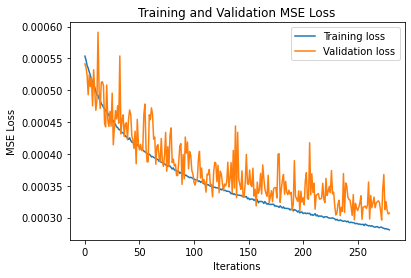

In [85]:
plt.plot(train_history[20:], label = 'Training loss')
plt.plot(val_history[20:], label = 'Validation loss')
plt.xlabel('Iterations')
plt.ylabel('MSE Loss')
plt.title('Training and Validation MSE Loss')
plt.legend()
plt.show()

In [ ]:
# b = torch.isnan(Y_train)
# torch.sum(b == True)

### Import Previously Trained Model

In [326]:
import_path = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Models\LSTM_4' + '\\' + 'Exp026-2022-02-11-LSTM-In72-Out12.pickle'
# import_path = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Models\CNN_1' + '\\' + 'Exp001-2022-01-24-CNN-In96-Out1.pickle'
# model_CNN = CNN(input_size, output_size=output_size, kernel_size=kernel_size, stride=1, in_seq_len=in_seq_len, out_seq_len=out_seq_len,  device = DEVICE).to(DEVICE)
model_LSTM = LSTM(input_size=input_size, in_seq_len=in_seq_len, out_seq_len=out_seq_len, output_size=output_size, device=DEVICE).to(DEVICE)
model_LSTM.load_state_dict(torch.load(import_path))
model_LSTM.eval()

LSTM(
  (lstm): LSTM(9, 128, num_layers=4, batch_first=True)
  (fc1): Linear(in_features=128, out_features=108, bias=True)
)

#### Load helper functions

In [86]:
def mse_loss(preds, targets, reduction = 'mean', format='torch'):

    
    if format == 'torch': #default option
        loss = 1/(preds.shape[0]*preds.shape[1]*preds.shape[2]) * torch.sum((targets - preds) ** 2)
        # print(f'divide shape: {preds.shape[0]*preds.shape[1]*preds.shape[2]}')
        # print(f'square sum: {torch.sum((targets - preds) ** 2)}')

        # std = torch.sqrt(torch.sum((((targets - preds) ** 2) - loss)**2) * (1/preds.shape[0]*preds.shape[1]*preds.shape[2]-1))
        std = torch.std()
        
        if reduction == 'sum':
            loss = torch.sum((targets - preds) ** 2)
    
    if format == 'np':
        loss = 1/(preds.shape[0]*preds.shape[1]*preds.shape[2]) * np.sum((targets - preds) ** 2)
        # print(f'divide shape: {preds.shape[0]*preds.shape[1]*preds.shape[2]}')
        # print(f'square sum: {torch.sum((targets - preds) ** 2)}')

        std = np.std(((targets - preds) ** 2).reshape(-1,1).squeeze())
        # print(np.sqrt(np.sum(((targets - preds) ** 2) - loss)**2))
        
        if reduction == 'sum':
            loss = np.sum((targets - preds) ** 2)

    return loss, std

In [87]:
#mae 
def mae_loss(preds, targets, reduction = 'mean', format='torch'):

    if format == 'torch': #default option
        loss = 1/(preds.shape[0]*preds.shape[1]*preds.shape[2]) * torch.sum(torch.abs(targets - preds))
        # print(f'divide shape: {preds.shape[0]*preds.shape[1]*preds.shape[2]}')
        # print(f'square sum: {torch.sum((targets - preds) ** 2)}')
        
        if reduction == 'sum':
            loss = torch.sum(torch.abs(targets - preds))
    
    if format == 'np':
        loss = 1/(preds.shape[0]*preds.shape[1]*preds.shape[2]) * np.sum(np.absolute(targets - preds))
        # print(f'divide shape: {preds.shape[0]*preds.shape[1]*preds.shape[2]}')
        # print(f'square sum: {torch.sum((targets - preds) ** 2)}')
        
        std = np.std(np.abs(targets - preds).reshape(-1,1).squeeze())

        if reduction == 'sum':
            loss = np.sum(np.absolute(targets - preds))

    return loss, std

In [88]:
# 2 ** 4
# a = np.array([[1,2,3], [2,1,2]])
# a ** 2

In [89]:
def rmse_loss(preds, targets, reduction = 'mean', format='torch'):

    
    if format == 'torch': #default option
        loss = torch.sqrt(1/(preds.shape[0]*preds.shape[1]*preds.shape[2]) * torch.sum((targets - preds) ** 2))
        # print(f'divide shape: {preds.shape[0]*preds.shape[1]*preds.shape[2]}')
        # print(f'square sum: {torch.sum((targets - preds) ** 2)}')
        
        if reduction == 'sum':
            loss = torch.sum((targets - preds) ** 2)
    
    if format == 'np':
        loss = np.sqrt(1/(preds.shape[0]*preds.shape[1]*preds.shape[2]) * np.sum((targets - preds) ** 2))
        # print(f'divide shape: {preds.shape[0]*preds.shape[1]*preds.shape[2]}')
        # print(f'square sum: {torch.sum((targets - preds) ** 2)}')

        std = np.std(((targets-preds) ** 2).reshape(-1,1).squeeze())
        std = ((targets-preds)- loss)

        if reduction == 'sum':
            loss = np.sum((targets - preds) ** 2)

    return loss, std

In [90]:
test_mse_loss, test_mse_std = mse_loss(predicted_test_denorm, actual_test_denorm, reduction='mean', format='np')
test_mae_loss, test_mae_std = mae_loss(predicted_test_denorm, actual_test_denorm, reduction='mean', format='np')
test_rmse_loss, test_rmse_std = rmse_loss(predicted_test_denorm, actual_test_denorm, reduction='mean', format='np')


print(f'Test MSE Loss: {test_mse_loss}')
print(f'Test MSE std: {test_mse_std} ')

print(f'Test sqrt MSE Loss: {np.sqrt(test_mse_loss)}')
print(f'Test sqrt MSE std: {np.sqrt(test_mse_std)} ')

print(f'Test RMSE Loss: {test_rmse_loss}')
print(f'Test RMSE std: {test_rmse_std} ')

NameError: name 'predicted_test_denorm' is not defined

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error 

In [ ]:
def calc_covariance(preds, targets, features):
    #preds shape (samples, window size, features)

    all_cov = []

    for f in range(len(features)):
        p = preds[:,:,f].reshape(-1,1) #reshaping predictions
        t = targets[:,:,f].reshape(-1,1) # reshaping targets

        pmean = np.mean(p) #calculating mean for predictions and targets 
        tmean= np.mean(t)

        cov_sum = 0 
        for i in range(len(p)):
            cov_sum += (p[i]-pmean) * (t[i]-tmean)
        
        all_cov.append(cov_sum/(len(p)-1))

    return all_cov 

In [91]:
# val_mse_loss, std_mse = mse_loss(predicted_val_denorm, actual_val_denorm, reduction='mean', format='np')
# val_mae_loss, std_mae = mae_loss(predicted_val_denorm, actual_val_denorm, reduction='mean', format='np')

# print(f'Val MSE Loss: {val_mse_loss}')
# print(f'Val MSE std: {std_mse}')
# print(f'MAE Loss: {val_mae_loss}')
# print(f'MAE std: {std_mae}')

In [92]:
# test_mse_loss, std_mse = mse_loss(predicted_test_denorm, actual_test_denorm, reduction='mean', format='np')
# test_mae_loss, std_mae = mae_loss(predicted_test_denorm, actual_test_denorm, reduction='mean', format='np')

# print(f'Test MSE Loss: {test_mse_loss}')
# print(f'Test MSE std: {std_mse}')
# print(f'MAE Loss: {test_mae_loss}')
# print(f'MAE std: {std_mae}')

In [93]:
# mse_diff = ((predicted_val_denorm[:,:,0] - actual_val_denorm[:,:,0]) ** 2).reshape(-1,1).squeeze()
# print(mse_diff.shape)

# print(f'mse loss for validation for feature 0: {np.sum(mse_diff)/mse_diff.shape[0]}')

# print(f'minimum loss: {mse_diff.min()}')
# print(f'maximum loss: {mse_diff.max()}')
# print(f'maximum loss corresponds to (angle): {np.sqrt(mse_diff.max())}')


# auto_mse_std = np.std(mse_diff)
# print(f'Automatic MSE std: {auto_mse_std}')

# manual_mse_std = np.sqrt((1/mse_diff.shape[0]) * np.sum((mse_diff-val_mse_loss) ** 2))
# print(f'Manual MSE std: {manual_mse_std}')

# plt.hist(mse_diff, bins=200, range=(0,25))

# mse_diff.shape[0]

In [94]:
mae_diff = (np.abs(predicted_test_denorm[:,:,:] - actual_test_denorm[:,:,:])).reshape(-1,1).squeeze()
print(f'mae_diff size: {mae_diff.shape[0]}') 

mae_diff_mean = np.sum(mae_diff)/mae_diff.shape[0] 
print(f'mae loss for validation for feature 0: {mae_diff_mean}')

print(f'minimum loss: {mae_diff.min()}')
print(f'maximum loss: {mae_diff.max()}')
print(f'maximum loss corresponds to (angle): {mae_diff.max()}')


auto_mae_std = np.std(mae_diff)
print(f'Automatic MAE std: {auto_mae_std}')

# manual_mae_std = np.sqrt((1/mae_diff.shape[0]) * np.sum((mae_diff-val_mae_loss) ** 2))
manual_mae_std = (1/mae_diff.shape[0]) * np.sum(np.abs(mae_diff-val_mae_loss))
print(f'Manual MAE std: {manual_mae_std}')

plt.hist(mae_diff, bins=200, range=(0,mae_diff.max()))

mae_diff.shape[0]

threshold = 2
larger_than_mean = np.where(mae_diff>threshold)
print(f'number of points larger than mean: {len(larger_than_mean[0])}')

print(f'threshold: {threshold}')
percentage = len(larger_than_mean[0])/mae_diff.shape[0] *100
print(f'percentage of values above the threshold: {percentage}')

NameError: name 'predicted_test_denorm' is not defined

In [95]:
# mae_diff = (np.abs(predicted_test_denorm[:,:,:] - actual_test_denorm[:,:,:]))
# print(f'mae_diff size: {mae_diff.shape}') 

# lcns = np.where(mae_diff < 0.5) #find locations where mae is bigger than threshold 

# lcns_index = list(zip(lcns[0], lcns[1], lcns[-1])) 

# unique_idx = np.unique([row[0] for row in lcns_index]) #find unique samples, removing duplicates

# print(f'number of outliers: {len(lcns_index)}')
# print(f'length of unique outliers: {len(unique_idx)}')


# print(lcns_index[1])
# mae_diff[176680:176682, :, 6]

# for s in range(len(unique_idx)):
#     i = unique_idx[s]
#     rng = 20
#     istart = i - rng

#     iend = i + rng

#     for f in range(len(features)):
#         plt.show()
#         plt.title('Index of Oultier: ' + str(i))
#         plt.plot(predicted_test_denorm[istart:iend, :, f].reshape(-1,1), label = 'predicted for feature: '+ str(f))
#         plt.plot(actual_test_denorm[istart:iend, :, f].reshape(-1,1), label = 'actual for feature: ' + str(f))
#         plt.vlines(rng * output_window, ymin=0, ymax=60, label = 'outlier', colors = 'r', linestyles='-.')
#         plt.legend()


In [96]:
# np.unique([row[0] for row in lcns_index])
# [row[0] for row in lcns_index]


In [97]:
# cov = calc_covariance(predicted_test_denorm, actual_test_denorm, features)
# cov

In [98]:
# abs_diff = np.abs(predicted_test_denorm[:,:,1] - actual_test_denorm[:,:,1])
# print(abs_diff.shape)

# print(abs_diff.min())
# print(abs_diff.max())


# m = np.where(abs_diff > 60)

# print(f'number of samples above this threshold: {len(m[0])}')
# abs_outliers= list(zip(m[0],m[1]))
# print(abs_outliers[0][0])
# print(abs_outliers[1])

# plt.hist(abs_diff.reshape(-1,1), range=(0,10), bins=50)

In [99]:
# random.choice(abs_outliers[0])

# len(abs_outliers)

In [100]:
# plt.plot(predicted_test_denorm[i[0][0]-20:i[0][0]+10,:,1].reshape(-1,1))
# plt.plot(actual_test_denorm[i[0][0]-20:i[0][0]+10,:,1].reshape(-1,1))

In [101]:
# outlier_samples = np.random.randint(0,high=len(abs_outliers),size=10)
# for sample in outlier_samples:
#     out = abs_outliers[sample][0] #choose the index of one outlier out of all outliers 
#     for f in range(len(features)):#
#         plt.show()
#         print(out)
#         plt.plot(predicted_test_denorm[out-80:out+80,:,f].reshape(-1,1), label = str(f) + ' predicted')
#         plt.plot(actual_test_denorm[out-80:out+80,:,f].reshape(-1,1), label = str(f) + ' actual')
#         plt.legend()

In [102]:
# abs_diff = np.abs(predicted_test_denorm[:,:,-1] - actual_test_denorm[:,:,-1])
# print(abs_diff.shape)

# print(abs_diff.min())
# print(abs_diff.max())


# m = np.where(abs_diff == abs_diff.max())

# i = list(zip(m[0],m[1]))
# print(i[0])
# print(i[1])

In [103]:
# for f in range(len(features)):
#     plt.plot(predicted_test_denorm[i[0][0]-10:i[0][0]+10,:,f].reshape(-1,1), label = str(f) + ' predicted')
#     plt.plot(actual_test_denorm[i[0][0]-10:i[0][0]+10,:,f].reshape(-1,1), label = str(f) + ' actual')
#     plt.legend()
#     plt.show()

In [104]:
# Function to plot angles
def plot_angles_but_cooler(pred,actual,feature):
    plt.figure(figsize=(10,20)) # for multiple plots
    # plt.figure(figsize=(8,4))
    for f in range(feature):
        plt.subplot(feature,1,f+1)  
        plt.title(features[f])        
        plt.plot(pred[f],label='predictions')
        plt.plot(actual[f],label='actual')
            # plt.show() #uncomment to show each individually 
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout()

In [105]:
def connect_arrays(data,features):
    output={}

    for f in range(features):
        #output window length 
        pred_len= data.shape[1] 
        # print(f'pred_length:{pred_len}')

        #number of samples 
        sample_numb= data.shape[0]
        # print(f'number of samples :{sample_numb}')

        L=pred_len*sample_numb 
        
        new_data= np.zeros(shape=(L,1))

        for j,p in enumerate(data[:,:,f]):
            new_data[j*pred_len:j*pred_len+pred_len,:]=p.reshape(-1,1)
        output[f]= new_data   

    return output

## Load ordered validation Data 

In [106]:
# # Creating validatin windows 
# # val_size 
# # for i in tqdm(range(val_size)):
# for i in tqdm(filtered_index_val):
#     # print(f'Validation file: {i}')
#     X_values, Y_values = window_generator(
#          val_data[i,:,:],
#          input_window=input_window, 
#          output_window=output_window, 
#         #  stride=input_window, 
#          stride=stride, 
#          features = features
#          )
  
#     end_idx = start_idx + X_values.shape[0]

#     # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')

#     X_val_windows[start_idx:end_idx, :, :] = X_values
#     Y_val_windows[start_idx:end_idx, :, :] = Y_values

#     start_idx = end_idx 
#     val_sample_sum += X_values.shape[0]

# # print(f"Completed storage of validation windows samples, which contains {X_val_data.shape[0]} samples")
# X_val_data = X_val_windows[:end_idx, :, :]
# Y_val_data= Y_val_windows[:end_idx, :, :]

# start_idx = 0 #setting start index to equal zero 
# test_sample_sum = 0


# print(f'shape of X_val_windows: {X_val_windows.shape}')
# print(f'shape of Y_val_windows: {Y_val_windows.shape}')

# print(f'shape of X_val_data: {X_val_data.shape}')
# print(f'shape of Y_val_data: {Y_val_data.shape}')

# print(f'val sample sum: {val_sample_sum}')

In [107]:
# # Normalising data (find scalars on training data and apply the same on val and testing data)
# X_val_norm = normalise_transform(X_val_data, scalars)
# Y_val_norm = normalise_transform(Y_val_data, scalars)

# X_val = torch.from_numpy(X_val_norm).float()
# Y_val = torch.from_numpy(Y_val_norm).float()

# print(f'X_val shape: {X_val.shape}')
# print(f'Y_val shape: {Y_val.shape}')


In [108]:
# val_dataset = gaitDataset(X_val, Y_val)
# # val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
# val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True)

# print(f"Val Dataset length: {len(val_dataset)}")

In [109]:
pred_val_output, actual_val_output, val_loss = test_MLP(model_MLP, val_dataloader)

predicted_values_val = pred_val_output.cpu().numpy()
actual_values_val = actual_val_output.cpu().numpy()

print(f'val loss: {val_loss}')
print(f'Shape of predicted values test: {predicted_values_val.shape}')
print(f'shape of actual values test: {actual_values_val.shape}')

predicted_val_denorm = denormalise(predicted_values_val, scalars)
actual_val_denorm = denormalise(actual_values_val, scalars)

print(f'Shape of predicted values test post denormalisation: {predicted_val_denorm.shape}')
print(f'shape of actual values test post denormalisation: {actual_val_denorm.shape}')

964it [00:01, 932.07it/s] 

val loss: 0.0003072407223998919
Shape of predicted values test: (30840, 12, 9)
shape of actual values test: (30840, 12, 9)
Shape of predicted values test post denormalisation: (30840, 12, 9)
shape of actual values test post denormalisation: (30840, 12, 9)


In [110]:
# # Reshape values to plot
# connected_preds=connect_arrays(predicted_val_denorm[1000:1050,:,:],len(features))
# connected_targets=connect_arrays(actual_val_denorm[1000:1050,:,:],len(features))

Timestep ranges:19145:19155
Timestep ranges:8419:8429


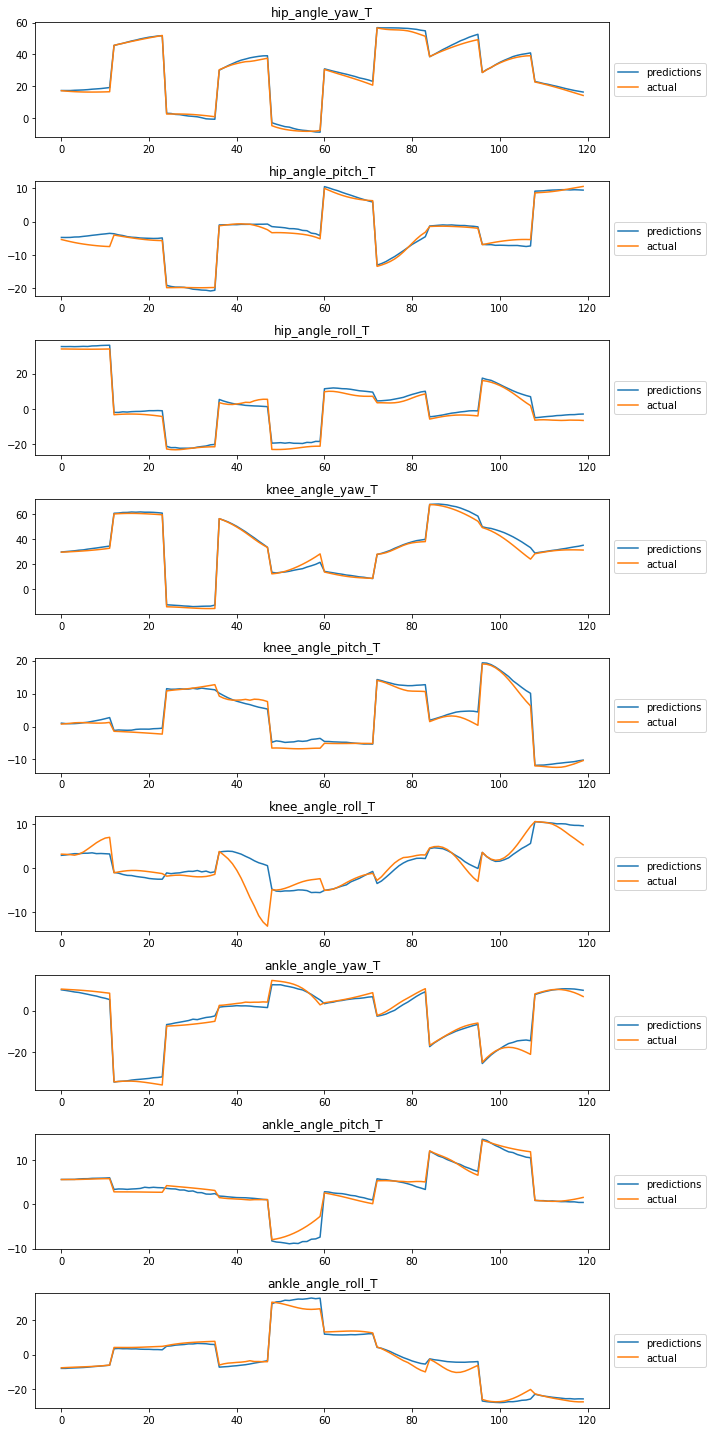

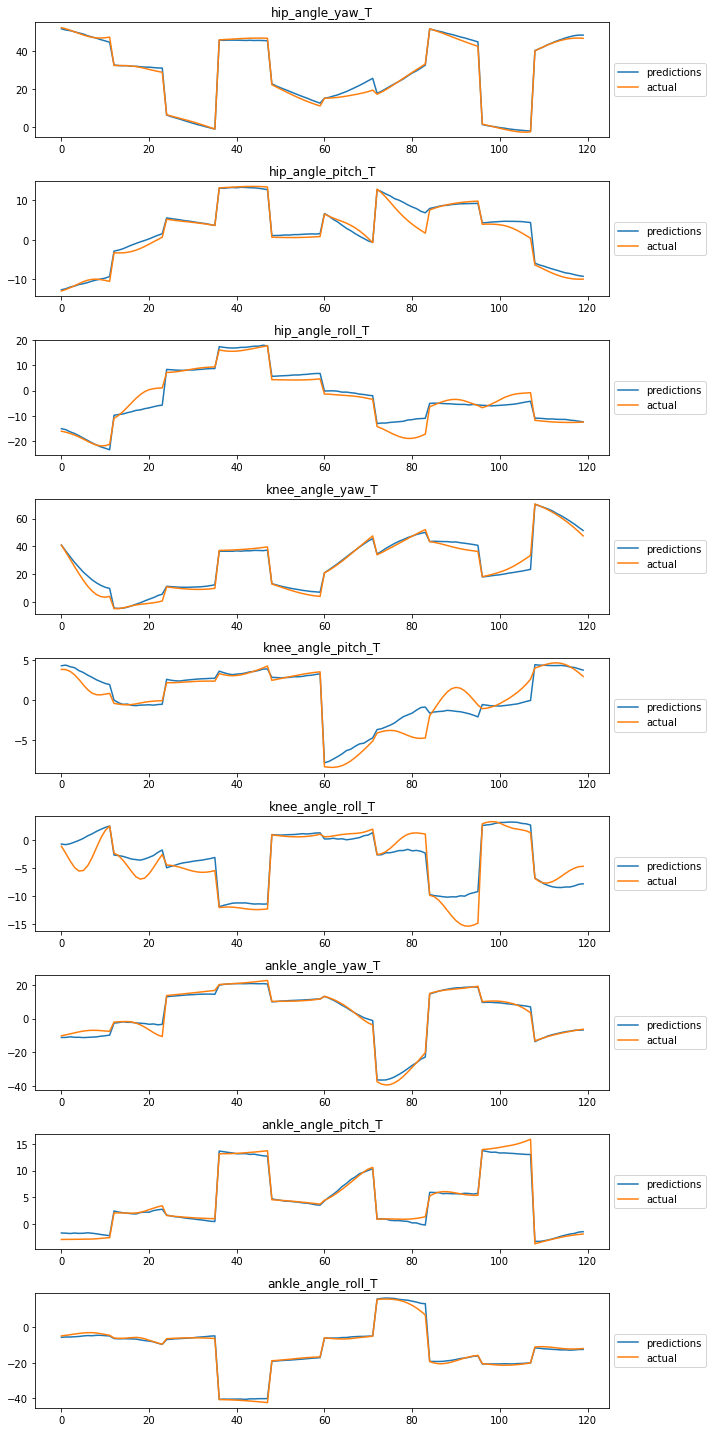

In [111]:
# Plot several random output examples
plt_width = 10 #number of time steps to plot
start_step = np.random.randint(0, high=(predicted_val_denorm.shape[0]-plt_width),size=2) #chooses random starting index to plot random samples

for i in start_step:
    print(f'Timestep ranges:{i}:{i+plt_width}')
    connected_preds=connect_arrays(predicted_val_denorm[i:i+plt_width,:,:],len(features))
    connected_targets=connect_arrays(actual_val_denorm[i:i+plt_width,:,:],len(features))
    plot_angles_but_cooler(connected_preds,connected_targets, len(features))

In [112]:
val_mse_loss, val_mse_std = mse_loss(predicted_val_denorm, actual_val_denorm, reduction='mean', format='np')
val_mae_loss, val_mae_std = mae_loss(predicted_val_denorm, actual_val_denorm, reduction='mean', format='np')

print(f'Val MSE Loss: {val_mse_loss}')
print(f'Val MSE std: {val_mse_std}')
print(f'Val MAE Loss: {val_mae_loss}')
print(f'Val MAE std: {val_mae_std}')



Val MSE Loss: 4.112495496469232
Val MSE std: 13.623051643371582
Val MAE Loss: 1.3128877539991353
Val MAE std: 1.5455812215805054


In [113]:
#Calculate the mse error for each of the features individually 
mae_feature_val = []
for f in range(len(features)):
    _ = mae_loss(np.expand_dims(predicted_val_denorm[:,:,f],-1), 
                    np.expand_dims(actual_val_denorm[:,:,f],-1), 
                    reduction='mean', 
                    format='np')
                    
    mae_feature_val.append(_)
    print(f'MAE loss for feature {f} corresponding to {features[f]} is: {mae_feature_val[f]}')

MAE loss for feature 0 corresponding to hip_angle_yaw_T is: (1.2374082968547342, 1.3361211)
MAE loss for feature 1 corresponding to hip_angle_pitch_T is: (0.9174423435473411, 0.93404734)
MAE loss for feature 2 corresponding to hip_angle_roll_T is: (1.9242675570146996, 1.7008394)
MAE loss for feature 3 corresponding to knee_angle_yaw_T is: (1.621679771941202, 1.924796)
MAE loss for feature 4 corresponding to knee_angle_pitch_T is: (0.936287508781885, 1.0624154)
MAE loss for feature 5 corresponding to knee_angle_roll_T is: (1.416244713980761, 1.5868979)
MAE loss for feature 6 corresponding to ankle_angle_yaw_T is: (1.5780660600410723, 2.0057027)
MAE loss for feature 7 corresponding to ankle_angle_pitch_T is: (0.7078463609219628, 0.8923474)
MAE loss for feature 8 corresponding to ankle_angle_roll_T is: (1.4767433730544748, 1.590904)


In [114]:
#Calculate the mse error for each of the features individually 
mse_feature_val = []
for f in range(len(features)):
    _ = mse_loss(np.expand_dims(predicted_val_denorm[:,:,f],-1), 
                    np.expand_dims(actual_val_denorm[:,:,f],-1), 
                    reduction='mean', 
                    format='np')
                    
    mse_feature_val.append(_)
    print(f'MSE loss for feature {f} corresponding to {features[f]} is: {mse_feature_val[f]}')

MSE loss for feature 0 corresponding to hip_angle_yaw_T is: (3.3163991569390405, 8.3347845)
MSE loss for feature 1 corresponding to hip_angle_pitch_T is: (1.7141450834954606, 4.257011)
MSE loss for feature 2 corresponding to hip_angle_roll_T is: (6.595661073281453, 14.473949)
MSE loss for feature 3 corresponding to knee_angle_yaw_T is: (6.334683717034155, 18.39556)
MSE loss for feature 4 corresponding to knee_angle_pitch_T is: (2.0053601586143537, 6.214074)
MSE loss for feature 5 corresponding to knee_angle_roll_T is: (4.523993460873325, 11.948511)
MSE loss for feature 6 corresponding to ankle_angle_yaw_T is: (6.513135673367921, 24.485003)
MSE loss for feature 7 corresponding to ankle_angle_pitch_T is: (1.297330391401859, 6.123518)
MSE loss for feature 8 corresponding to ankle_angle_roll_T is: (4.711746784479032, 13.426231)


In [115]:
# from scipy.signal import savgol_filter
# import scipy 

# # filtered = scipy.signal.medfilt(predicted_val_denorm[1:10,:,0].reshape(-1,1).squeeze(), kernel_size=81) #median filter
# filtered = scipy.signal.savgol_filter(predicted_val_denorm[4,:,0].reshape(-1,1).squeeze(), 3, polyorder=1) 



# # # yhat = savgol_filter(predicted_val_denorm[1:100,:,0].reshape(-1,1).squeeze(), 51, 3) 

# # connected_preds_filtered = 

# # plt.plot(yhat, label = 'filtered')
# # plt.plot(predicted_val_denorm[1:100,:,0].reshape(-1,1), label = 'unfiltered')
# # plt.legend()


# # apply a 3-pole lowpass filter at 0.1x Nyquist frequency
# # b, a = scipy.signal.butter(3, 0.1)
# # filtered = scipy.signal.filtfilt(b, a, connected_preds[0])
# # create a normalized Hanning window
# # windowSize = 10
# # window = np.hanning(windowSize)
# # window = window / window.sum()

# # # filter the data using convolution
# # filtered = np.convolve(window, predicted_val_denorm[1:10,:,0].reshape(1,-1), mode='valid')

# # predicted_val_denorm[1:20,:,0].reshape(1,-1)

# # predicted_val_denorm[1:10,:,0].reshape(-1,1).squeeze().shape

# for i in range(10):
#     filtered = scipy.signal.savgol_filter(predicted_val_denorm[i,:,0].reshape(-1,1).squeeze(), 20-1, polyorder=3) 
#     plt.plot(filtered.reshape(-1,1), label = 'filtered')
#     plt.plot(predicted_val_denorm[i,:,0].reshape(-1,1), label = 'original')
#     plt.legend()
#     plt.show()

In [116]:
# start_i = 10
# end_i = 20 #none inclusive 
# array_to_filter = predicted_val_denorm[start_i:end_i, :, :]
# filtered = np.zeros(array_to_filter.shape)

# for f in range(len(features)): #loop over features 
#     s = 0
#     for i in np.arange(start_i, end_i, 1): #loop over samples in predicted val array 
#         # print(i)
#         filtered[s, :, f] = scipy.signal.savgol_filter(predicted_val_denorm[i,:,f].reshape(-1,1).squeeze(), 9, polyorder=3) 
#         s += 1
    
#     # for i in range(10):
#     # filtered = scipy.signal.savgol_filter(predicted_val_denorm[i,:,0].reshape(-1,1).squeeze(), 20-1, polyorder=3) 
#     # plt.plot(filtered.reshape(-1,1), label = 'filtered')
#     # plt.plot(predicted_val_denorm[i,:,0].reshape(-1,1), label = 'original')
#     # plt.legend()
#     # plt.show()

# connected_preds=connect_arrays(filtered,len(features))
# # connected_preds=connect_arrays(predicted_val_denorm[start_i:end_i,:,:],len(features))
# connected_targets=connect_arrays(actual_val_denorm[start_i:end_i,:,:],len(features))

# # for i in range(10):
# #     plt.plot(connected_preds, label = 'filtered')
# #     plt.plot(connected_targets, label = 'original')
# #     plt.legend()
# #     plt.show()

# plot_angles_but_cooler(connected_preds,connected_targets,len(features))

In [117]:
# plt_width = 50
# start_step = np.random.randint(0, high=(predicted_val_denorm.shape[0]-plt_width),size=6) #chooses random starting index to plot random samples
# print(start_step)
# for i in start_step:
#     start_i = i
#     end_i = i+plt_width #none inclusive 
#     array_to_filter = predicted_val_denorm[start_i:end_i, :, :]
#     filtered = np.zeros(array_to_filter.shape)

#     for f in range(len(features)): #loop over features 
#         s = 0
#         for i in np.arange(start_i, end_i, 1): #loop over samples in predicted val array 
#             # print(i)
#             filtered[s, :, f] = scipy.signal.savgol_filter(predicted_val_denorm[i,:,f].reshape(-1,1).squeeze(), 19, polyorder= 2) 
#             s += 1

#     # connected_preds=connect_arrays(filtered,len(features))
#     connected_preds=connect_arrays(predicted_val_denorm[i:i+plt_width,:,:],len(features))
#     connected_targets=connect_arrays(actual_val_denorm[i:i+plt_width,:,:],len(features))
#     plot_angles_but_cooler(connected_preds,connected_targets, len(features))

In [118]:
# from scipy import signal

# predicted_val_denorm[i:i+plt_width,:,:].shape
# filtered = np.zeros(predicted_val_denorm[1:20,:,0].shape)
# # filtered = scipy.signal.savgol_filter(predicted_val_denorm[1:10,:,0].reshape(-1,1).squeeze(), 19, polyorder= 2) 
# f = signal.butter(3,30,'low',fs=120, output='sos')
# # filtered = signal.sosfilt(f,predicted_val_denorm[1:10,:,0].reshape(-1,1).squeeze()) 


# # kernel_size = 1
# # kernel = np.ones(kernel_size) / kernel_size
# # data_convolved_20 = np.convolve(data, kernel, mode='same')

# s=0
# for i in np.arange(1,20,1):
#     filtered[s,:] = signal.sosfilt(f,predicted_val_denorm[i,:,0].reshape(-1,1).squeeze()) 
#     s +=1
# #     # filtered[s,:] = scipy.ndimage.uniform_filter1d(predicted_val_denorm[i,:,0],size=100)
# #     # filtered[s,:] = scipy.signal.savgol_filter(predicted_val_denorm[i,:,0],output_window-1, polyorder= 2,deriv=0)
# #     # filtered[s,:] = np.convolve(predicted_val_denorm[i,:,0], kernel, mode='same')
# #     # filtered[s,:] = scipy.ndimage.mean(predicted_val_denorm[i,:,0], 20)
# #     filtered[s,:] = scipy.ndimage.gaussian_filter1d(predicted_val_denorm[i,:,0],6)
# #     s +=1 


# # # scipy.signal.savgol_filter(predicted_val_denorm[i,:,f].reshape(-1,1).squeeze(), 19, polyorder= 2) 

# plt.plot(filtered.reshape(-1,1).squeeze(), label ='filtered preds')
# plt.plot(predicted_val_denorm[1:20,:,0].reshape(-1,1).squeeze(), label = 'preds')
# # plt.plot(actual_val_denorm[1:20,:,0].reshape(-1,1).squeeze(), label='actual')
# plt.legend()

# # plt.plot(predicted_val_denorm[1:10,:,0].reshape(-1,1).squeeze(), label='original')
# # plt.plot(filtered, label='filtered')
# # plt.legend()



### Load testing data

In [119]:
fname= r'C:\Users\Rania\rbk9\Gillette Data' + '\\' + 'test_data.pickle'

with open(fname, 'rb') as handle:
    test_data = pickle.load(handle)
        

test_size = test_data.shape[0]

print(f"Shape of test data is: {test_data.shape}")
print(f"test_size: {test_size}")

Shape of test data is: (1602, 3000, 102)
test_size: 1602


In [120]:
# Filtering the test set from outliers 
features_included = ['hip_angle_yaw_T', 'hip_angle_pitch_T', 'hip_angle_roll_T', 
                    'knee_angle_yaw_T', 'knee_angle_pitch_T','knee_angle_roll_T', 
                    'ankle_angle_yaw_T', 'ankle_angle_pitch_T','ankle_angle_roll_T']

all_outliers_multifeature_test = np.array([])

for f in features_included:
    out = find_outliers(test_data, f, min=-90, max=90) #find the outliers for that feature 
    all_outliers_multifeature_test = np.append(all_outliers_multifeature_test, out)

print(f'Shape of all outliers: {all_outliers_multifeature_test.shape}')

all_outliers_unique_test = np.unique(all_outliers_multifeature_test).astype(int)

print(f'Shape of all unqiue outliers: {all_outliers_unique_test.shape}')

Shape of all outliers for hip_angle_yaw_T with index 0: (34,)
Shape of all outliers for hip_angle_pitch_T with index 1: (6,)
Shape of all outliers for hip_angle_roll_T with index 2: (34,)
Shape of all outliers for knee_angle_yaw_T with index 3: (40,)
Shape of all outliers for knee_angle_pitch_T with index 4: (6,)
Shape of all outliers for knee_angle_roll_T with index 5: (34,)
Shape of all outliers for ankle_angle_yaw_T with index 6: (20,)
Shape of all outliers for ankle_angle_pitch_T with index 7: (6,)
Shape of all outliers for ankle_angle_roll_T with index 8: (2,)
Shape of all outliers: (182,)
Shape of all unqiue outliers: (98,)


In [121]:
# Find the indices of the variables that will be included
all_index_test = np.arange(start=0,stop=test_data.shape[0], step=1, dtype=int)
filtered_index_test = np.delete(all_index_test, all_outliers_unique_test)

print(f'Shape of all outliers in test set; {all_outliers_unique_test.shape}')
print(f'Shape of original test set: {all_index_test.shape}')
print(f'Shape of filtered test set: {filtered_index_test.shape}')

Shape of all outliers in test set; (98,)
Shape of original test set: (1602,)
Shape of filtered test set: (1504,)


#### Create testing window samples

In [122]:
test_stride = stride
# test_stride = input_window
# test_stride = stride
approx_seq_len = 3000 # approximate the length of the longest sequence that can be encountered 
# samples_per_file = ((approx_seq_len - (input_window+output_window)) // test_stride) + 1 #number of window samples generated per file 
samples_per_file = 10

# create a zero-filled 3D array with shape (number of samples * number of files, window size, number of features)

X_test_windows = np.zeros((test_size*samples_per_file, input_window, len(features)), dtype=np.float32)
Y_test_windows = np.zeros((test_size*samples_per_file, output_window, len(features)), dtype=np.float32)

start_idx = 0 #setting start index to equal zero 
test_sample_sum = 0
test_excluded_samples = []

# Create training windows 
# for i in tqdm(range(test_size)): #use for unfiltered dataset 
for i in filtered_index_test:
    try:
        X_values, Y_values = window_generator(
            test_data[i,:,:],
            input_window=input_window, 
            output_window=output_window, 
            stride=test_stride, 
            features=features
            )
    
        end_idx = start_idx + X_values.shape[0]

        # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')

        X_test_windows[start_idx:end_idx, :, :] = X_values
        Y_test_windows[start_idx:end_idx, :, :] = Y_values

        # print(f'number of samples copied: {X_train_data_store[start_idx:end_idx, :, :].shape[0]}')

        start_idx = end_idx 
        test_sample_sum += X_values.shape[0]

    except Exception:
        exception_msg(i)
        test_excluded_samples.append(i)

# print(f"Completed storage of training windows samples, which contains {X_train_data_store.shape[0]} samples")
X_test_data = X_test_windows[:end_idx, :, :]
Y_test_data = Y_test_windows[:end_idx, :, :]


print(f'shape of X_test_windows: {X_test_windows.shape}')
print(f'shape of Y_test_windows: {Y_test_windows.shape}')

print(f'shape of X_test_data: {X_test_data.shape}')
print(f'shape of Y_test_data: {Y_test_data.shape}')

print(f'test sample sum: {test_sample_sum}')

Exception: The sample exluded has index:830
Exception: The sample exluded has index:1062
Exception: The sample exluded has index:1396
shape of X_test_windows: (16020, 72, 9)
shape of Y_test_windows: (16020, 12, 9)
shape of X_test_data: (15010, 72, 9)
shape of Y_test_data: (15010, 12, 9)
test sample sum: 15010


#### Normalise testing data

In [123]:
X_test_norm = normalise_transform(X_test_data, scalars)
Y_test_norm = normalise_transform(Y_test_data, scalars)

# Convert to Tensor 
# do not store on GPU (yet)
X_test = torch.from_numpy(X_test_norm).float()
Y_test = torch.from_numpy(Y_test_norm).float()

print(f'X_test shape: {X_test.shape}')
print(f'Y_test shape: {Y_test.shape}')

X_test shape: torch.Size([15010, 72, 9])
Y_test shape: torch.Size([15010, 12, 9])


In [124]:
# a = Y_test[20:50,:,0].reshape(-1,1).cpu().numpy()
# plt.plot(a)
# plt.vlines(np.arange(0,500, output_window), ymin=0, ymax=1)

# X_test[20:25,:,0].shape

In [125]:
test_dataset = gaitDataset(X_test, Y_test)
# # test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False) #ADJUSTED

print(f"Test Dataset length: {len(test_dataset)}")

Test Dataset length: 15010


### Evaluate on Testing Set

#### Calculate predictions on testing set

In [126]:
pred_test_output, actual_test_output, test_loss = test_MLP(model_MLP, test_dataloader)

predicted_values_test = pred_test_output.cpu().numpy() # premute again to make the order of the array (samples, windows, features)
actual_values_test =  actual_test_output.cpu().numpy()

print(f'test loss: {test_loss}')

print(f'Shape of predicted values test: {predicted_values_test.shape}')
print(f'shape of actual values test: {actual_values_test.shape}')

predicted_test_denorm = denormalise(predicted_values_test, scalars)
actual_test_denorm =  denormalise(actual_values_test, scalars)

print(f'Shape of predicted values test post denormalisation: {predicted_test_denorm.shape}')
print(f'shape of actual values test post denormalisation: {actual_test_denorm.shape}')

470it [00:00, 693.62it/s]


test loss: 0.00039947582831410594
Shape of predicted values test: (15010, 12, 9)
shape of actual values test: (15010, 12, 9)
Shape of predicted values test post denormalisation: (15010, 12, 9)
shape of actual values test post denormalisation: (15010, 12, 9)


In [127]:
# s=10
# for f in range(len(features)):
#     x = np.arange(0,input_window+output_window)
#     plt.plot(x[:120],X_test[s,:,f].reshape(-1,1), label='X_test')
#     plt.plot(x[120:],Y_test[s,:,f].reshape(-1,1), label='Y_test')
#     plt.plot(x[120:],predicted_values_test[s,:,f].reshape(-1,1), label='predicted_values_test')
#     plt.plot(x[120:],actual_values_test[s,:,f].reshape(-1,1), label='actual_values_test')
#     plt.legend()
#     plt.show()
    

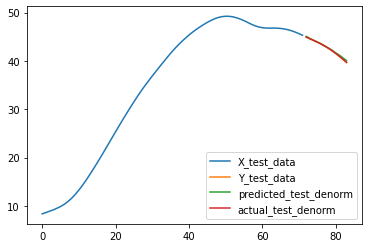

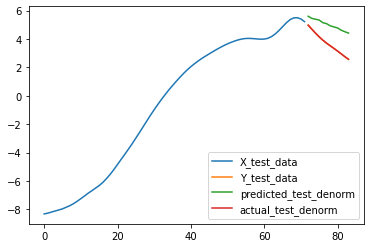

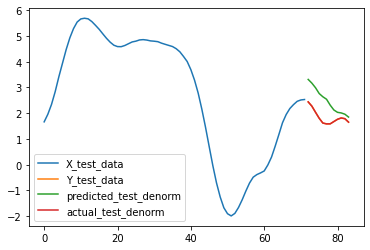

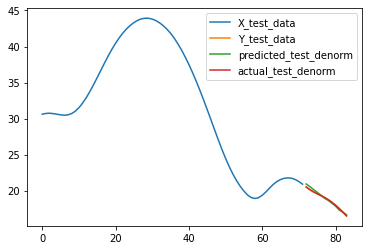

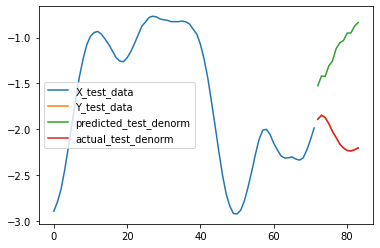

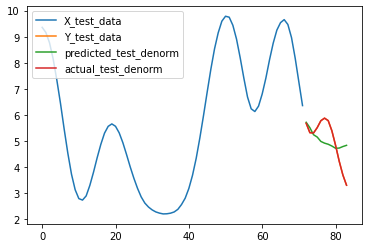

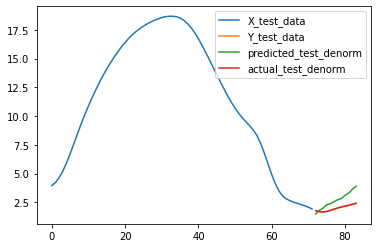

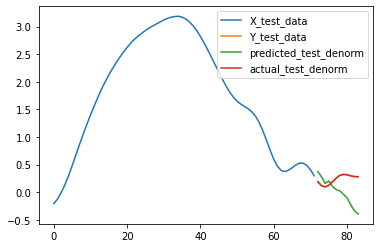

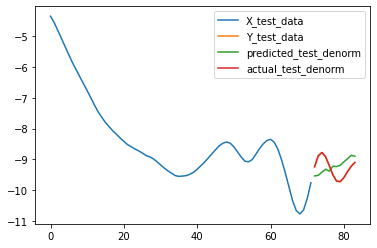

In [128]:
s=201
for f in range(len(features)):
    x = np.arange(0,input_window+output_window)
    plt.plot(x[:input_window],X_test_data[s,:,f].reshape(-1,1), label='X_test_data')
    plt.plot(x[input_window:],Y_test_data[s,:,f].reshape(-1,1), label='Y_test_data')
    plt.plot(x[input_window:],predicted_test_denorm[s,:,f].reshape(-1,1), label='predicted_test_denorm')
    plt.plot(x[input_window:], actual_test_denorm[s,:,f].reshape(-1,1), label='actual_test_denorm')
    plt.legend()
    plt.show()

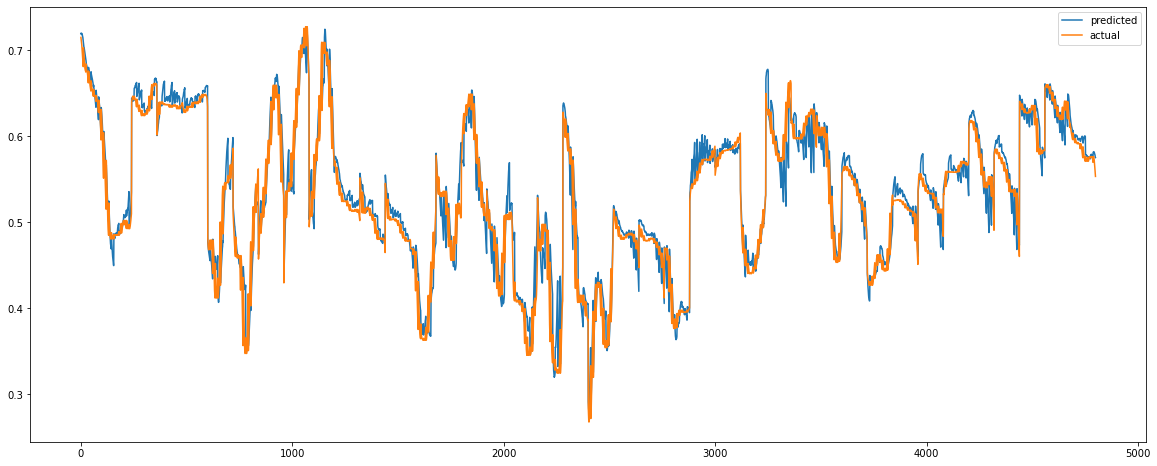

In [129]:
plt.figure(figsize=(20,8))
plt.plot(predicted_values_test[100:500,:,1].reshape(-1,1), label = 'predicted')
plt.plot(actual_values_test[100:500,:,1].reshape(-1,1), label = 'actual')
plt.legend()


In [130]:
test_mse_loss, test_mse_std = mse_loss(predicted_test_denorm, actual_test_denorm, reduction='mean', format='np')
test_mae_loss, test_mae_std = mae_loss(predicted_test_denorm, actual_test_denorm, reduction='mean', format='np')

print(f'Test MSE Loss: {test_mse_loss}')
print(f'Test MSE std: {test_mse_std} ')
print(f'Test MAE Loss: {test_mae_loss}')
print(f'Test MAE std: {test_mae_std}')

Test MSE Loss: 5.326824709452957
Test MSE std: 18.916025161743164 
Test MAE Loss: 1.4478023909985935
Test MAE std: 1.797412395477295


In [131]:
mae_loss(np.expand_dims(predicted_test_denorm[:,:,2],-1), 
                    np.expand_dims(actual_test_denorm[:,:,8],-1), 
                    reduction='mean', 
                    format='np')

(17.52747196313569, 13.952992)

In [132]:
#Calculate the mse error for each of the features individually 
mae_feature_test = []
for f in range(len(features)):
    _ = mae_loss(np.expand_dims(predicted_test_denorm[:,:,f],-1), 
                    np.expand_dims(actual_test_denorm[:,:,f],-1), 
                    reduction='mean', 
                    format='np')
                    
    mae_feature_test.append(_)
    print(f'MAE loss for feature {f} corresponding to {features[f]} is: {mae_feature_test[f]}')

MAE loss for feature 0 corresponding to hip_angle_yaw_T is: (1.3086049404563624, 1.4600295)
MAE loss for feature 1 corresponding to hip_angle_pitch_T is: (0.9867116366866534, 1.0307869)
MAE loss for feature 2 corresponding to hip_angle_roll_T is: (2.1047926382411726, 2.0160918)
MAE loss for feature 3 corresponding to knee_angle_yaw_T is: (1.824400399733511, 2.2324271)
MAE loss for feature 4 corresponding to knee_angle_pitch_T is: (1.025338576365756, 1.2233186)
MAE loss for feature 5 corresponding to knee_angle_roll_T is: (1.6229223920164335, 1.9429082)
MAE loss for feature 6 corresponding to ankle_angle_yaw_T is: (1.7143354083388853, 2.1935925)
MAE loss for feature 7 corresponding to ankle_angle_pitch_T is: (0.8209543464079503, 1.3273212)
MAE loss for feature 8 corresponding to ankle_angle_roll_T is: (1.622159012047524, 1.8653879)


In [133]:
b = np.array([item[0] for item in mae_feature_test])

np.mean(b)

1.447802150032694

In [134]:
#Calculate the mse error for each of the features individually 
mse_feature_test = []
for f in range(len(features)):
    _ = mse_loss(np.expand_dims(predicted_test_denorm[:,:,f],-1), 
                    np.expand_dims(actual_test_denorm[:,:,f],-1), 
                    reduction='mean', 
                    format='np')
                    
    mse_feature_test.append(_)
    print(f'MSE loss for feature {f} corresponding to {features[f]} is: {mse_feature_test[f]}')

MSE loss for feature 0 corresponding to hip_angle_yaw_T is: (3.8441330779480345, 10.709725)
MSE loss for feature 1 corresponding to hip_angle_pitch_T is: (2.0361214051743284, 5.029176)
MSE loss for feature 2 corresponding to hip_angle_roll_T is: (8.494779174994449, 20.802338)
MSE loss for feature 3 corresponding to knee_angle_yaw_T is: (8.312168970686209, 24.737469)
MSE loss for feature 4 corresponding to knee_angle_pitch_T is: (2.5478276635021095, 8.194496)
MSE loss for feature 5 corresponding to knee_angle_roll_T is: (6.408769847879192, 19.526693)
MSE loss for feature 6 corresponding to ankle_angle_yaw_T is: (7.750792527204086, 26.521301)
MSE loss for feature 7 corresponding to ankle_angle_pitch_T is: (2.43574752248501, 20.953707)
MSE loss for feature 8 corresponding to ankle_angle_roll_T is: (6.111072479458139, 19.72503)


In [135]:
## investigate location of error 
predicted_test_denorm[:,:,1] - actual_test_denorm[:,:,2]

array([[ 16.028439  ,  16.798328  ,  17.2477    , ...,  15.764957  ,
         15.833458  ,  16.114773  ],
       [ 18.645275  ,  18.415     ,  18.098125  , ...,  20.856365  ,
         21.457214  ,  21.7858    ],
       [ 19.416126  ,  20.057571  ,  20.843746  , ...,  23.330933  ,
         22.570599  ,  21.746006  ],
       ...,
       [-17.414265  , -16.600279  , -15.5990925 , ...,  -4.747776  ,
         -3.4865112 ,  -2.5789375 ],
       [-11.150433  ,  -9.498825  ,  -7.825121  , ...,  -0.66106415,
         -0.67499924,  -1.0874443 ],
       [ -2.9061012 ,  -1.7456512 ,  -0.77716446, ...,  -2.948429  ,
         -4.5358734 ,  -6.357704  ]], dtype=float32)

### Naive benchmark

In [136]:
## benchmark against naive output (making predictino only last value)


naive_1_test_output = np.zeros(Y_test_data.shape)

for f in range(len(features)):
    for s in range(Y_test_data.shape[0]):
        naive_1_test_output[s,:,f] = np.ones((output_window)) * X_test_data[s,-1,f]



print(naive_1_test_output.shape)


naive_1_test_output[1,:,1]

# X_test_data[1,:,1]



(15010, 12, 9)


array([7.07630157, 7.07630157, 7.07630157, 7.07630157, 7.07630157,
       7.07630157, 7.07630157, 7.07630157, 7.07630157, 7.07630157,
       7.07630157, 7.07630157])

In [137]:
naive_1_mse_loss, naive_1_mse_std = mse_loss(naive_1_test_output, Y_test_data, reduction='mean', format='np')
naive_1_mae_loss, naive_1_mae_std = mae_loss(naive_1_test_output, Y_test_data, reduction='mean', format='np')

print(f'naive_1 MSE Loss: {naive_1_mse_loss}')
print(f'naive_1 MSE std: {naive_1_mse_std} ')
print(f'naive_1 MAE Loss: {naive_1_mae_loss}')
print(f'naive_1 MAE std: {naive_1_mae_std}')

naive_1 MSE Loss: 21.187903995683158
naive_1 MSE std: 75.47200605169499 
naive_1 MAE Loss: 2.647729884584111
naive_1 MAE std: 3.765292877581154


### Standard deviation and Standard Error

calclated_mae: 1.4478024244308472
calculated std: 1.797412395477295


100%|██████████| 100/100 [00:02<00:00, 39.53it/s]


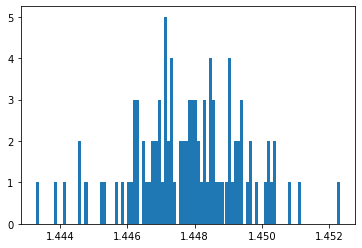

100


In [138]:
###trying bootstraping 
diff = np.abs(predicted_test_denorm - actual_test_denorm).reshape(-1,1).squeeze()

calculated_mae = diff.mean()
print(f'calclated_mae: {calculated_mae}')
print(f'calculated std: {diff.std()}')
# scipy.stats.bootstrap(diff, np.std, n_resamples=2)

num_bootstrap = 100
boot_means = []
for _ in tqdm(range(num_bootstrap)):
    bootsample = np.random.choice(diff,size=diff.shape, replace=True)
    boot_means.append(bootsample.mean())

boot_means_array = np.array(boot_means)


# boot_means_array.std()

plt.hist(boot_means_array, bins=100)
plt.show()
print(num_bootstrap)

In [139]:
boot_means_array.mean()
print(f'bootstrap mean: {boot_means_array.mean()}')

print(f'bootstrap std = standard error: {boot_means_array.std()}')
lower_quantile = np.quantile(boot_means_array, .025)
print(f'lower_quartile: {lower_quantile}')

upper_quantile = np.quantile(boot_means_array, .975)
print(f'upper_quartile: {upper_quantile}')

bootstrap mean: 1.4478012323379517
bootstrap std = standard error: 0.0016177876386791468
lower_quartile: 1.4443677067756653
upper_quartile: 1.4506342858076096


<BarContainer object of 2 artists>

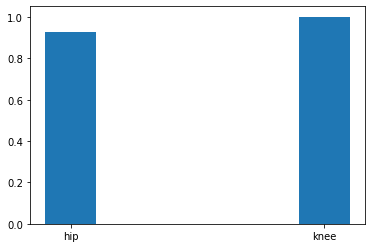

In [308]:
x = ['hip', 'knee']
mean = [0.9272330403327942, 1]
error = [[ 0.001, 0.001], [  0.001,0.001]]

plt.bar(x=x, height=mean, yerr=error, width=0.2)

diff_normal.mean() : 0.3096451759338379
diff_normal.std() : 2.2871253490448


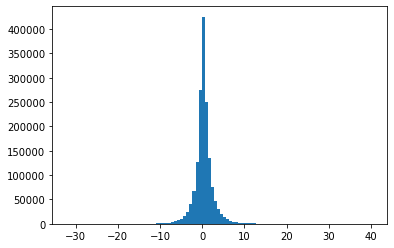

diff_folded.mean() : 1.4478024244308472
diff_folded.std() : 1.797412395477295


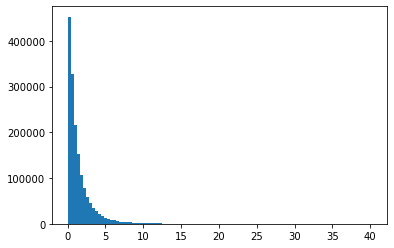

In [140]:
diff_normal = (predicted_test_denorm - actual_test_denorm).reshape(-1,1).squeeze()
print(f'diff_normal.mean() : {diff_normal.mean()}')
print(f'diff_normal.std() : {diff_normal.std()}')

mean_normal = diff_normal.mean()
std_normal = diff_normal.std()

plt.hist(diff_normal, bins=100)
plt.show()

diff_folded = np.abs(predicted_test_denorm - actual_test_denorm).reshape(-1,1).squeeze()
print(f'diff_folded.mean() : {diff_folded.mean()}')
print(f'diff_folded.std() : {diff_folded.std()}')

mean_folded = diff_folded.mean()
std_folded = diff_folded.std()

plt.hist(diff_folded, bins=100)
plt.show()

In [141]:
mean = [0.927]
error = []

In [142]:
len(diff)

1621080

In [143]:
diff.std() * np.sqrt(2/np.pi)

1.4341275997470277

In [313]:
np.sqrt(2/np.pi)

0.7978845608028654

In [314]:
diff.mean() + (diff.std() * np.sqrt(2/np.pi))

2.8505910180186156

diff_normal.mean() : 0.13243310153484344
diff_normal.std() : 2.27765154838562


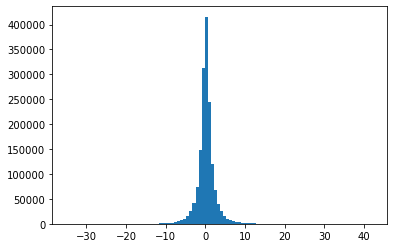

diff_folded.mean() : 1.4360833168029785
diff_folded.std() : 1.7728224992752075


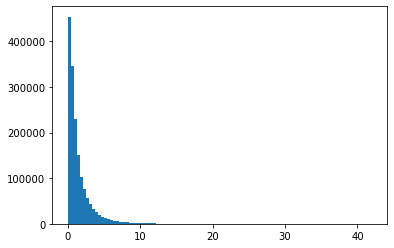

In [315]:
diff_normal = (predicted_test_denorm - actual_test_denorm).reshape(-1,1).squeeze()
print(f'diff_normal.mean() : {diff_normal.mean()}')
print(f'diff_normal.std() : {diff_normal.std()}')

mean_normal = diff_normal.mean()
std_normal = diff_normal.std()

plt.hist(diff_normal, bins=100)
plt.show()

diff_folded = np.abs(predicted_test_denorm - actual_test_denorm).reshape(-1,1).squeeze()
print(f'diff_folded.mean() : {diff_folded.mean()}')
print(f'diff_folded.std() : {diff_folded.std()}')

mean_folded = diff_folded.mean()
std_folded = diff_folded.std()

plt.hist(diff_folded, bins=100)
plt.show()

In [316]:
std_folded_calc = np.sqrt((mean_normal **2 )+ (std_normal ** 2) - (mean_folded**2))
std_folded_calc

1.7728225544158973

In [317]:
2 ** 2


4

In [144]:
from scipy import special
from scipy import stats
#normal cumilative distribution function https://en.wikipedia.org/wiki/Folded_normal_distribution
ncdf = special.erf((-mean_normal/std_normal)/np.sqrt(2))


mean_folded_calc_equ = std_normal * np.sqrt(2/np.pi) * np.exp((-mean_normal**2)/(2*std_normal**2)) + ( mean_normal * (1- (2*ncdf) ) )
mean_folded_calc_equ

2.1845527697777802

In [319]:
std_folded_calc = np.sqrt((mean_normal **2 )+ (std_normal ** 2) - (mean_folded_calc_equ**2))
std_folded_calc

1.1695123488081618

### Calculating T-test

In [145]:
## benchmark against mean output
# naive_test_output = X_test_data[:,(input_window-output_window):,:]
# naive_test_output.shape

naive_average_test_output = np.zeros(Y_test_data.shape)

for f in range(len(features)):
    for s in range(Y_test_data.shape[0]):
        naive_average_test_output[s,:,f] = np.ones((output_window)) * np.mean(X_test_data[s,:,f])



print(naive_average_test_output.shape)



(15010, 12, 9)


In [146]:
naive_average_mse_loss, naive_average_mse_std = mse_loss(naive_average_test_output, Y_test_data, reduction='mean', format='np')
naive_average_mae_loss, naive_average_mae_std = mae_loss(naive_average_test_output, Y_test_data, reduction='mean', format='np')

print(f'average MSE Loss: {naive_average_mse_loss}')
print(f'average MSE std: {naive_average_mse_std} ')
print(f'average MAE Loss: {naive_average_mae_loss}')
print(f'average MAE std: {naive_average_mae_std}')

average MSE Loss: 120.01491491442515
average MSE std: 278.8369714418378 
average MAE Loss: 7.2597731477924805
average MAE std: 8.204304282327442


In [148]:
naive_1_array = np.array(naive_1_test_output)

naive_1_diff = np.abs(naive_1_array - Y_test_data).reshape(-1,1).squeeze()




In [149]:
naive_vrg_array = np.array(naive_average_test_output)

naive_avrg = np.abs(naive_average_test_output-Y_test_data).reshape(-1,1).squeeze()

naive_avrg.shape

(1621080,)

In [168]:
naive_avrg_edited = naive_avrg.copy()
naive_avrg_edited[:1000] = naive_avrg[:1000] + 100000

# print(stats.ttest_rel(naive_avrg, naive_diff))
# new.shape

# print(stats.ttest_rel(naive_avrg, naive_avrg_edited))

print(stats.ttest_rel(naive_avrg, naive_avrg_edited, axis=0))

naive_avrg

print(naive_avrg.mean())

print(naive_avrg_edited.mean())

print(naive_avrg_edited.mean()-naive_avrg.mean())
100/1000000

naive_avrg.shape

Ttest_relResult(statistic=-31.632524973759025, pvalue=1.5395598049108295e-219)
7.2597731477924805
68.94704336271093
61.68727021491845


(1621080,)

In [171]:
naive_avrg_edited[:1] = naive_avrg[:1] + 10
diff_ttest = naive_avrg - naive_avrg_edited
print(f'mean: {diff_ttest.mean()}')
print(f'std: {diff_ttest.std()}')
print(diff_ttest.shape[0])
print(diff_ttest.std()/np.sqrt(diff_ttest.shape[0]))
print(f't VALUE statistic:{diff_ttest.mean() / (diff_ttest.std()/np.sqrt(diff_ttest.shape[0]))}')


mean: 0.0
std: 0.0
1621080
0.0
t VALUE statistic:nan


C:\Users\Rania\AppData\Local\Temp/ipykernel_18780/1303244280.py:7: RuntimeWarning: invalid value encountered in double_scalars
  print(f't VALUE statistic:{diff_ttest.mean() / (diff_ttest.std()/np.sqrt(diff_ttest.shape[0]))}')


In [325]:
from scipy import stats

x = np.array([1,1,1,1,1,1,1,-1])
y = np.array([1,1,1,1,2,2,2,2])
# b = a + 0.01
# b = [1.2,1.1,1.1,1,1,1,1,-1]
# b=[2,2,2,2,2,2,2,2,]

stats.ttest_rel(x,y)

Ttest_relResult(statistic=-2.0493901531919194, pvalue=0.07960201245519757)

#### Performance on test set plots

In [326]:
connected_preds=connect_arrays(predicted_test_denorm[100:200,:,:],len(features))
connected_targets=connect_arrays(actual_test_denorm[100:200,:,:],len(features))

In [327]:
# diff = predicted_test_denorm - actual_test_denorm
# for f in range(len(features)):
#     plt.figure(figsize=(20,10))
#     plt.hist(diff[:,:,f].reshape(-1,1), bins = 40, range = (-7.5,7.5))
#     # plt.hist(diff[:,:,f].reshape(-1,1), bins = 20)
#     plt.show()

# diff.min()
# diff.max()



#### Training and validating LSTM

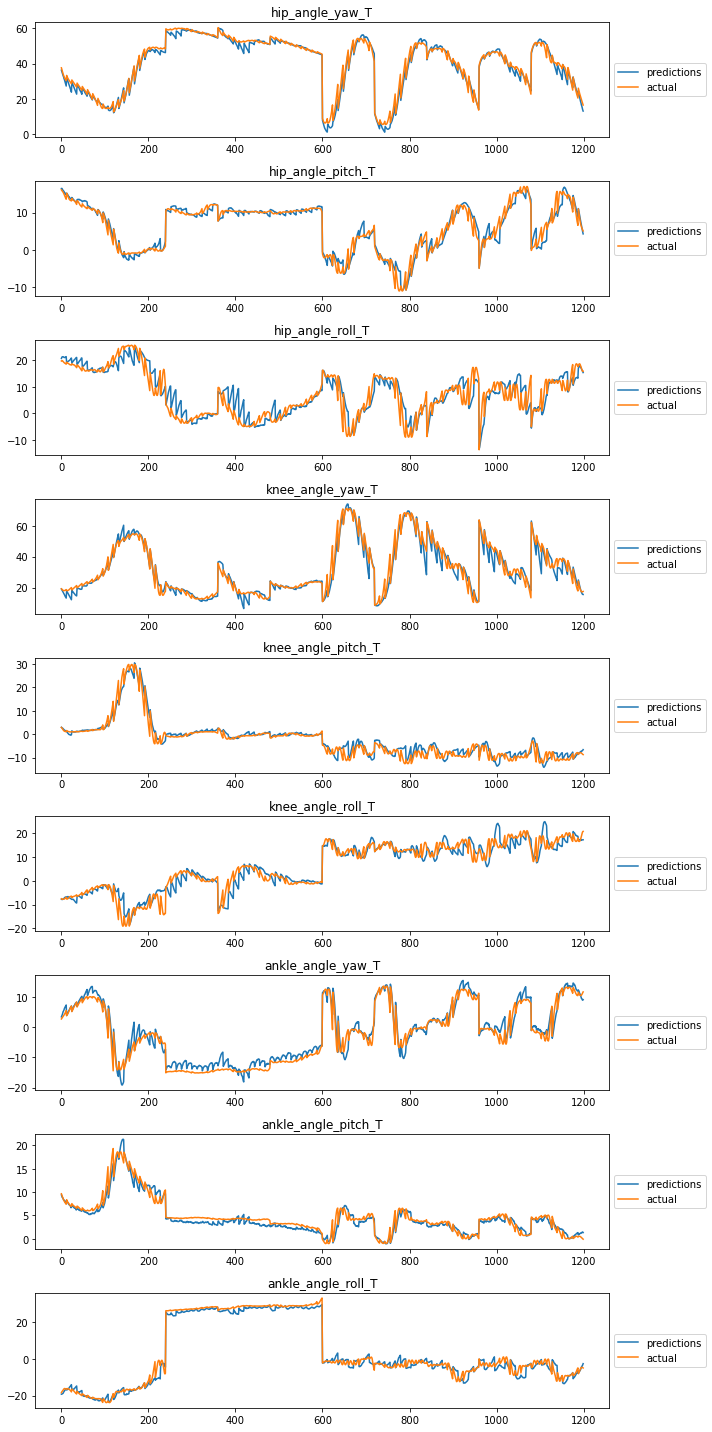

In [328]:
plot_angles_but_cooler(connected_preds,connected_targets,len(features))

Timestep ranges:440:460
Timestep ranges:3118:3138
Timestep ranges:2841:2861
Timestep ranges:11868:11888
Timestep ranges:14897:14917
Timestep ranges:915:935


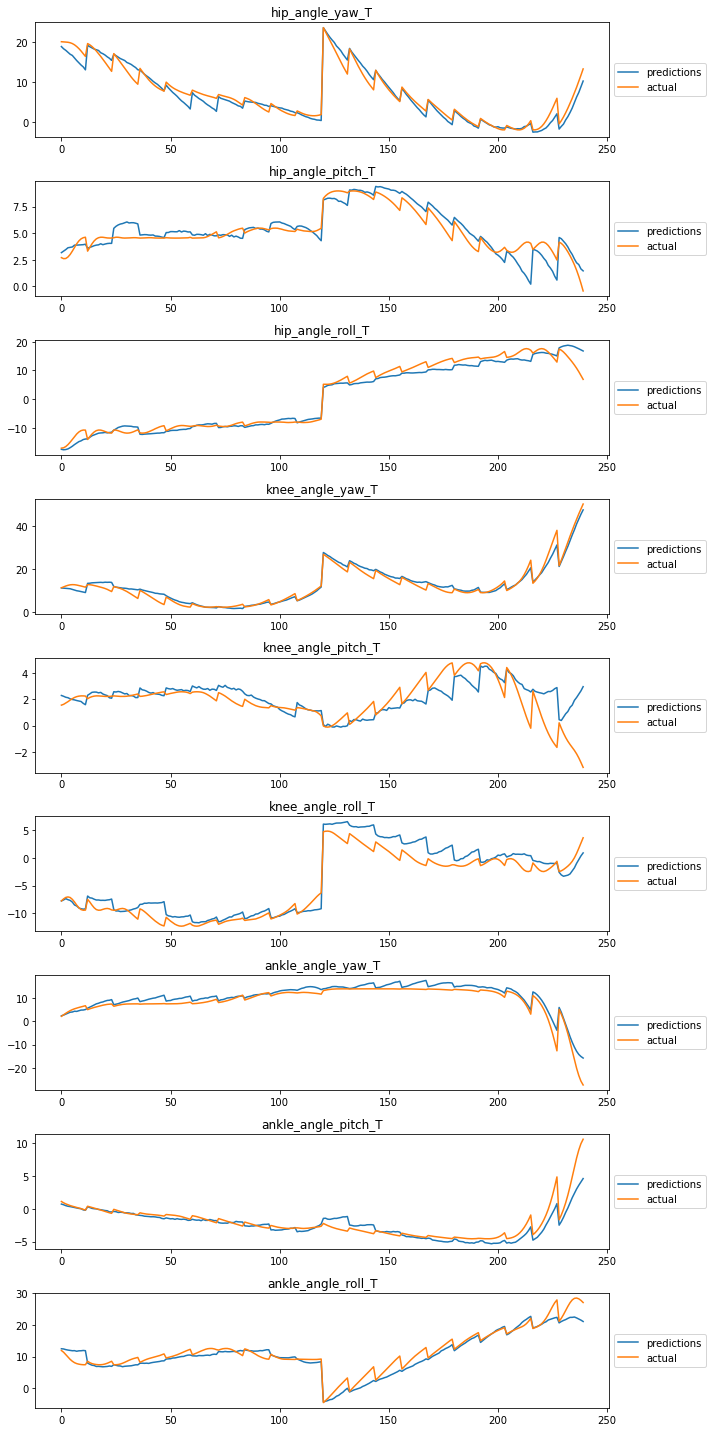

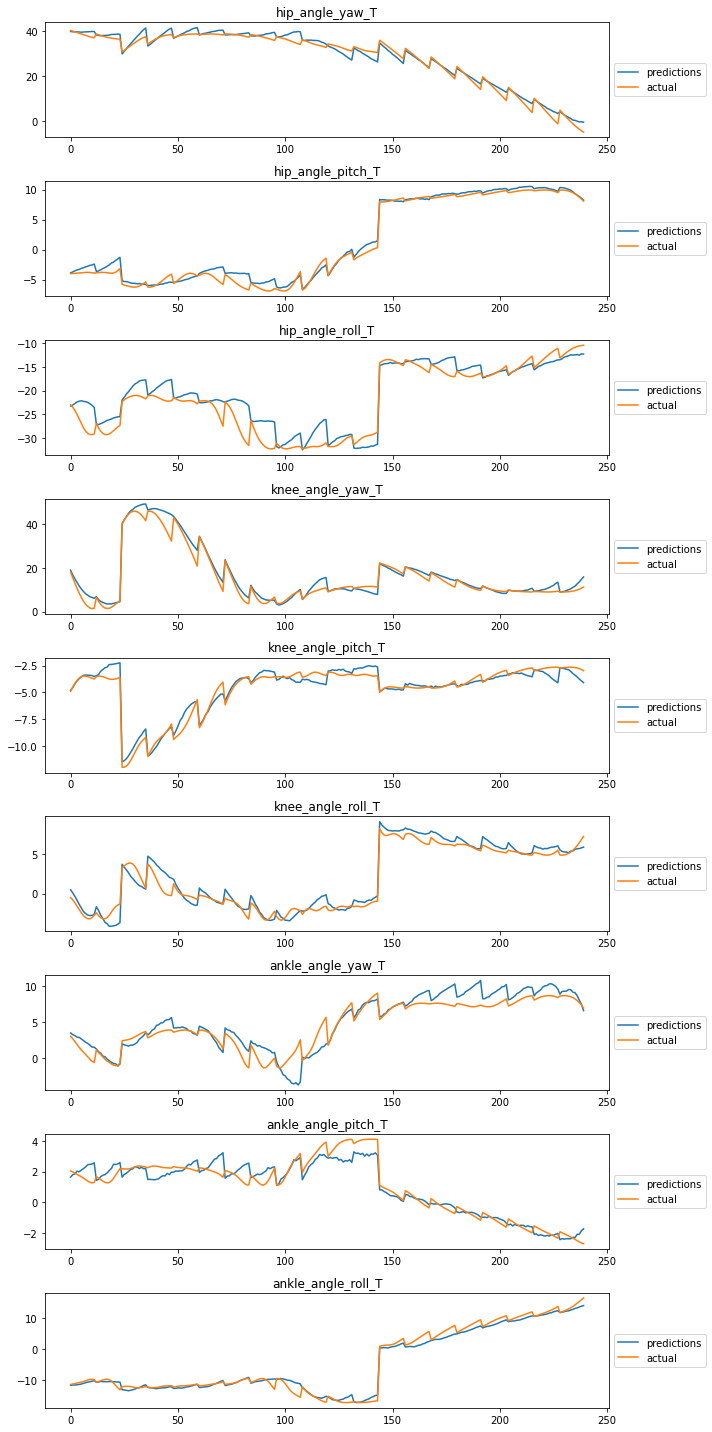

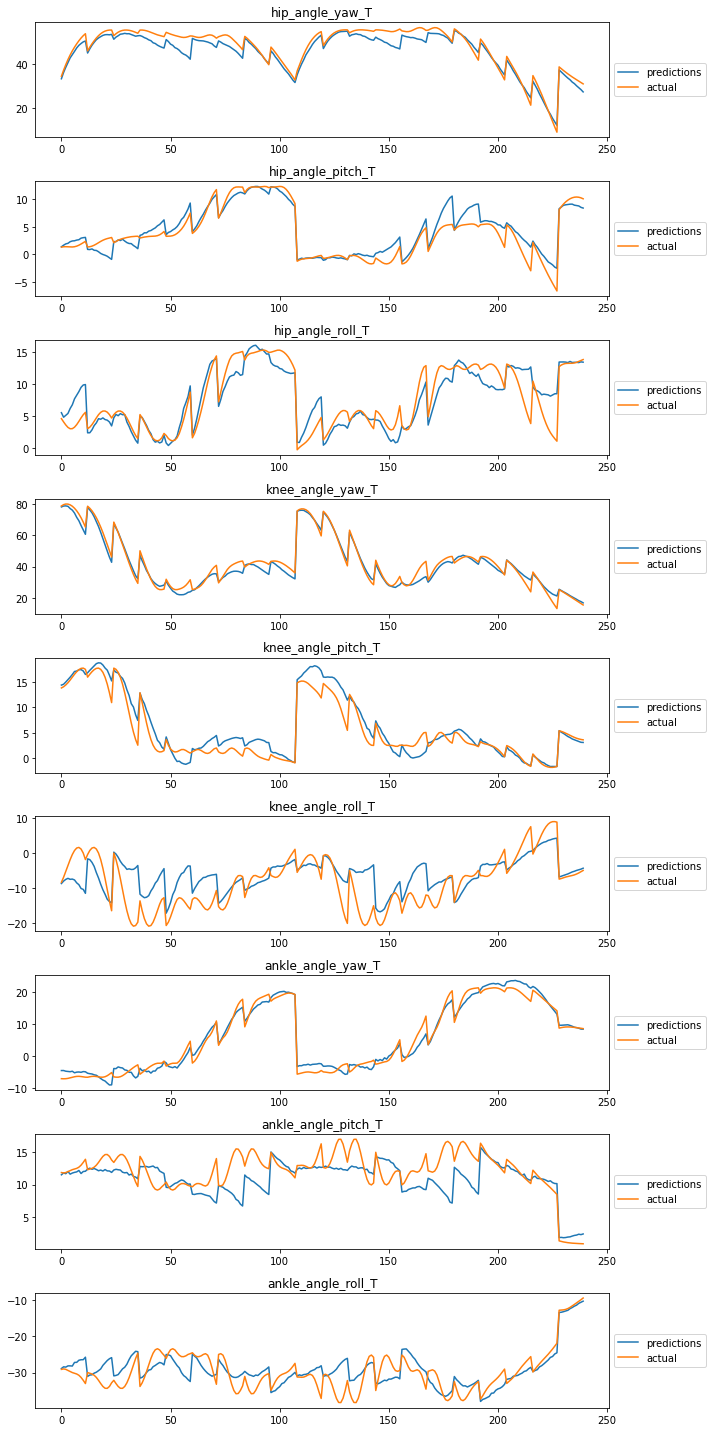

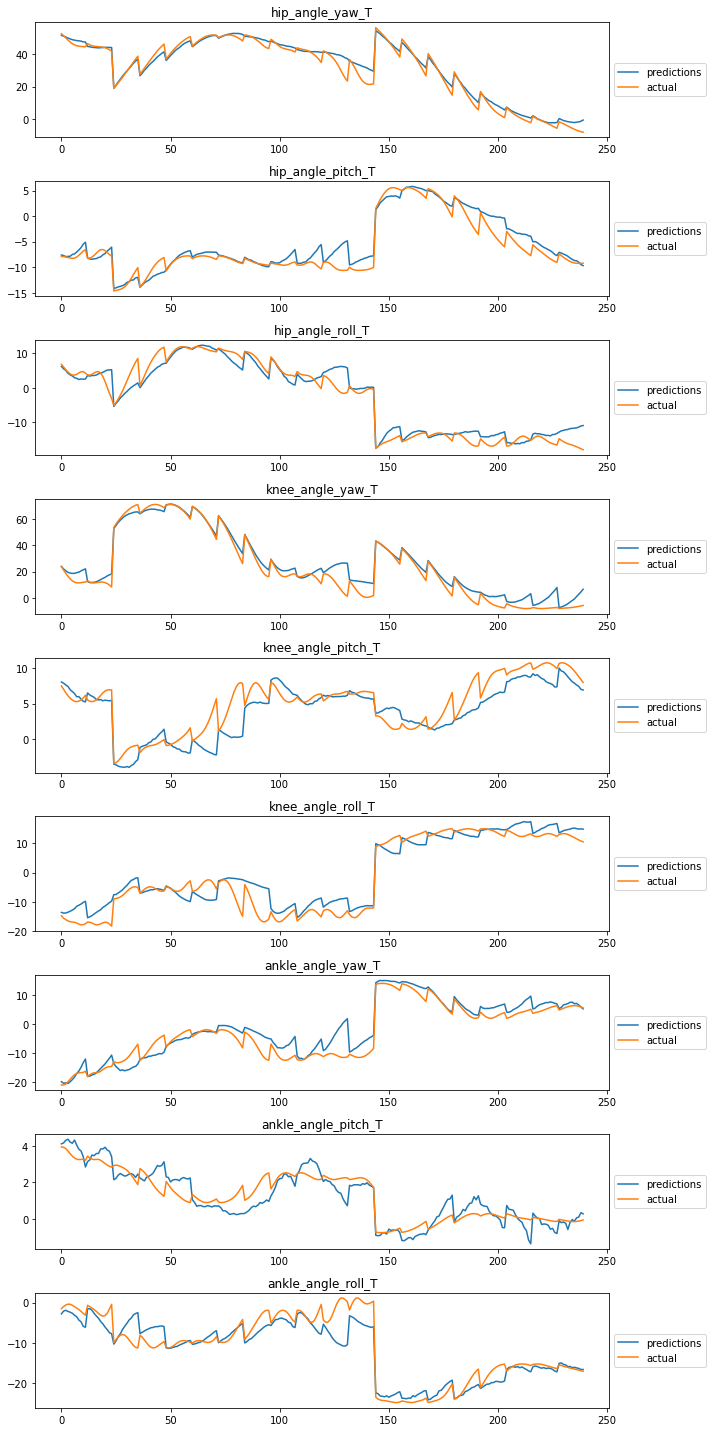

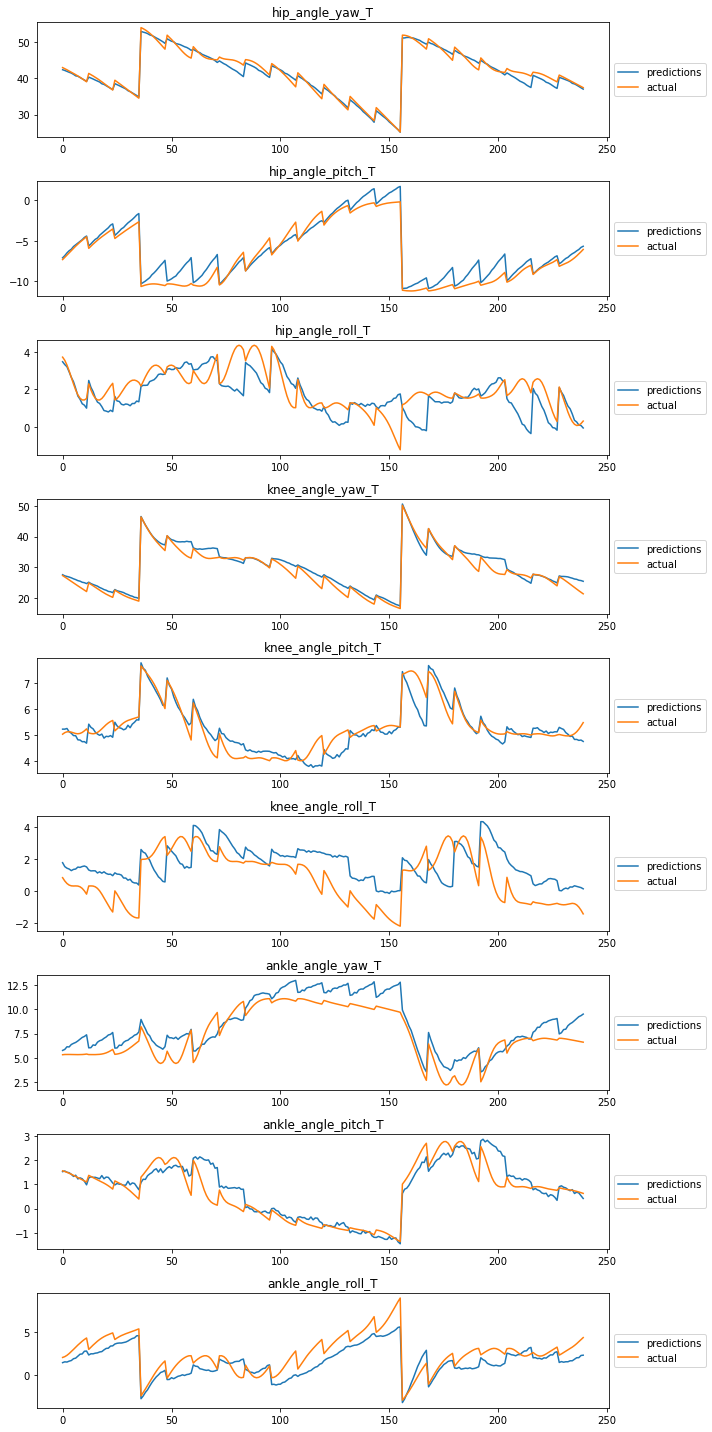

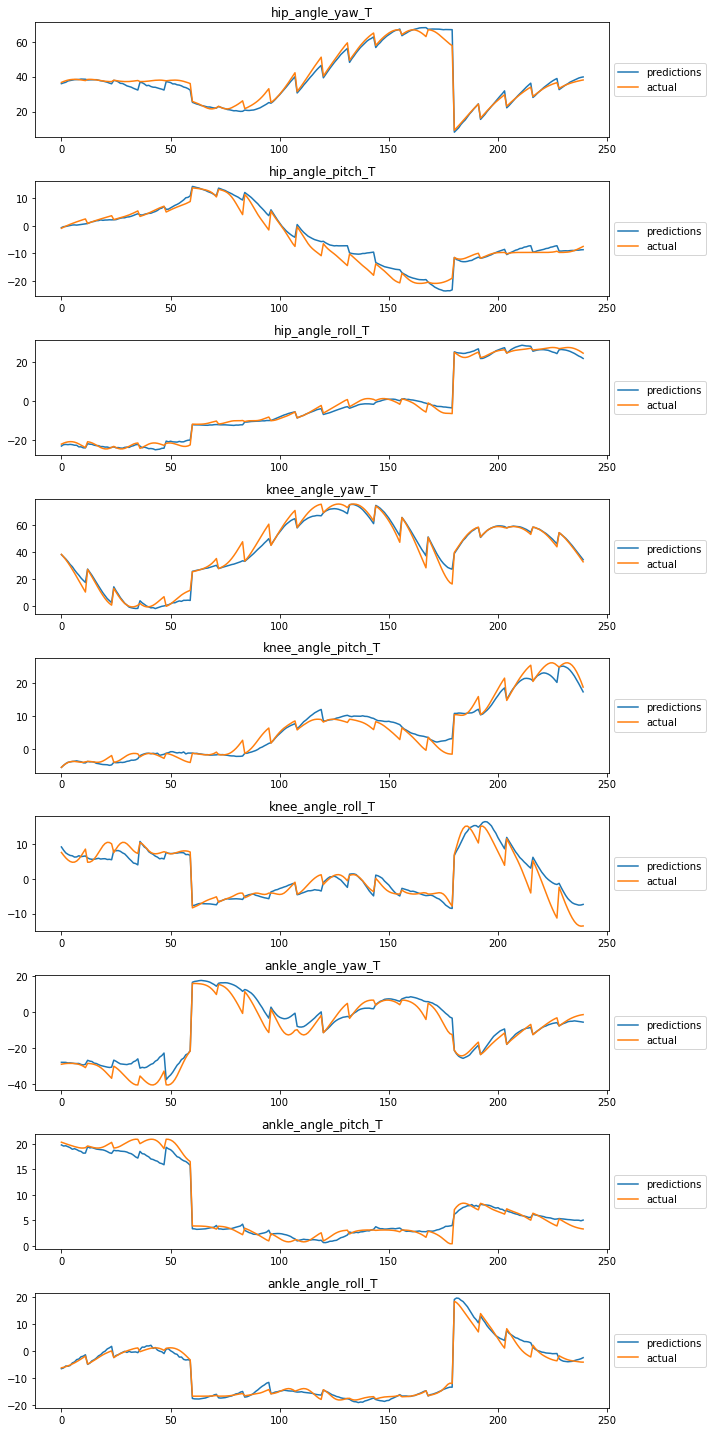

In [329]:
# Plot several random output examples
plt_width = 20 #number of time steps to plot
start_step = np.random.randint(0, high=(predicted_test_denorm.shape[0]-plt_width),size=6) #chooses random starting index to plot random samples

for i in start_step:
    print(f'Timestep ranges:{i}:{i+plt_width}')
    connected_preds=connect_arrays(predicted_test_denorm[i:i+plt_width,:,:],len(features))
    connected_targets=connect_arrays(actual_test_denorm[i:i+plt_width,:,:],len(features))
    plot_angles_but_cooler(connected_preds,connected_targets, len(features))
    plt.plot()
    

In [330]:
def plot_angles(predictions,actual_data,features=1,batch = 10,skip=100,concat= False):
    '''
    features: number of predicting angle (integer)
    batch: number of samples to plot(int)
    skip: batches stride (int)
    concat: concatenate all the predictions in for each angle 
     '''

    # plt.figure()
    plt.figure(figsize=(10,5))
    S= predictions.shape
    print(S)
    # size of the subplots: batch x features
    if concat:
        prd = predictions.reshape(-1,S[2])
        print(prd.shape)
        act = actual_data.reshape(-1,S[2])
        for f in range(features):
            plt.subplot(1,features,(f+1))
            plt.plot(prd[:batch,f],label='prediction')
            plt.plot(act[:batch,f],label='original data')
            #plt.ylim([-10,10])
            plt.legend()
            plt.title("Output predictions on test data")
            plt.show()   
    else:
        for f in range(features):
            # might want to randomise this
            for b in range(batch):
                plt.subplot(batch,features,(f+1)*(b+1))
                plt.plot(predictions[b*skip,:,f],label='prediction')
                plt.plot(actual_data[b*skip,:,f],label='original data')
                # plt.ylim([-50,50])
                plt.title(f'Plot of feature: {f}, sample {b*skip} ')
                plt.legend()
                plt.show()   

(200, 12, 9)
(2400, 9)


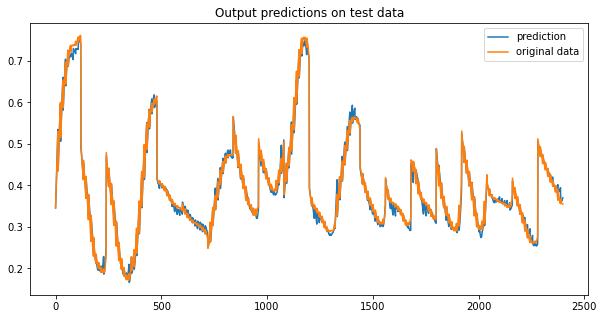

In [331]:
plot_angles(predicted_values_test[300:500],actual_values_test[300:500],features=1, batch = -1,concat=True)

(15010, 12, 9)


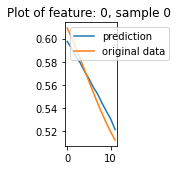

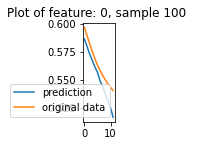

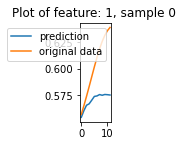

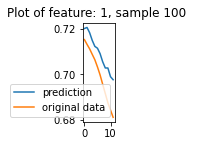

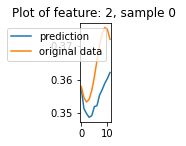

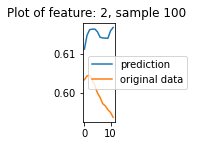

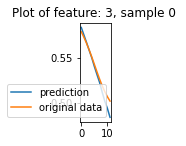

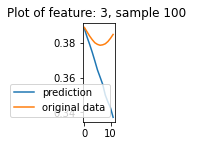

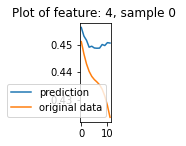

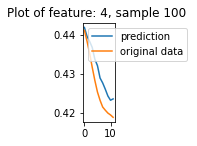

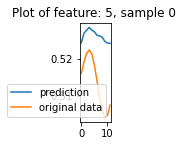

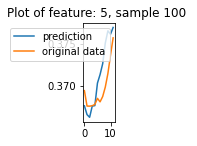

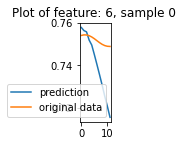

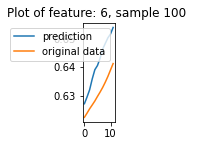

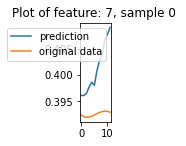

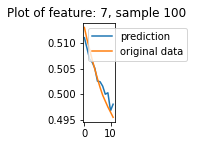

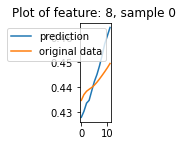

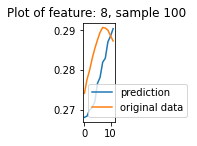

In [332]:
plot_angles(predicted_values_test,actual_values_test, features=len(features), batch = 2,concat=False)


### Calculate Covariance (Pearson Correlation Coefficient)

In [333]:
covariances = []
correlations = []

for f in range(len(features)):
    X = np.stack((predicted_test_denorm[:,:,f].reshape(-1,1), actual_test_denorm[:,:,f].reshape(-1,1)), axis=0).squeeze()
    # print(X.shape)
    cov = np.cov(X)
    covariances.append(cov[0][1]) # X = (m,n) m: variable, n: column is observation of the variable

    p_std = np.std(predicted_test_denorm[:,:,f].reshape(-1,1)) #predicted standard deviation 
    print(f'p_std: {p_std}')
    t_std = np.std(actual_test_denorm[:,:,f].reshape(-1,1)) #target standard deviation
    print(f't_std: {t_std}')

    correlations.append(cov[0][1] / (p_std*t_std))

print(covariances)
print(correlations)

mean_correlation = np.mean(correlations)
print(mean_correlation)

p_std: 17.976163864135742
t_std: 18.12363052368164
p_std: 6.828522205352783
t_std: 6.951180934906006
p_std: 12.641270637512207
t_std: 13.105063438415527
p_std: 18.995769500732422
t_std: 19.326305389404297
p_std: 5.636992931365967
t_std: 5.872190952301025
p_std: 7.107768535614014
t_std: 7.685507774353027
p_std: 13.679349899291992
t_std: 13.871052742004395
p_std: 5.480650901794434
t_std: 5.921360969543457
p_std: 15.32644271850586
t_std: 15.746841430664062
[323.9127408190102, 46.57072360915864, 162.33247242042026, 363.0470126346361, 31.89959978505927, 51.6612874956678, 185.85741936369956, 31.249212045662194, 238.46528674130167]
[0.9942275538461527, 0.981132511875692, 0.9798859622760085, 0.9889108436745311, 0.9636905291177393, 0.9457130230013441, 0.9795013368777242, 0.9629093575824524, 0.9880759920206882]
0.9760052344747037


In [334]:
for i in range(len(features)):
    print(f'{features[i]} covariance: {covariances[i]} | correlation: {correlations[i]}')

hip_angle_yaw_T covariance: 323.9127408190102 | correlation: 0.9942275538461527
hip_angle_pitch_T covariance: 46.57072360915864 | correlation: 0.981132511875692
hip_angle_roll_T covariance: 162.33247242042026 | correlation: 0.9798859622760085
knee_angle_yaw_T covariance: 363.0470126346361 | correlation: 0.9889108436745311
knee_angle_pitch_T covariance: 31.89959978505927 | correlation: 0.9636905291177393
knee_angle_roll_T covariance: 51.6612874956678 | correlation: 0.9457130230013441
ankle_angle_yaw_T covariance: 185.85741936369956 | correlation: 0.9795013368777242
ankle_angle_pitch_T covariance: 31.249212045662194 | correlation: 0.9629093575824524
ankle_angle_roll_T covariance: 238.46528674130167 | correlation: 0.9880759920206882


In [335]:
# checking covariances for features
covariances = []
correlations = []


X = np.stack((X_test_norm[:,:,7].reshape(-1,1), X_test_norm[:,:,6].reshape(-1,1)), axis=0).squeeze()
print(X.shape)
cov = np.cov(X)
print(cov)
covariances.append(cov[0][1]) # X = (m,n) m: variable, n: column is observation of the variable

p_std = np.std(X_test_norm[:,:,7].reshape(-1,1)) #predicted standard deviation 
t_std = np.std(X_test_norm[:,:,6].reshape(-1,1)) #target standard deviation

correlations.append(cov[0][1] / (p_std*t_std))

# print(covariances)
print(correlations)

# mean_correlation = np.mean(correlations)
# print(mean_correlation)

plt.plot

(2, 1080720)
[[ 0.00209776 -0.00139158]
 [-0.00139158  0.00910486]]
[-0.3184150997537289]


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

file: 1400
leg: 1.0


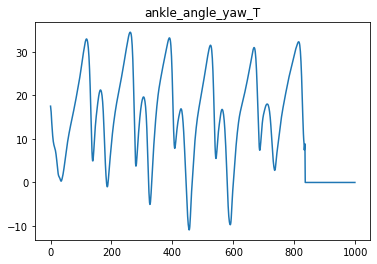

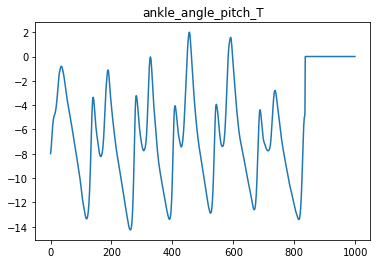

file: 1401
leg: 1.0


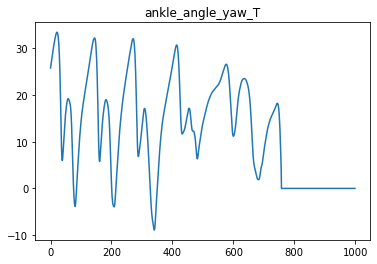

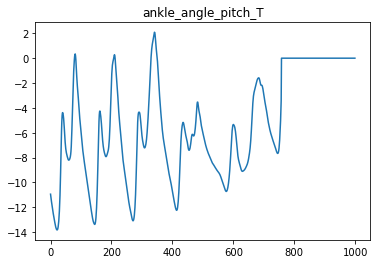

file: 1402
leg: 1.0


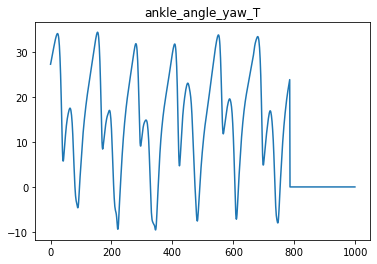

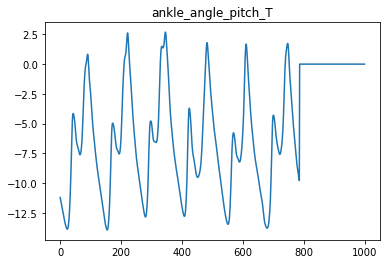

file: 1403
leg: 1.0


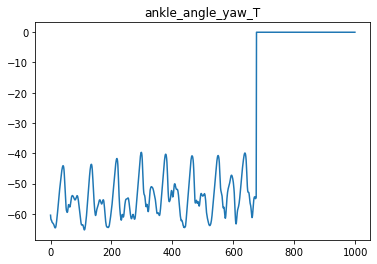

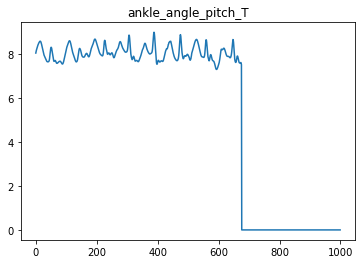

file: 1404
leg: 1.0


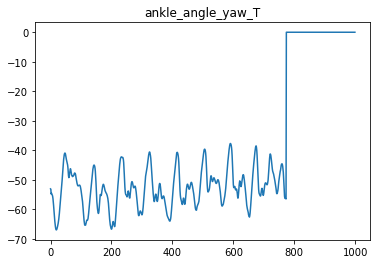

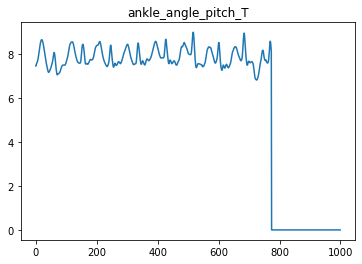

file: 1405
leg: 1.0


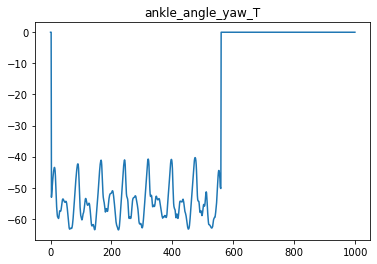

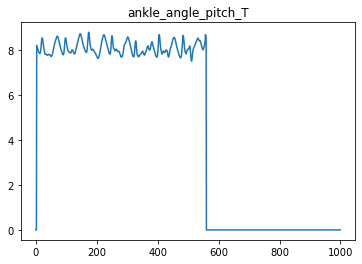

file: 1406
leg: 1.0


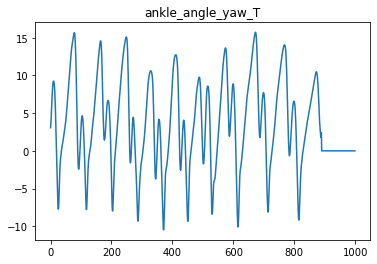

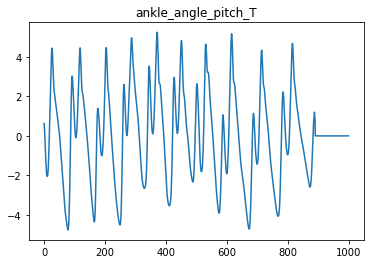

file: 1407
leg: 1.0


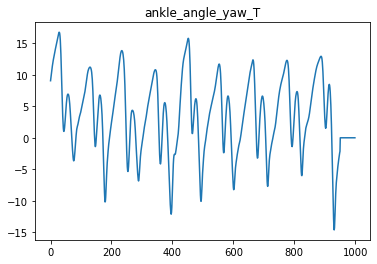

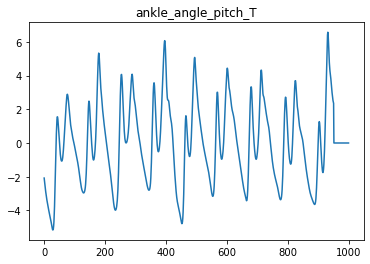

file: 1408
leg: 1.0


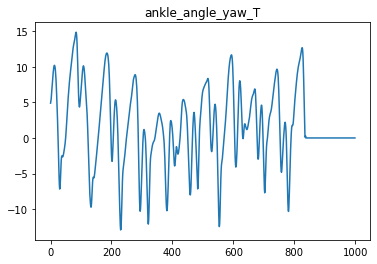

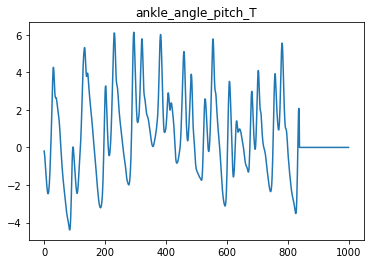

file: 1409
leg: 1.0


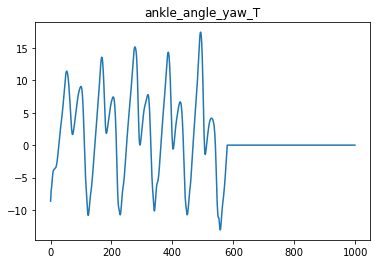

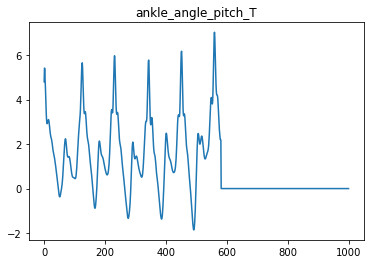

file: 1410
leg: 1.0


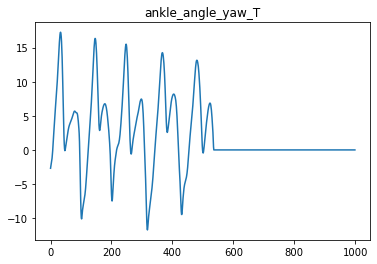

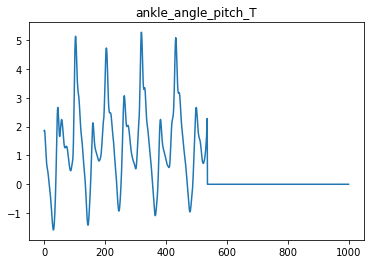

file: 1411
leg: 1.0


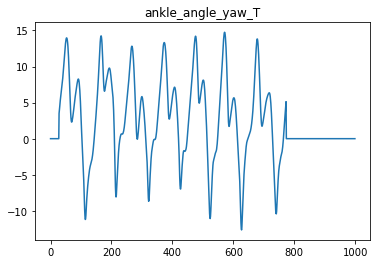

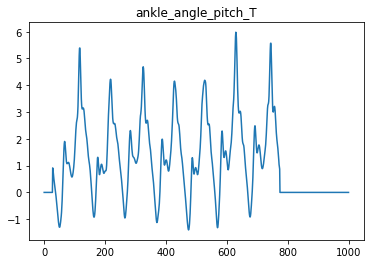

file: 1412
leg: 1.0


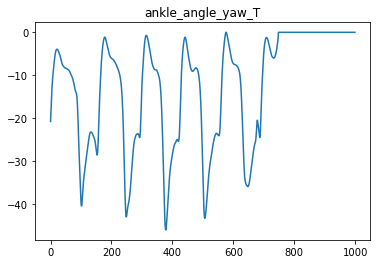

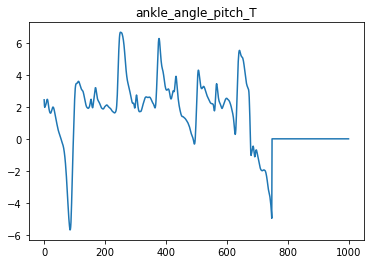

file: 1413
leg: 1.0


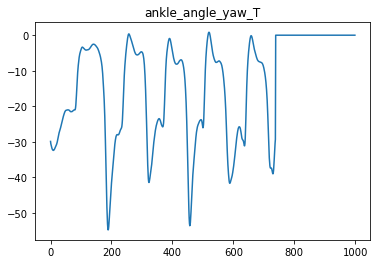

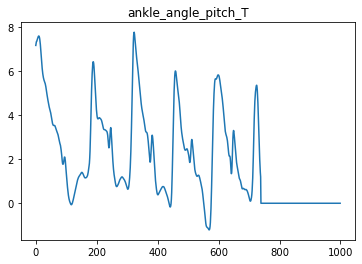

file: 1414
leg: 1.0


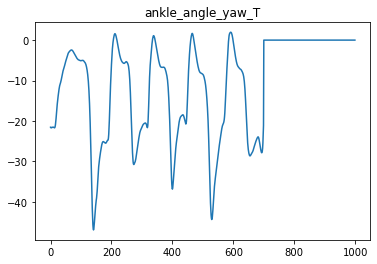

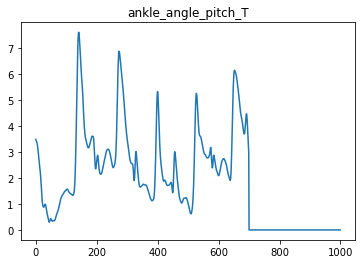

file: 1415
leg: 1.0


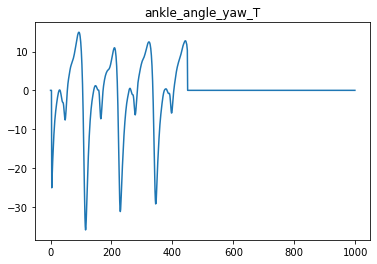

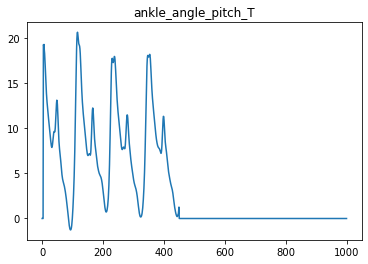

file: 1416
leg: 1.0


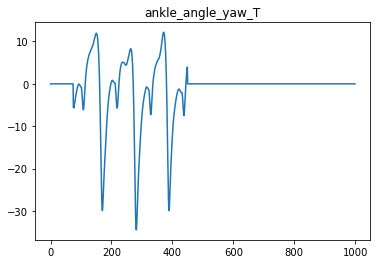

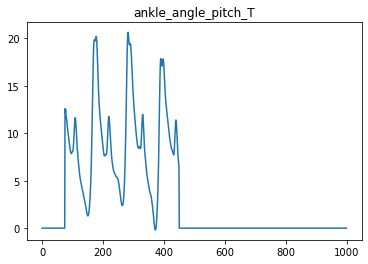

file: 1417
leg: 1.0


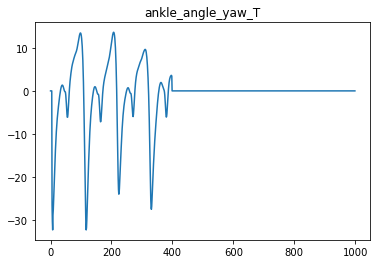

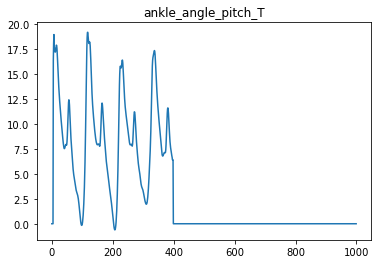

file: 1418
leg: 1.0


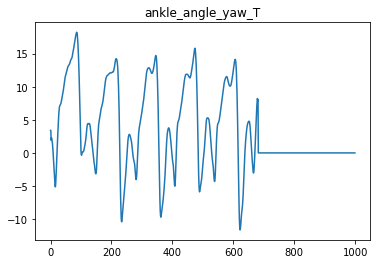

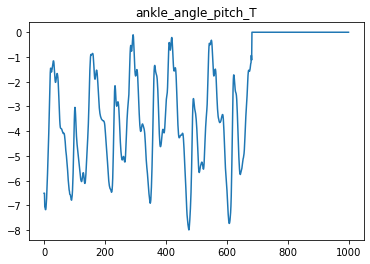

file: 1419
leg: 1.0


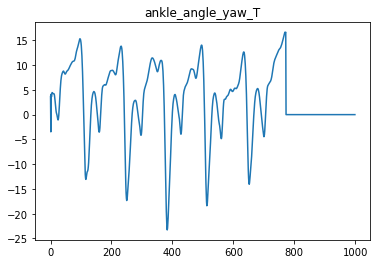

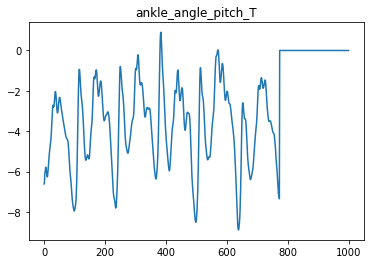

In [336]:
for m in range(1400,1420):
    # s=unique_idx[m]
    # # print(f'Outlier sample is: {s}')


    # ##### find the file 
    # # if 10 samples per file
    # file_numb = s//10

    # # print(f'File number is: {file_numb}')
    # file = filtered_index_test[file_numb]
    # print(f'Source of outlier: {file}')

    # # for f in range(len(features)):
    # #     x = np.arange(0,input_window+output_window)
    # #     plt.plot(x[:input_window],X_test_data[s,:,f].reshape(-1,1), label='X_test_data')
    # #     plt.plot(x[input_window:],predicted_test_denorm[s,:,f].reshape(-1,1), label='predicted_test_denorm')
    # #     plt.plot(x[input_window:], actual_test_denorm[s,:,f].reshape(-1,1), label='actual_test_denorm')
    # #     plt.title(str(features[f]) + str(f))

    # #     plt.legend()
    # #     plt.show()

    print(f'file: {m}')
    print(f'leg: {np.mean(test_data[m,:,-1])}')
    for feature in features:
        i = labels[feature]
        if i == 6 or i ==7:
            plt.plot(test_data[m,:1000,i], label=feature)
            plt.title(str(feature))
            plt.show()
    
    

    # ankle_yaw_roll_diff = np.sum(X_test_data[m,:,6] - X_test_data[m,:,7])
    # print(ankle_yaw_roll_diff)


In [337]:
# import statsmodels.api as sm
# # a = np.array([1,4,6,4,3,4,5,5,3,2,2])
# # b=np.array([2,3,1,3,4,3,2,2,3,3,3])

# # plt.axis([-40,40,-10,10])
# f, ax = plt.subplots(1, figsize=(8,5)) # for multiple plots
# sm.graphics.mean_diff_plot(actual_test_denorm[:,:,1].reshape(-1,1).squeeze(), predicted_test_denorm[:,:,1].reshape(-1,1).squeeze(), ax = ax)

# # sm.graphics.mean_diff_plot(a, b, ax = ax)
# plt.show()





### Calculate R2 (Coefficient of Determination)

In [338]:
r_squares = []
for f in range(len(features)):
    
    ss_res = np.sum((actual_test_denorm[:,:,f].reshape(-1,1) - predicted_test_denorm[:,:,f].reshape(-1,1)) ** 2)
    ss_tot = np.sum((actual_test_denorm[:,:,f].reshape(-1,1) - np.mean(actual_test_denorm[:,:,f].reshape(-1,1))) ** 2)

    r_squared = 1 - (ss_res/ss_tot)

    r_squares.append(r_squared)

mean_r_sqaured = np.mean(r_squares)
print(r_squares)
print(mean_r_sqaured)

[0.9881440419703722, 0.9614439606666565, 0.9597672112286091, 0.9778933469206095, 0.927510142326355, 0.8902941644191742, 0.9565830118954182, 0.9248218089342117, 0.9759886525571346]
0.9513829267687268


In [339]:
for i in range(len(features)):
    print(f'{features[i]} r_sqaured: {r_squares[i]}')

hip_angle_yaw_T r_sqaured: 0.9881440419703722
hip_angle_pitch_T r_sqaured: 0.9614439606666565
hip_angle_roll_T r_sqaured: 0.9597672112286091
knee_angle_yaw_T r_sqaured: 0.9778933469206095
knee_angle_pitch_T r_sqaured: 0.927510142326355
knee_angle_roll_T r_sqaured: 0.8902941644191742
ankle_angle_yaw_T r_sqaured: 0.9565830118954182
ankle_angle_pitch_T r_sqaured: 0.9248218089342117
ankle_angle_roll_T r_sqaured: 0.9759886525571346


### Plots for paper

mae_diff size: 1621080
mae loss mean: 1.4360833518395144
minimum loss: 0.0
maximum loss: 42.01380920410156
maximum loss corresponds to (angle): 42.01380920410156
Automatic MAE std: 1.7728224992752075
Manual MAE std: 1.7728225503976034
number of points larger than mean: 359060
threshold: 2


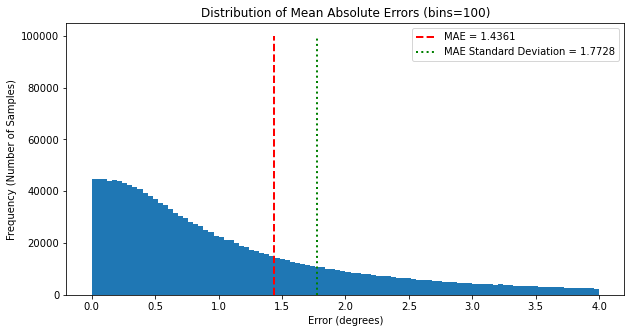

In [340]:
## Plot of distribution of error 
mae_diff = (np.abs(predicted_test_denorm[:,:,:] - actual_test_denorm[:,:,:])).reshape(-1,1).squeeze()
print(f'mae_diff size: {mae_diff.shape[0]}') 

mae_diff_mean = np.sum(mae_diff)/mae_diff.shape[0] 
print(f'mae loss mean: {mae_diff_mean}')

print(f'minimum loss: {mae_diff.min()}')
print(f'maximum loss: {mae_diff.max()}')
print(f'maximum loss corresponds to (angle): {mae_diff.max()}')


auto_mae_std = np.std(mae_diff)
print(f'Automatic MAE std: {auto_mae_std}')

manual_mae_std = np.sqrt((1/mae_diff.shape[0]) * np.sum((mae_diff-test_mae_loss) ** 2))

# manual_mae_std = (1/mae_diff.shape[0]) * np.sum(np.abs(mae_diff-test_mae_loss))
print(f'Manual MAE std: {manual_mae_std}')

plt.figure(figsize=(10,5))
# plt.hist(mae_diff, bins=200, range=(0,mae_diff.max()))
plt.hist(mae_diff, bins=100, range=(0,4), facecolor='tab:blue')
plt.vlines(x=mae_diff_mean, ymin=0, ymax=100000, linestyles ="dashed", colors ="r", linewidth=2, label='MAE = ' + '{:.4f}'.format(mae_diff_mean))
plt.vlines(x=auto_mae_std, ymin=0, ymax=100000, linestyles ="dotted", colors ="g", linewidth=2, label='MAE Standard Deviation = ' + '{:.4f}'.format(auto_mae_std))
plt.title('Distribution of Mean Absolute Errors (bins=100)')
plt.xlabel('Error (degrees)')
plt.ylabel('Frequency (Number of Samples)')
plt.legend()

mae_diff.shape[0]

threshold = 2
larger_than_mean = np.where(mae_diff>threshold)
print(f'number of points larger than mean: {len(larger_than_mean[0])}')

print(f'threshold: {threshold}')
percentage = len(larger_than_mean[0])/mae_diff.shape[0] *100
# print(f'percentage of values above the threshold: {percentage}')

mae_diff size: 1621080
mae loss mean: 0.13243309437227033
minimum loss: -34.740577697753906
maximum loss: 42.01380920410156
maximum loss corresponds to (angle): 42.01380920410156
Automatic MAE std: 2.27765154838562
Manual MAE std: 2.6243477523331027


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


number of points larger than mean: 197886
threshold: 2


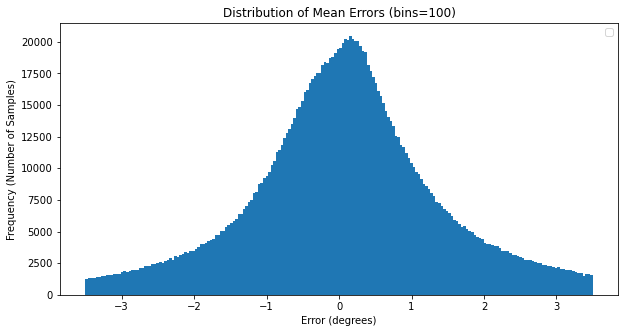

In [341]:
## Plot of distribution of error 
mae_diff = ((predicted_test_denorm[:,:,:] - actual_test_denorm[:,:,:])).reshape(-1,1).squeeze()
print(f'mae_diff size: {mae_diff.shape[0]}') 

mae_diff_mean = np.sum(mae_diff)/mae_diff.shape[0] 
print(f'mae loss mean: {mae_diff_mean}')

print(f'minimum loss: {mae_diff.min()}')
print(f'maximum loss: {mae_diff.max()}')
print(f'maximum loss corresponds to (angle): {mae_diff.max()}')


auto_mae_std = np.std(mae_diff)
print(f'Automatic MAE std: {auto_mae_std}')

manual_mae_std = np.sqrt((1/mae_diff.shape[0]) * np.sum((mae_diff-test_mae_loss) ** 2))

# manual_mae_std = (1/mae_diff.shape[0]) * np.sum(np.abs(mae_diff-test_mae_loss))
print(f'Manual MAE std: {manual_mae_std}')

plt.figure(figsize=(10,5))
# plt.hist(mae_diff, bins=200, range=(0,mae_diff.max()))
plt.hist(mae_diff, bins=200, range=(-3.5,3.5), facecolor='tab:blue')
# plt.vlines(x=mae_diff_mean, ymin=0, ymax=20000, linestyles ="dashed", colors ="r", linewidth=2, label='MAE = ' + '{:.4f}'.format(mae_diff_mean))
# plt.vlines(x=auto_mae_std, ymin=0, ymax=20000, linestyles ="dotted", colors ="g", linewidth=2, label='MAE Standard Deviation = ' + '{:.4f}'.format(auto_mae_std))
plt.title('Distribution of Mean Errors (bins=100)')
plt.xlabel('Error (degrees)')
plt.ylabel('Frequency (Number of Samples)')
plt.legend()

mae_diff.shape[0]

threshold = 2
larger_than_mean = np.where(mae_diff>threshold)
print(f'number of points larger than mean: {len(larger_than_mean[0])}')

print(f'threshold: {threshold}')
percentage = len(larger_than_mean[0])/mae_diff.shape[0] *100
# print(f'percentage of values above the threshold: {percentage}')

In [342]:
# Loss for each indiividual timestep
# mse_feature_test = []
# for f in range(len(features)):
#     _ = mse_loss(np.expand_dims(predicted_test_denorm[:,:,f],-1), 
#                     np.expand_dims(actual_test_denorm[:,:,f],-1), 
#                     reduction='mean', 
#                     format='np')
                    
#     mse_feature_test.append(_)
#     print(f'MSE loss for feature {f} corresponding to {features[f]} is: {mse_feature_test[f]}')

mae_timesteps = []
for s in range(output_window):
    # print(s)
    _ = mae_loss(np.expand_dims(predicted_test_denorm[:,s,:],-1), np.expand_dims(actual_test_denorm[:,s,:],-1), reduction='mean', format='np')
    mae_timesteps.append(_)

    print(f'MAE loss and standard deviation for timestep {s+1} is: {mae_timesteps[s]}')

predicted_test_denorm[:,:,:].shape




MAE loss and standard deviation for timestep 1 is: (0.5728107187800725, 0.7000027)
MAE loss and standard deviation for timestep 2 is: (0.6394442478162706, 0.7730582)
MAE loss and standard deviation for timestep 3 is: (0.7920924244947812, 0.9095574)
MAE loss and standard deviation for timestep 4 is: (0.9645485185802058, 1.0734022)
MAE loss and standard deviation for timestep 5 is: (1.1594124750166557, 1.2730396)
MAE loss and standard deviation for timestep 6 is: (1.3455745937893258, 1.4652363)
MAE loss and standard deviation for timestep 7 is: (1.5298781136649642, 1.6516001)
MAE loss and standard deviation for timestep 8 is: (1.7121119485158043, 1.8403152)
MAE loss and standard deviation for timestep 9 is: (1.8862165963431787, 2.0149221)
MAE loss and standard deviation for timestep 10 is: (2.051859408542453, 2.1795292)
MAE loss and standard deviation for timestep 11 is: (2.21267002553853, 2.3434515)
MAE loss and standard deviation for timestep 12 is: (2.3663821341328, 2.495307)


(15010, 12, 9)

In [343]:
hip_mae, hip_mae_std =  mae_loss(predicted_test_denorm[:,:,0:3], actual_test_denorm[:,:,0:3], reduction='mean', format='np')
knee_mae, knee_mae_std =  mae_loss(predicted_test_denorm[:,:,3:6], actual_test_denorm[:,:,3:6], reduction='mean', format='np')
ankle_mae, ankle_mae_std =  mae_loss(predicted_test_denorm[:,:,6:9], actual_test_denorm[:,:,6:9], reduction='mean', format='np')

print(f'hip MAE and std: {hip_mae}, {hip_mae_std}')
print(f'knee MAE and std: {knee_mae}, {knee_mae_std}')
print(f'ankle MAE and std: {ankle_mae}, {ankle_mae_std}')

hip MAE and std: 1.3360991977570509, 1.5611391067504883
knee MAE and std: 1.5067983612776668, 1.8641607761383057
ankle MAE and std: 1.4653526121474574, 1.8709877729415894


In [344]:
print('loss')
for i in mae_timesteps:
    print(i[0])

print('loss std')
for i in mae_timesteps:
    print(i[1])

print('joint')
print(hip_mae)
print(knee_mae)
print(ankle_mae)

print('joint std')
print(hip_mae_std)
print(knee_mae_std)
print(ankle_mae_std)

loss
0.5728107187800725
0.6394442478162706
0.7920924244947812
0.9645485185802058
1.1594124750166557
1.3455745937893258
1.5298781136649642
1.7121119485158043
1.8862165963431787
2.051859408542453
2.21267002553853
2.3663821341328
loss std
0.7000027
0.7730582
0.9095574
1.0734022
1.2730396
1.4652363
1.6516001
1.8403152
2.0149221
2.1795292
2.3434515
2.495307
joint
1.3360991977570509
1.5067983612776668
1.4653526121474574
joint std
1.5611391
1.8641608
1.8709878


### Saving Results

#### Selecting file name and location 

In [345]:
model = 'MLP'
exp_ID = '049'

# out_fname = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Results\LSTM_1' + '\\' + 'Exp' + str(exp_ID) + '-' + str(date.today()) + '-' + model + '-In' + str(input_window) + '-Out' + str(output_window) + '.txt'
# out_fname = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Results\LSTM_2' + '\\' + 'Exp' + str(exp_ID) + '-' + str(date.today()) + '-' + model + '-In' + str(input_window) + '-Out' + str(output_window) + '.txt'
out_fname = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Results' + '\\' + 'Exp' + str(exp_ID) + '-' + str(date.today()) + '-' + model + '-In' + str(input_window) + '-Out' + str(output_window) + '.txt'
# out_fname = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Results\LSTM_3' + '\\' + 'Exp' + str(exp_ID) + '-' + str(date.today()) + '-' + model + '-In' + str(input_window) + '-Out' + str(output_window) + '.txt'
# out_fname = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Results\CNN_1' + '\\' + 'Exp' + str(exp_ID) + '-' + str(date.today()) + '-' + model + '-In' + str(input_window) + '-Out' + str(output_window) + '.txt'



out_fname

'C:\\Users\\Rania\\rbk9\\Study 1 Results and Models\\Study 1 Results\\Exp049-2022-03-06-MLP-In72-Out12.txt'

In [346]:
changes = 'Ran' + str(model)+ 'model with 6 features, ' + str(input_window)+  ' input and ' + str(output_window) + ' outputs. Testing the values achieved using hyperparameter optimisation. '
comments = 'Exp' + str(exp_ID) + '-' + str(date.today()) + '-' + model + ': ' + changes + '|' + 'test MAE loss: ' + str(round(test_mae_loss, 3)) + ' ' +'std: ' + str(round(test_mae_std,3))
comments

'Exp049-2022-03-06-MLP: RanMLPmodel with 6 features, 72 input and 12 outputs. Testing the values achieved using hyperparameter optimisation. |test MAE loss: 1.436 std: 1.773'

In [347]:
# fname = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Results\LSTM_1' + '\\' + 'LSTM Experiment Results.txt'
# fname = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Results\LSTM_2' + '\\' + 'LSTM_2 Experiment Results.txt'
fname = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Results' + '\\' + 'Experiments.txt'
# fname = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Results\LSTM_3' + '\\' + 'LSTM_3 Experiment Results.txt'
# fname = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Results\CNN_1' + '\\' + 'CNN_1 Experiment Results.txt'


with open(fname, 'a+') as text_file:
    text_file.write('\n')
    text_file.write(comments)



In [348]:
os.path.exists(out_fname)

False

In [349]:
if os.path.exists(out_fname):
    print('ERROR: File with this name already exists, try alternative name.')
    
else:
    with open(out_fname, "w") as text_file:
        print('Experiment Report', file=text_file)
        print(f'date: {date.today()}',file=text_file)
        print(f'experiment ID: {exp_ID}',file=text_file)
        print('\n', file=text_file)
        print('Changes:', file=text_file)
        print(changes, file=text_file)
        print('\n', file= text_file)
        print(f'model: {model}', file=text_file)
        print(f'features: {features}', file=text_file)

        print(f'input window size: {input_window}', file=text_file)
        print(f'output window size: {output_window}', file=text_file)
        print(f'stride: {stride}', file=text_file)
    
    
        print(f'train size: {train_sample_sum}', file=text_file)
        # print(f'validation size: {val_sample_sum}', file=text_file)
        print(f'test size: {test_sample_sum}', file=text_file)

        print(f'train precentage: {0.8}', file=text_file)
        print(f'validation percentage: {0.2}', file=text_file)
 
        print(f'train samples: {len(filtered_index_train) - len(train_excluded_samples)}', file=text_file)
        # print(f'validation samples: {len(filtered_index_val)- len(val_excluded_samples)}', file=text_file) 
        print(f'test sample: {len(filtered_index_test) - len(test_excluded_samples)}', file=text_file) 
        # print(f'Note: training is based on combined training and validation set.', file=text_file) 
        
        ### MLP
        # print(f'epochs: {num_epochs}', file=text_file)
        # print(f'learning rate: {learning_rate}', file=text_file)
        
        ## LSTM
        # print(f'epochs: {num_epochs}', file=text_file)
        # print(f'hidden size: {hidden_size}', file=text_file)
        # print(f'number of layers: {num_layers}', file=text_file)
        # print(f'learning rate: {learning_rate}', file=text_file)
        # print(f'optimiser: MSE', file=text_file)

        ## CNN
        # print(f'epochs: {num_epochs}', file=text_file)
        # print(f'kernel size: {kernel_size}', file=text_file)
        # print(f'learning rate: {learning_rate}', file=text_file)
        print(f'optimiser: MSE', file=text_file)

        ### Hybrid
        # print(f'epochs: {num_epochs}', file=text_file)
        # print(f'learning rate: {learning_rate}', file=text_file)
        # print(f'hidden size: {hidden_size}', file=text_file)
        # print(f'number of layers: {num_layers}', file=text_file)

        print(f'Losses during training: \n', file=text_file)
        print(f'training loss: {train_history}', file=text_file)
        # print(f'validation history: {val_history}', file=text_file)
        print(f'test loss during training: {test_loss}', file=text_file)

        print('\n', file=text_file)
        print(f'Denomralised MSE and MAE: ', file=text_file)
        # print(f'Validation MSE and std(degrees): {val_mse_loss}, {val_mse_std}', file=text_file)
        # print(f'Validation MAE and std (degrees): {val_mae_loss}, {val_mae_std}', file=text_file)
        print(f'Test MSE and std(degrees): {test_mse_loss}, {test_mse_std}', file=text_file)
        print(f'Test MAE and std (degrees): {test_mae_loss}, {test_mae_std}', file=text_file)
        print('\n', file=text_file)

        # print(f'Loss for each feature in the validation set:', file=text_file)
        # for i, f in enumerate(features):
        #     print(f'MSE and MAE loss and std for {f}: {mse_feature_val[i]}, {mae_feature_val[i]}', file=text_file)


        print(f'Loss for each feature in the test set:', file=text_file)
        for i, f in enumerate(features):
            print(f'MSE and MAE loss and std for {f}: {mse_feature_test[i]}, {mae_feature_test[i]}', file=text_file)

        # print('\n', file=text_file)
        # print(f'mean_correlation: {mean_correlation}', file=text_file)
        # for i in range(len(features)):
        #     print(f'{features[i]} covariance: {covariances[i]} | correlation: {correlations[i]}', file=text_file)


        # print('\n', file=text_file)
        # print(f'mean coefficient of determination: {mean_r_sqaured}', file=text_file)
        # for i in range(len(features)):
        #     print(f'{features[i]} r_sqaured: {r_squares[i]}', file=text_file)

        print('\n', file = text_file)
        print(f'Model Architecture', file=text_file)
        print(model_MLP, file=text_file)
    print("Generation of text file complete.")

Generation of text file complete.


#### Save loss plot

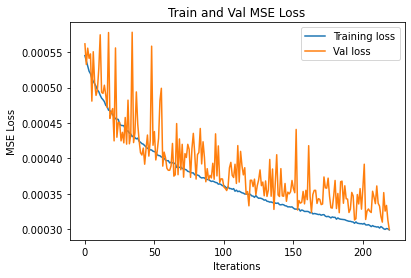

In [350]:
plt_path = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Results' + '\\'  + 'Exp' + str(exp_ID) + '-' + str(date.today()) + '-' + model + ' (loss 2)' + '.png'
# plt_path = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Results\CNN_1' + '\\'  + 'Exp' + str(exp_ID) + '-' + str(date.today()) + '-' + model + ' (loss)' + '.png'


# plt_path = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Results\LSTM_3' + '\\'  + 'Exp' + str(exp_ID) + '-' + str(date.today()) + '-' + model + '-In' + str(input_window) + '-Out' + str(output_window) + '(loss)' + '.png'
# x = [i for i in range(20,num_epochs-5)]
# print(x)
# print(train_history[20:145].shape)
# plt.plot(x,train_history[20:145], label = 'Training loss')
# plt.plot(x,val_history[20:145], label = 'Test loss')
plt.plot(train_history[20:], label = 'Training loss')
plt.plot(val_history[20:], label = 'Val loss')


plt.xlabel('Iterations')
plt.ylabel('MSE Loss')
plt.title('Train and Val MSE Loss')
plt.legend()
plt.savefig(plt_path)

#### Save preds plot

Timestep ranges:9539:9739


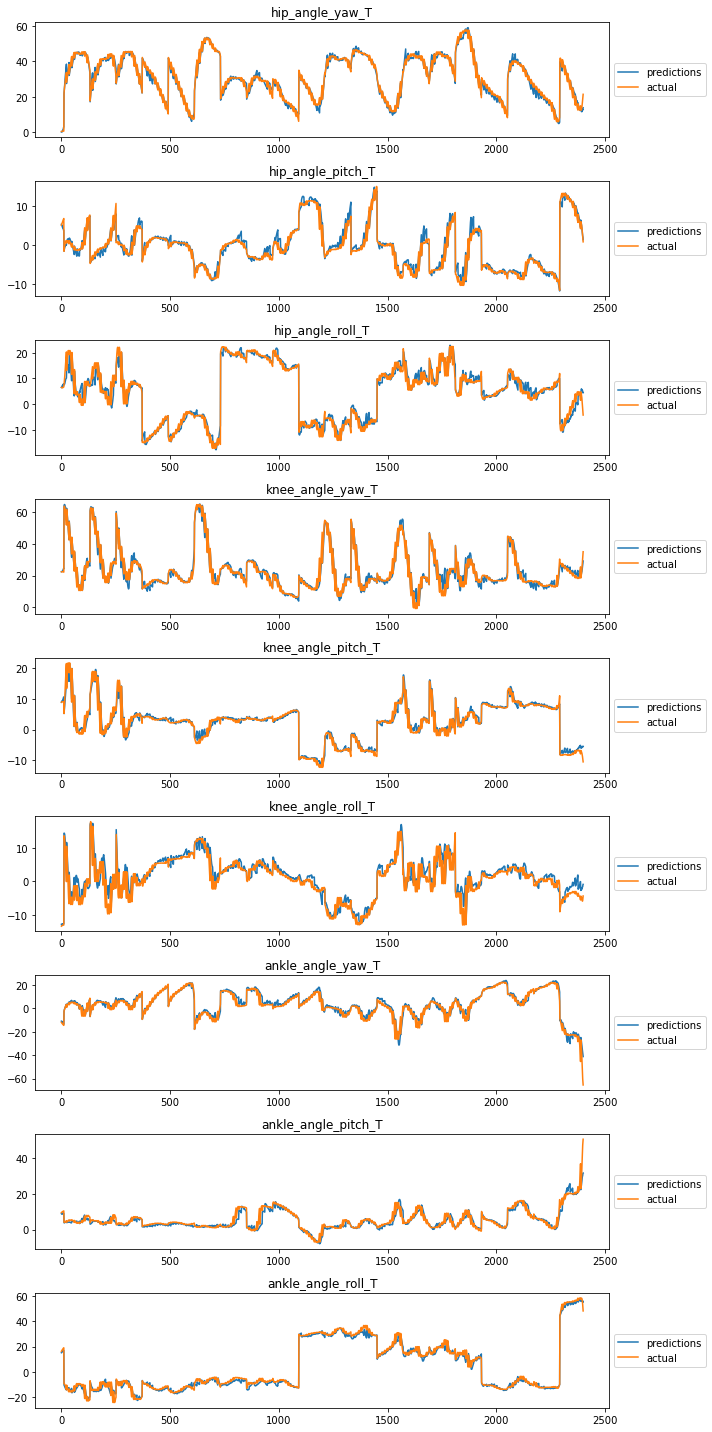

In [351]:
# Plot several random output examples
plt_path = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Results' + '\\'  + 'Exp' + str(exp_ID) + '-' + str(date.today()) + '-' + model + '-In' + str(input_window) + '-Out' + str(output_window) + '(test preds)' + '.png'
# plt_path = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Results\CNN_1' + '\\'  + 'Exp' + str(exp_ID) + '-' + str(date.today()) + '-' + model + '-In' + str(input_window) + '-Out' + str(output_window) + '(test preds)' + '.png'

# plt_path = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Results\LSTM_3' + '\\'  + 'Exp' + str(exp_ID) + '-' + str(date.today()) + '-' + model + '-In' + str(input_window) + '-Out' + str(output_window) + '(test preds)' + '.png'

plt_width = 200 #number of time steps to plot
start_step = np.random.randint(0, high=(predicted_test_denorm.shape[0]-plt_width),size=1) #chooses random starting index to plot random samples

for i in start_step:
    print(f'Timestep ranges:{i}:{i+plt_width}')
    connected_preds=connect_arrays(predicted_test_denorm[i:i+plt_width,:,:],len(features))
    connected_targets=connect_arrays(actual_test_denorm[i:i+plt_width,:,:],len(features))
    plot_angles_but_cooler(connected_preds,connected_targets, len(features))
    plt.savefig(plt_path)

#### Save model and weights

In [352]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model_MLP.state_dict():
    print(param_tensor, "\t", model_MLP.state_dict()[param_tensor].size())

Model's state_dict:
MLP.0.weight 	 torch.Size([200, 648])
MLP.0.bias 	 torch.Size([200])
MLP.2.weight 	 torch.Size([200, 200])
MLP.2.bias 	 torch.Size([200])
MLP.4.weight 	 torch.Size([200, 200])
MLP.4.bias 	 torch.Size([200])
MLP.6.weight 	 torch.Size([200, 200])
MLP.6.bias 	 torch.Size([200])
MLP.8.weight 	 torch.Size([108, 200])
MLP.8.bias 	 torch.Size([108])


#### Export model/weights

In [353]:
# Export model
export_path = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Models' + '\\'  + 'Exp' + str(exp_ID) + '-' + str(date.today()) + '-' + model+ '-In' + str(input_window) + '-Out' + str(output_window) +'.pickle'
# export_path = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Models\CNN_1' + '\\'  + 'Exp' + str(exp_ID) + '-' + str(date.today()) + '-' + model+ '-In' + str(input_window) + '-Out' + str(output_window) +'.pickle'

# export_path = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Models\LSTM_3' + '\\'  + 'Exp' + str(exp_ID) + '-' + str(date.today()) + '-' + model+ '-In' + str(input_window) + '-Out' + str(output_window) +'.pickle'


export_path

'C:\\Users\\Rania\\rbk9\\Study 1 Results and Models\\Study 1 Models\\Exp049-2022-03-06-MLP-In72-Out12.pickle'

In [354]:
torch.save(model_MLP.state_dict(), export_path)

#### Import model/weights

In [355]:
# print(model_CNN)

In [356]:
# fname = r'C:\Users\Rania\OneDrive - University of Kent\data_pickle' + '\\' + 'alldata_test_L.pickle'

# # fname= r'D:\rbk9\data_pickle' + '\\' + 'test_data.pickle'

# with open(fname, 'rb') as handle:
#     test_data = pickle.load(handle)

# test_size = test_data.shape[0]

# print(f"Shape of test data is: {test_data.shape}")
# print(f"test_size: {test_size}")